# Coronavirus (COVID-19) Visualization & Prediction  
Coronavirus is a family of viruses that are named after their spiky crown. The novel coronavirus, also known as SARS-CoV-2, is a contagious respiratory virus that first reported in Wuhan, China. On 2/11/2020, the World Health Organization designated the name COVID-19 for the disease caused by the novel coronavirus. This notebook aims at exploring COVID-19 through data analysis and projections. 

   Coronavirus Case Data is provided by <a href='https://github.com/CSSEGISandData/COVID-19'>Johns Hopkins University</a>
   
   


   
* <a href='#world_wide_graphs'>Exploring Global Coronavirus Cases</a>
* <a href='#country_graphs'>Exploring Coronavirus Cases From Different Countries</a>
* <a href='#prediction'>Worldwide Confirmed Cases Prediction</a>

In [40]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('seaborn-poster')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings("ignore")

Import the data (make sure you update this on a daily basis)

In [41]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [42]:
confirmed_df.shape

(289, 1034)

In [43]:
confirmed_df.head()

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  11/7/22  11/8/22  11/9/22  \
0        0        0        0        0  ...   203829   203942   204094   
1        0        0        0        0  ...   333058   333071   333088   
2        0        0        0        0  ...   270881   270891   270906   
3        0        0        0        0  ...    46588    46588    46664   
4        0        0        0        0  ...   103131   103131   103131   

   11/10/22  11/11/22  11/12/22  11/13/22  11/14/22  11/15/22  11/16/22  
0    204287    204392    204417    204510    204610    204724    204820  
1    333103    333125    333138    333156    333161    333197    333215  
2    270917    270924    270929    270939    270952    270969    270981  
3     46664     46664     46664     46664     46664     46664     46824  
4    103131    103131    103131    103131    103131    103131    103131  

[5 rows x 1034 columns]

In [44]:
confirmed_cols = confirmed_df.keys()


Get all the dates for the ongoing coronavirus pandemic 

In [45]:
confirmed = confirmed_df.loc[:, confirmed_cols[4]:]

In [46]:
confirmed.keys()

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '11/7/22', '11/8/22', '11/9/22', '11/10/22', '11/11/22', '11/12/22',
       '11/13/22', '11/14/22', '11/15/22', '11/16/22'],
      dtype='object', length=1030)

In [47]:
num_dates = len(confirmed.keys())
ck = confirmed.keys()

world_cases = []


for i in range(num_dates):
    confirmed_sum = confirmed[ck[i]].sum()
    
    world_cases.append(confirmed_sum)

world_cases

[557,
 657,
 944,
 1437,
 2120,
 2929,
 5580,
 6169,
 8237,
 9927,
 12038,
 16787,
 19887,
 23899,
 27644,
 30806,
 34400,
 37131,
 40162,
 42771,
 44814,
 45232,
 60384,
 66912,
 69055,
 71238,
 73273,
 75155,
 75655,
 76216,
 76846,
 78608,
 78990,
 79558,
 80412,
 81384,
 82728,
 84152,
 86023,
 88402,
 90382,
 92994,
 95316,
 98027,
 101957,
 106088,
 109942,
 114265,
 119051,
 126527,
 133283,
 146477,
 157365,
 168598,
 183165,
 198339,
 215900,
 242987,
 272517,
 304944,
 339156,
 381711,
 423594,
 475075,
 535889,
 599820,
 669402,
 725918,
 790929,
 869371,
 955718,
 1038162,
 1122365,
 1182495,
 1254208,
 1328932,
 1397874,
 1480050,
 1567227,
 1653657,
 1729165,
 1847746,
 1919579,
 2004197,
 2082465,
 2176924,
 2264795,
 2343023,
 2419349,
 2495841,
 2571922,
 2653939,
 2736628,
 2820197,
 2903367,
 2974130,
 3045159,
 3120914,
 3198232,
 3281936,
 3370906,
 3449130,
 3523136,
 3600742,
 3680398,
 3770837,
 3859390,
 3949803,
 4034044,
 4109257,
 4185434,
 4270820,
 4355235

Getting daily increases and moving averages

In [48]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 7

# confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

# print(world_daily_increase)
# print(world_confirmed_avg)
# print(world_daily_increase_avg)


In [49]:
days_since_1_22 = np.array([i for i in range(len(ck))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)

Future forcasting

In [50]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(ck)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]
len(future_forcast)

1050

Convert integer into datetime for better visualization

In [51]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

We are using data from 8/1/2022 to present for the prediction model

In [52]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern), we are using data from 8/1/22 and onwards for the prediction modeling 
days_to_skip = 922
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[days_to_skip:], world_cases[days_to_skip:], test_size=0.07, shuffle=False) 

Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. We will show the results in the later section. 

In [53]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 4435452.113057137
MSE: 19909300417256.43


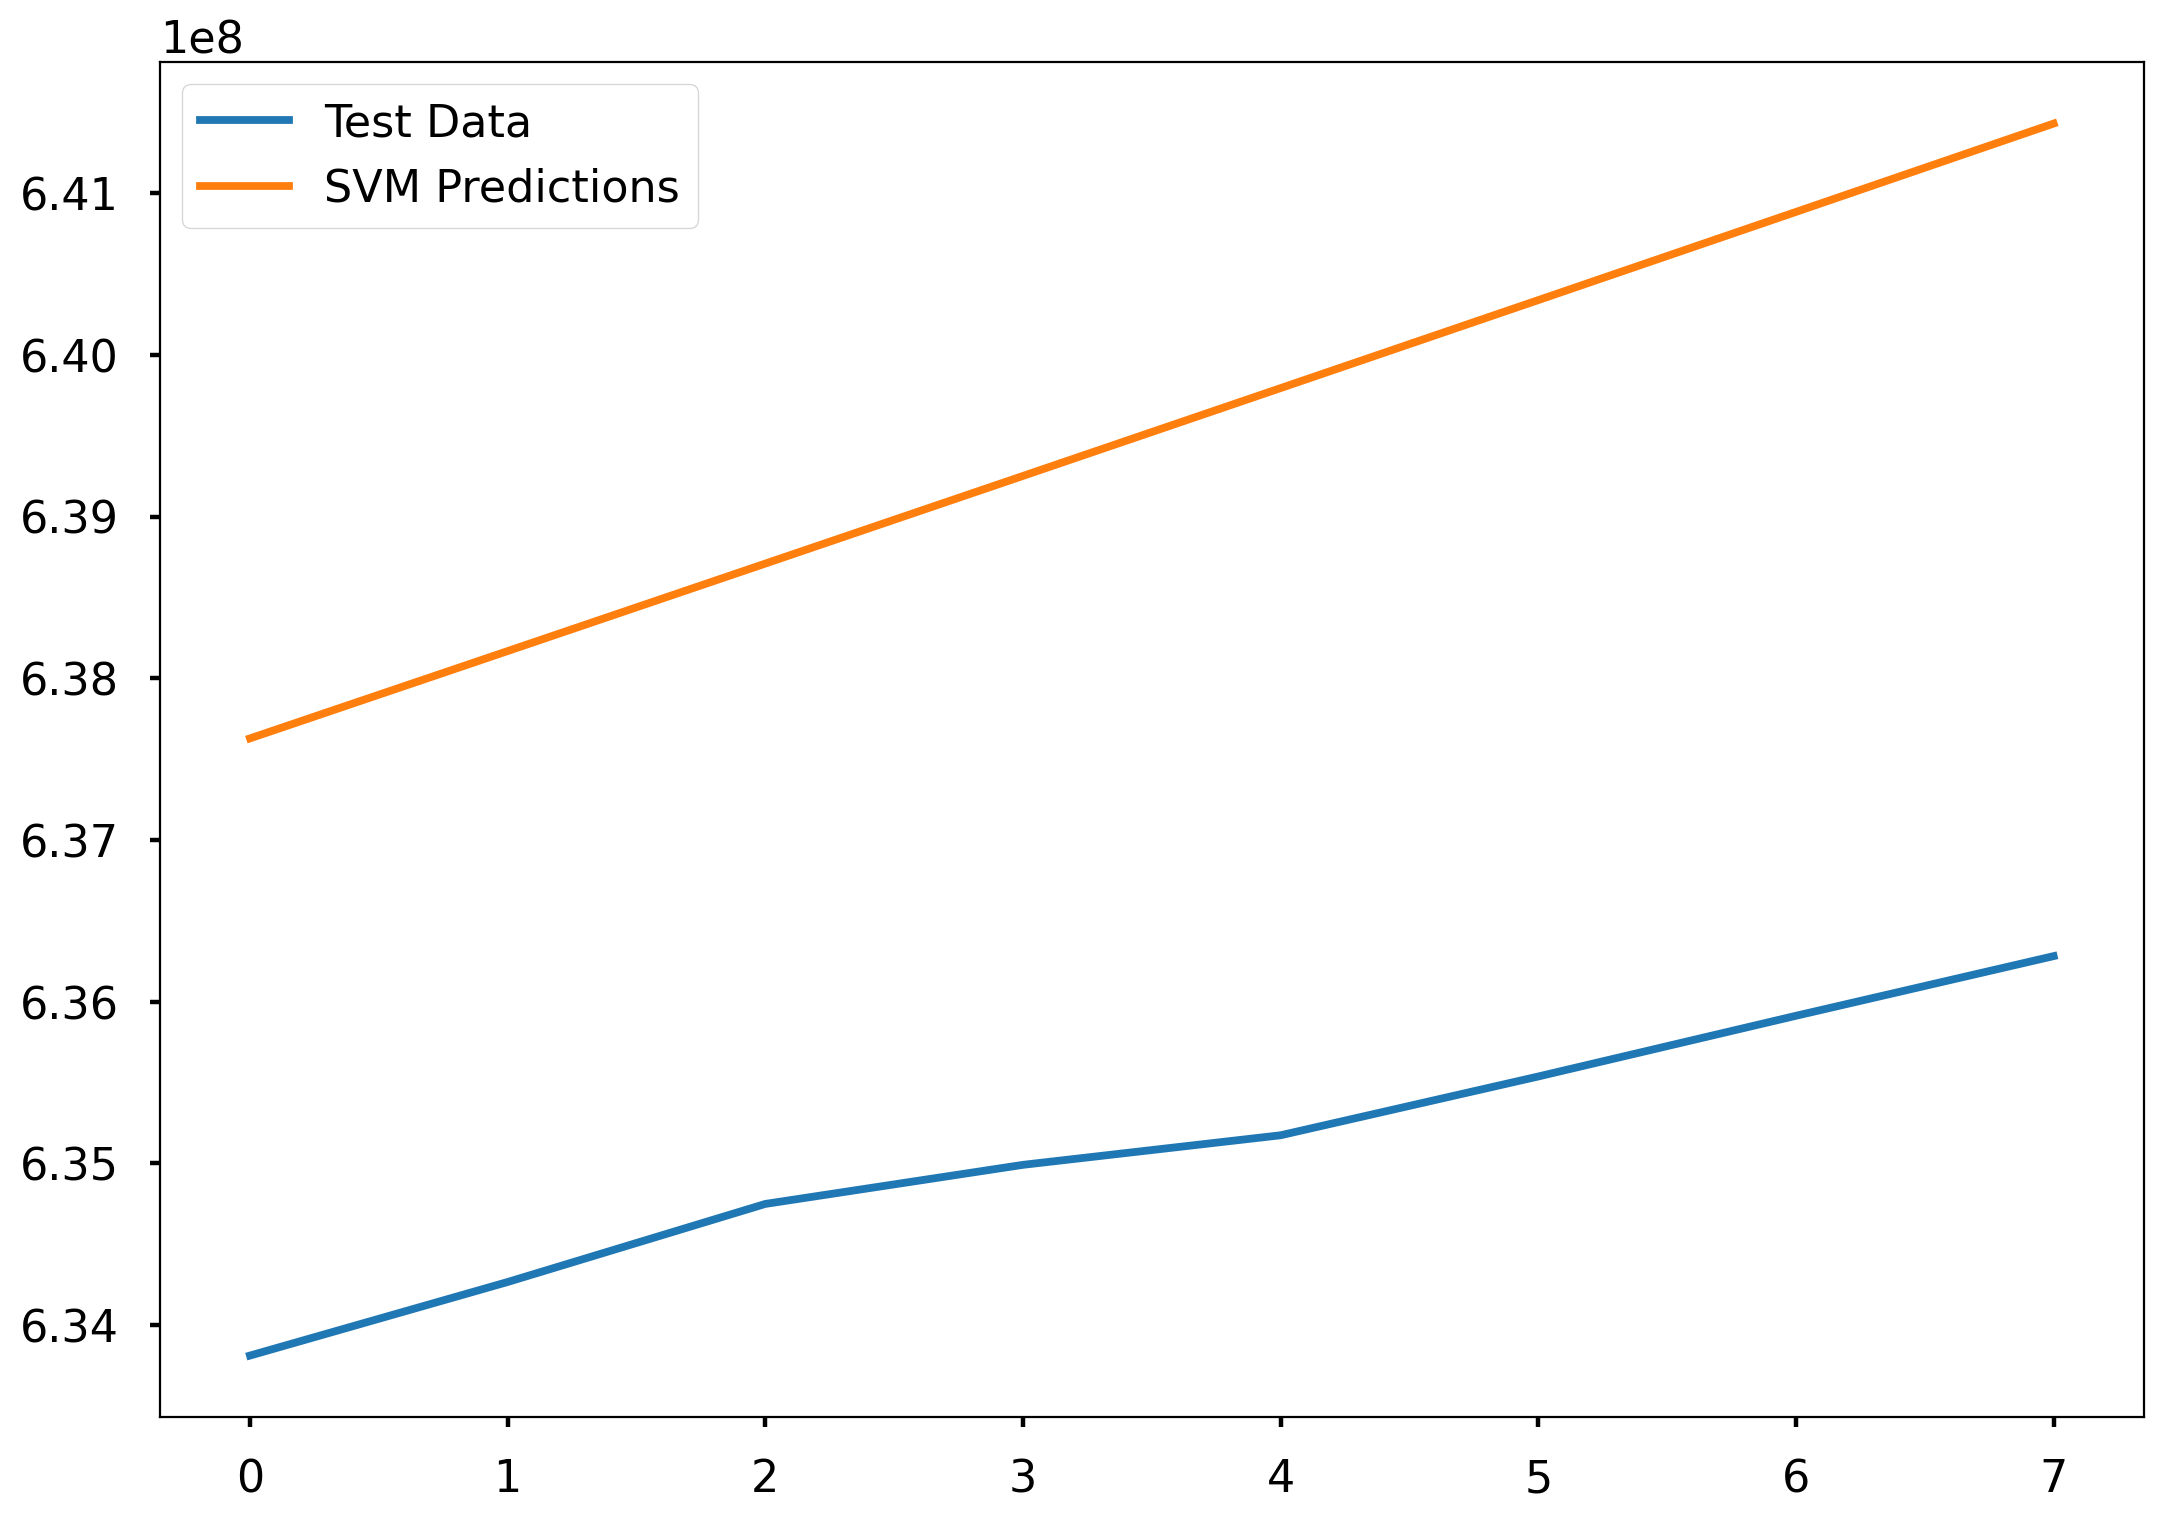

In [54]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred , y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred , y_test_confirmed))

In [55]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=3)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [56]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 1215511.155796051
MSE: 1597368445001.617


In [57]:
print(linear_model.coef_)

[[-3.35394150e+10  1.01909370e+08 -1.01727313e+05  3.39826724e+01]]


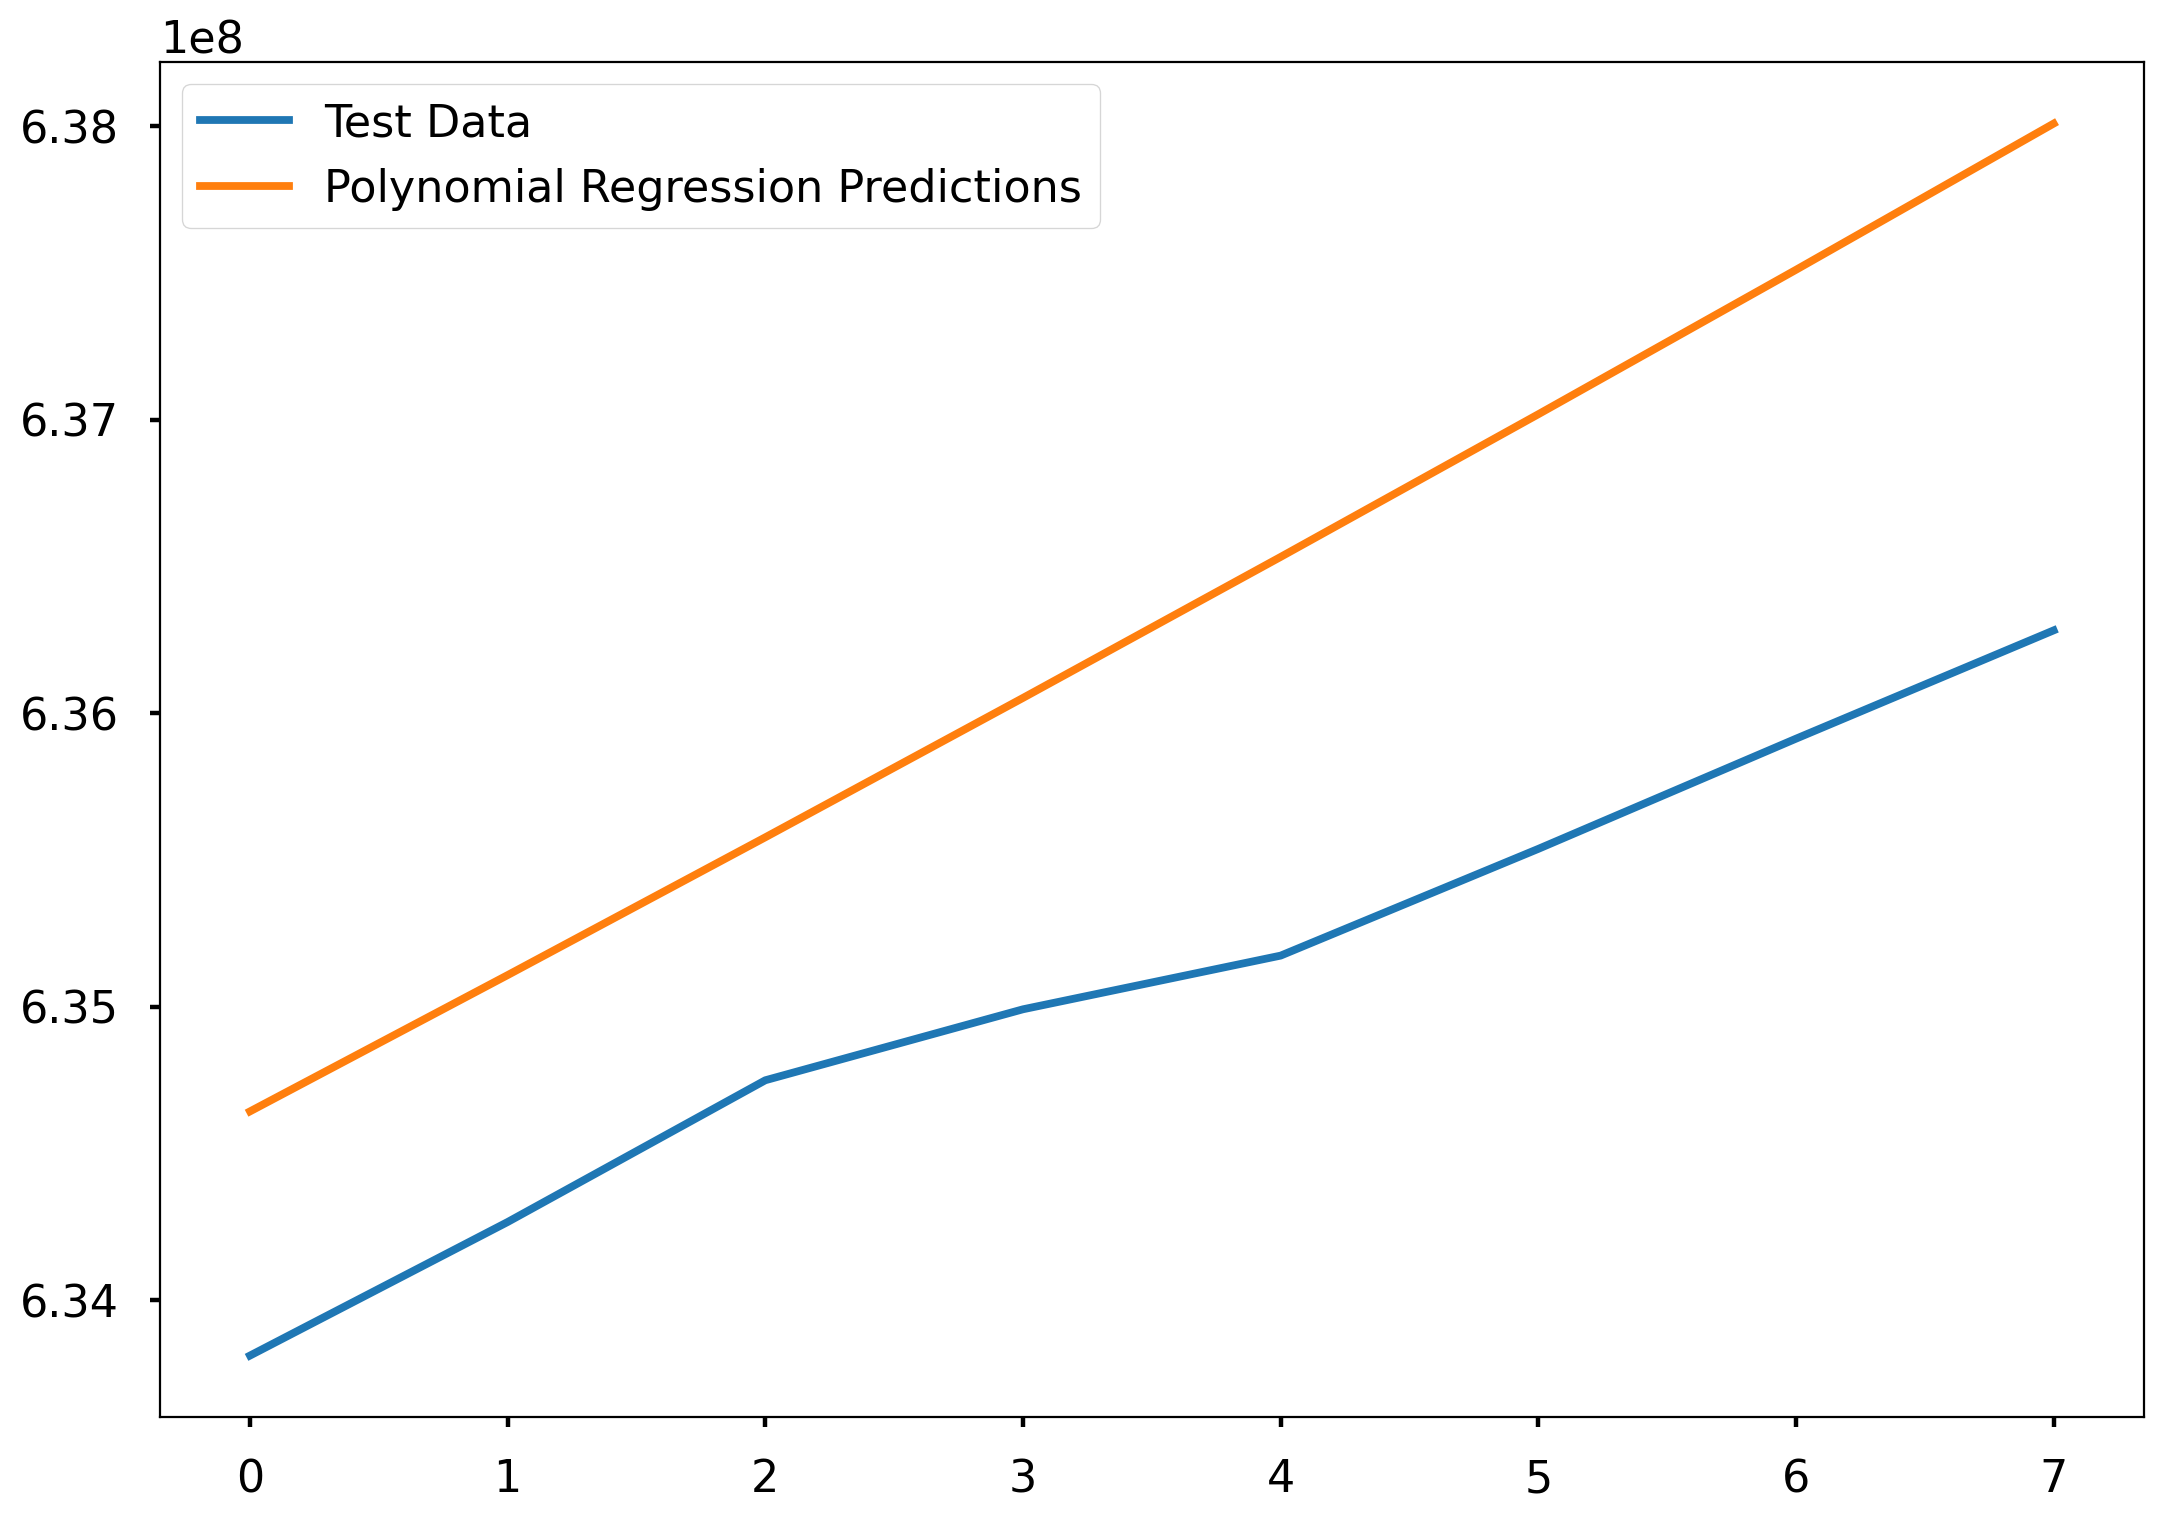

In [58]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [59]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3, estimator=BayesianRidge(fit_intercept=False),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'lambda_2': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'normalize': [True, False],
                                        'tol': [1e-06, 1e-05, 0.0001, 0.001,
                                                0.01]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [60]:
bayesian_search.best_params_

{'tol': 0.01,
 'normalize': False,
 'lambda_2': 0.001,
 'lambda_1': 1e-05,
 'alpha_2': 1e-07,
 'alpha_1': 0.0001}

In [61]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 77563286.69664516
MSE: 6032158675389948.0


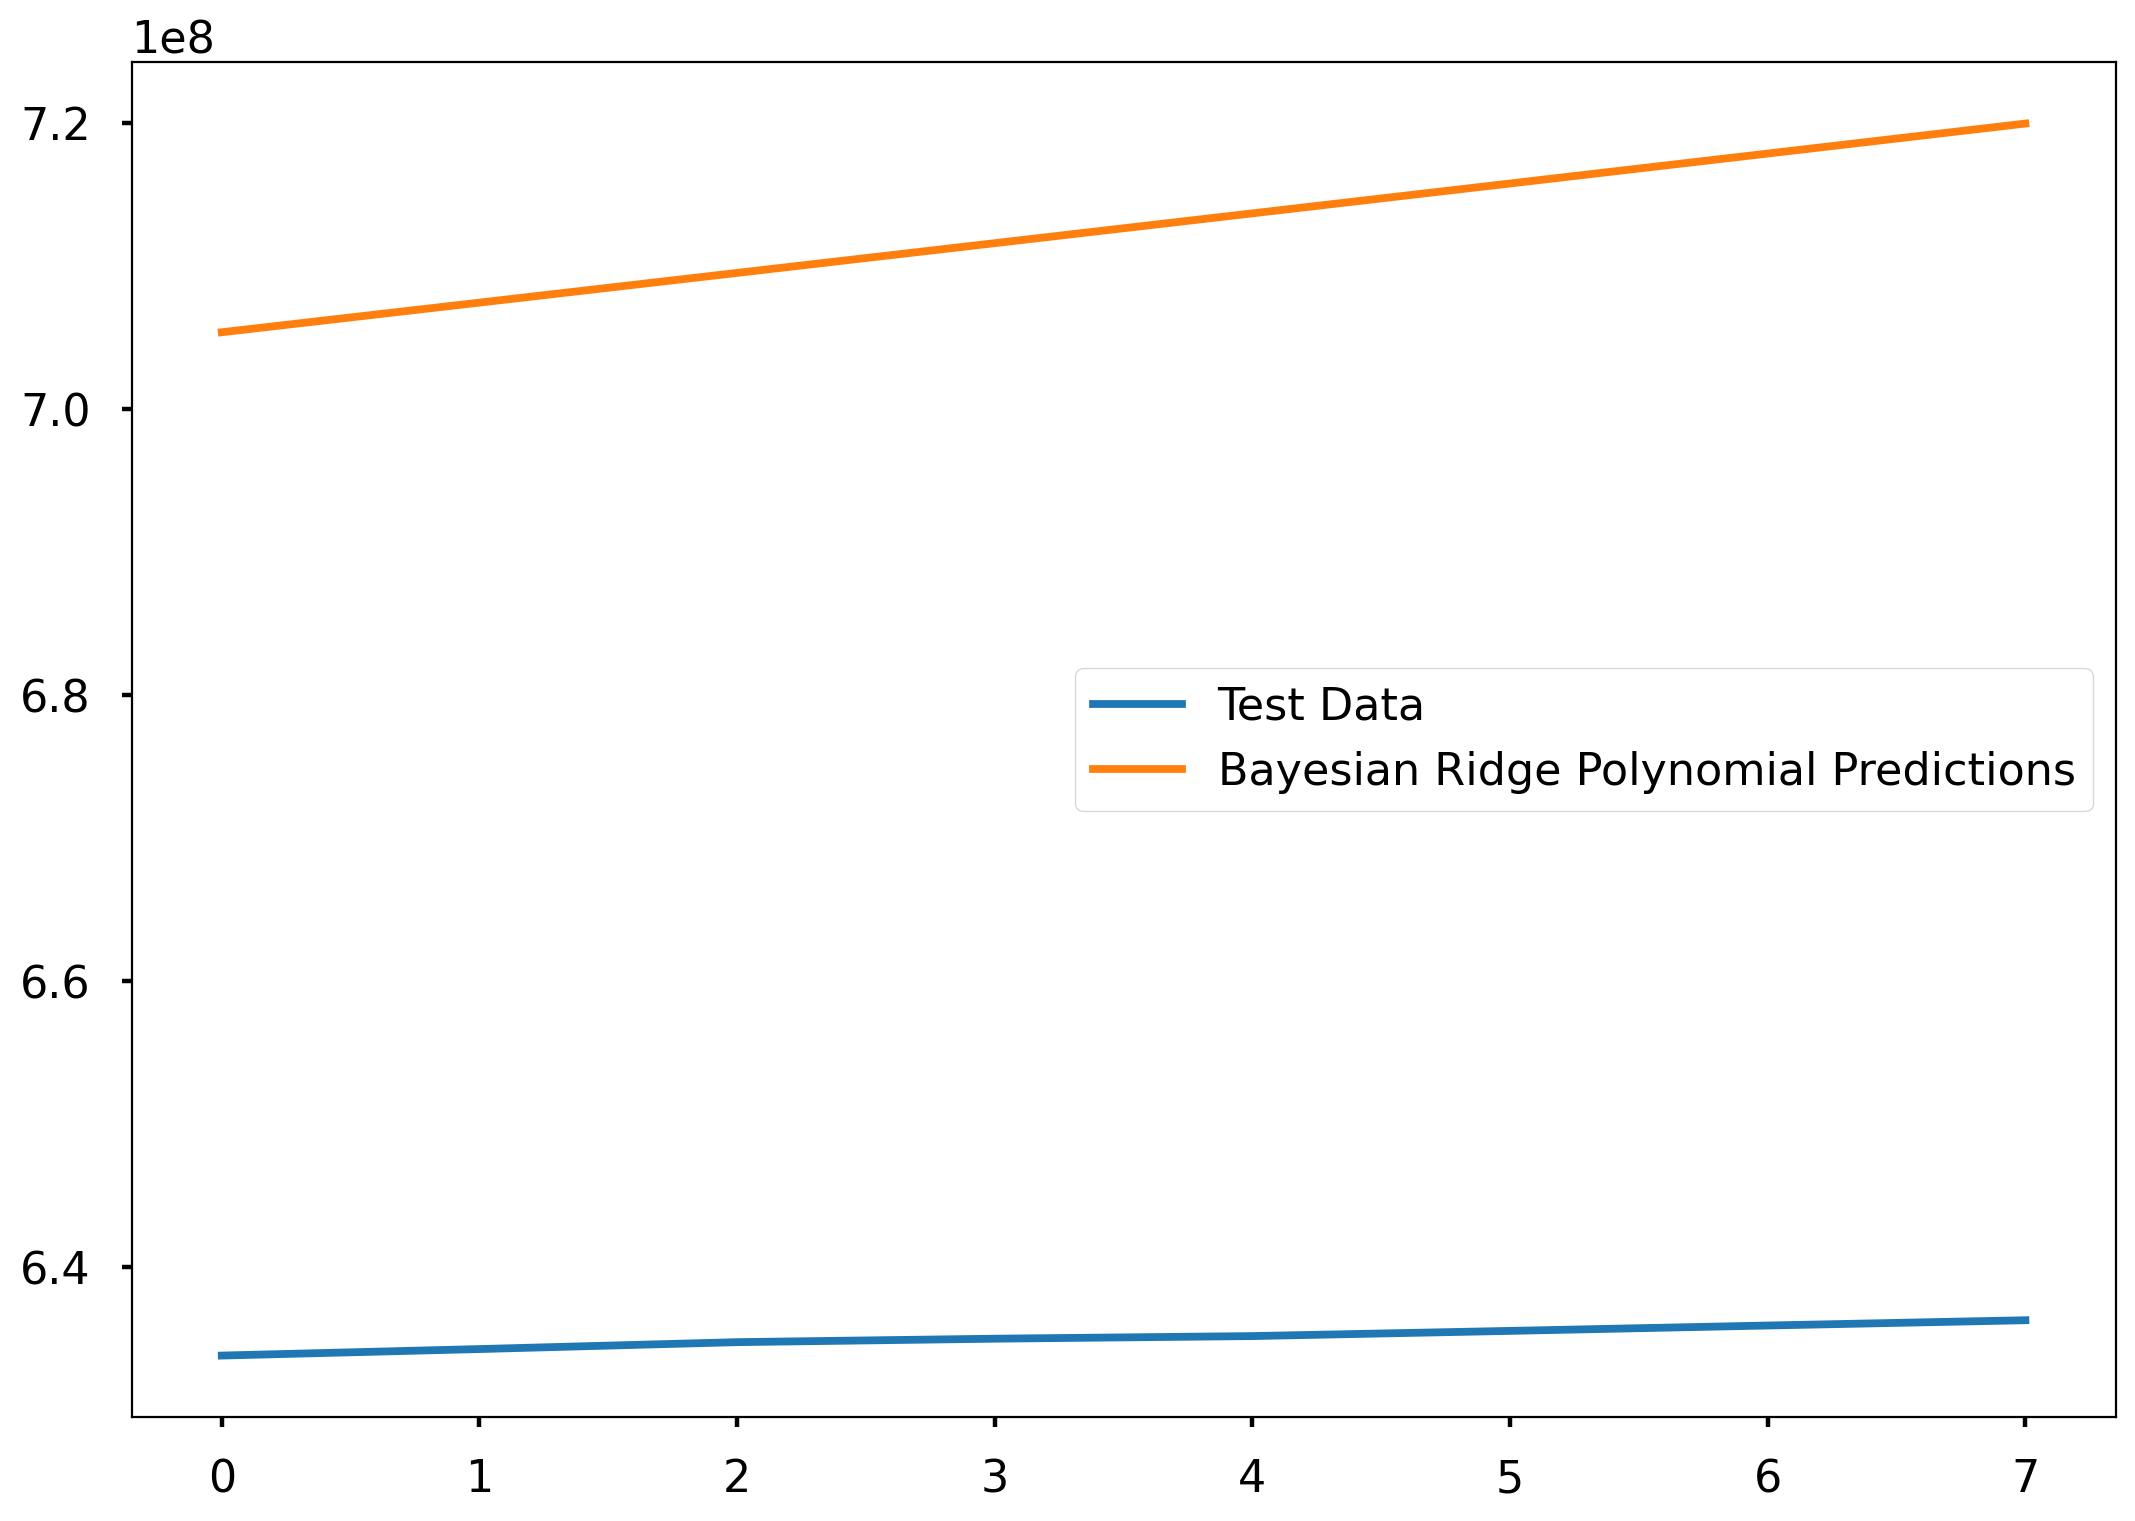

In [62]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

# Worldwide Overview 
Graphing the number of confirmed cases, deaths, and mortality rate (CFR). This gives us a big picture of the ongoing pandemic. 
 <a id='world_wide_graphs'></a>

In [63]:
# helper method for flattening the data, so it can be displayed on a bar graph 
def flatten(arr):
    a = [] 
    arr = arr.tolist()
    for i in arr:
        a.append(i[0])
    return a

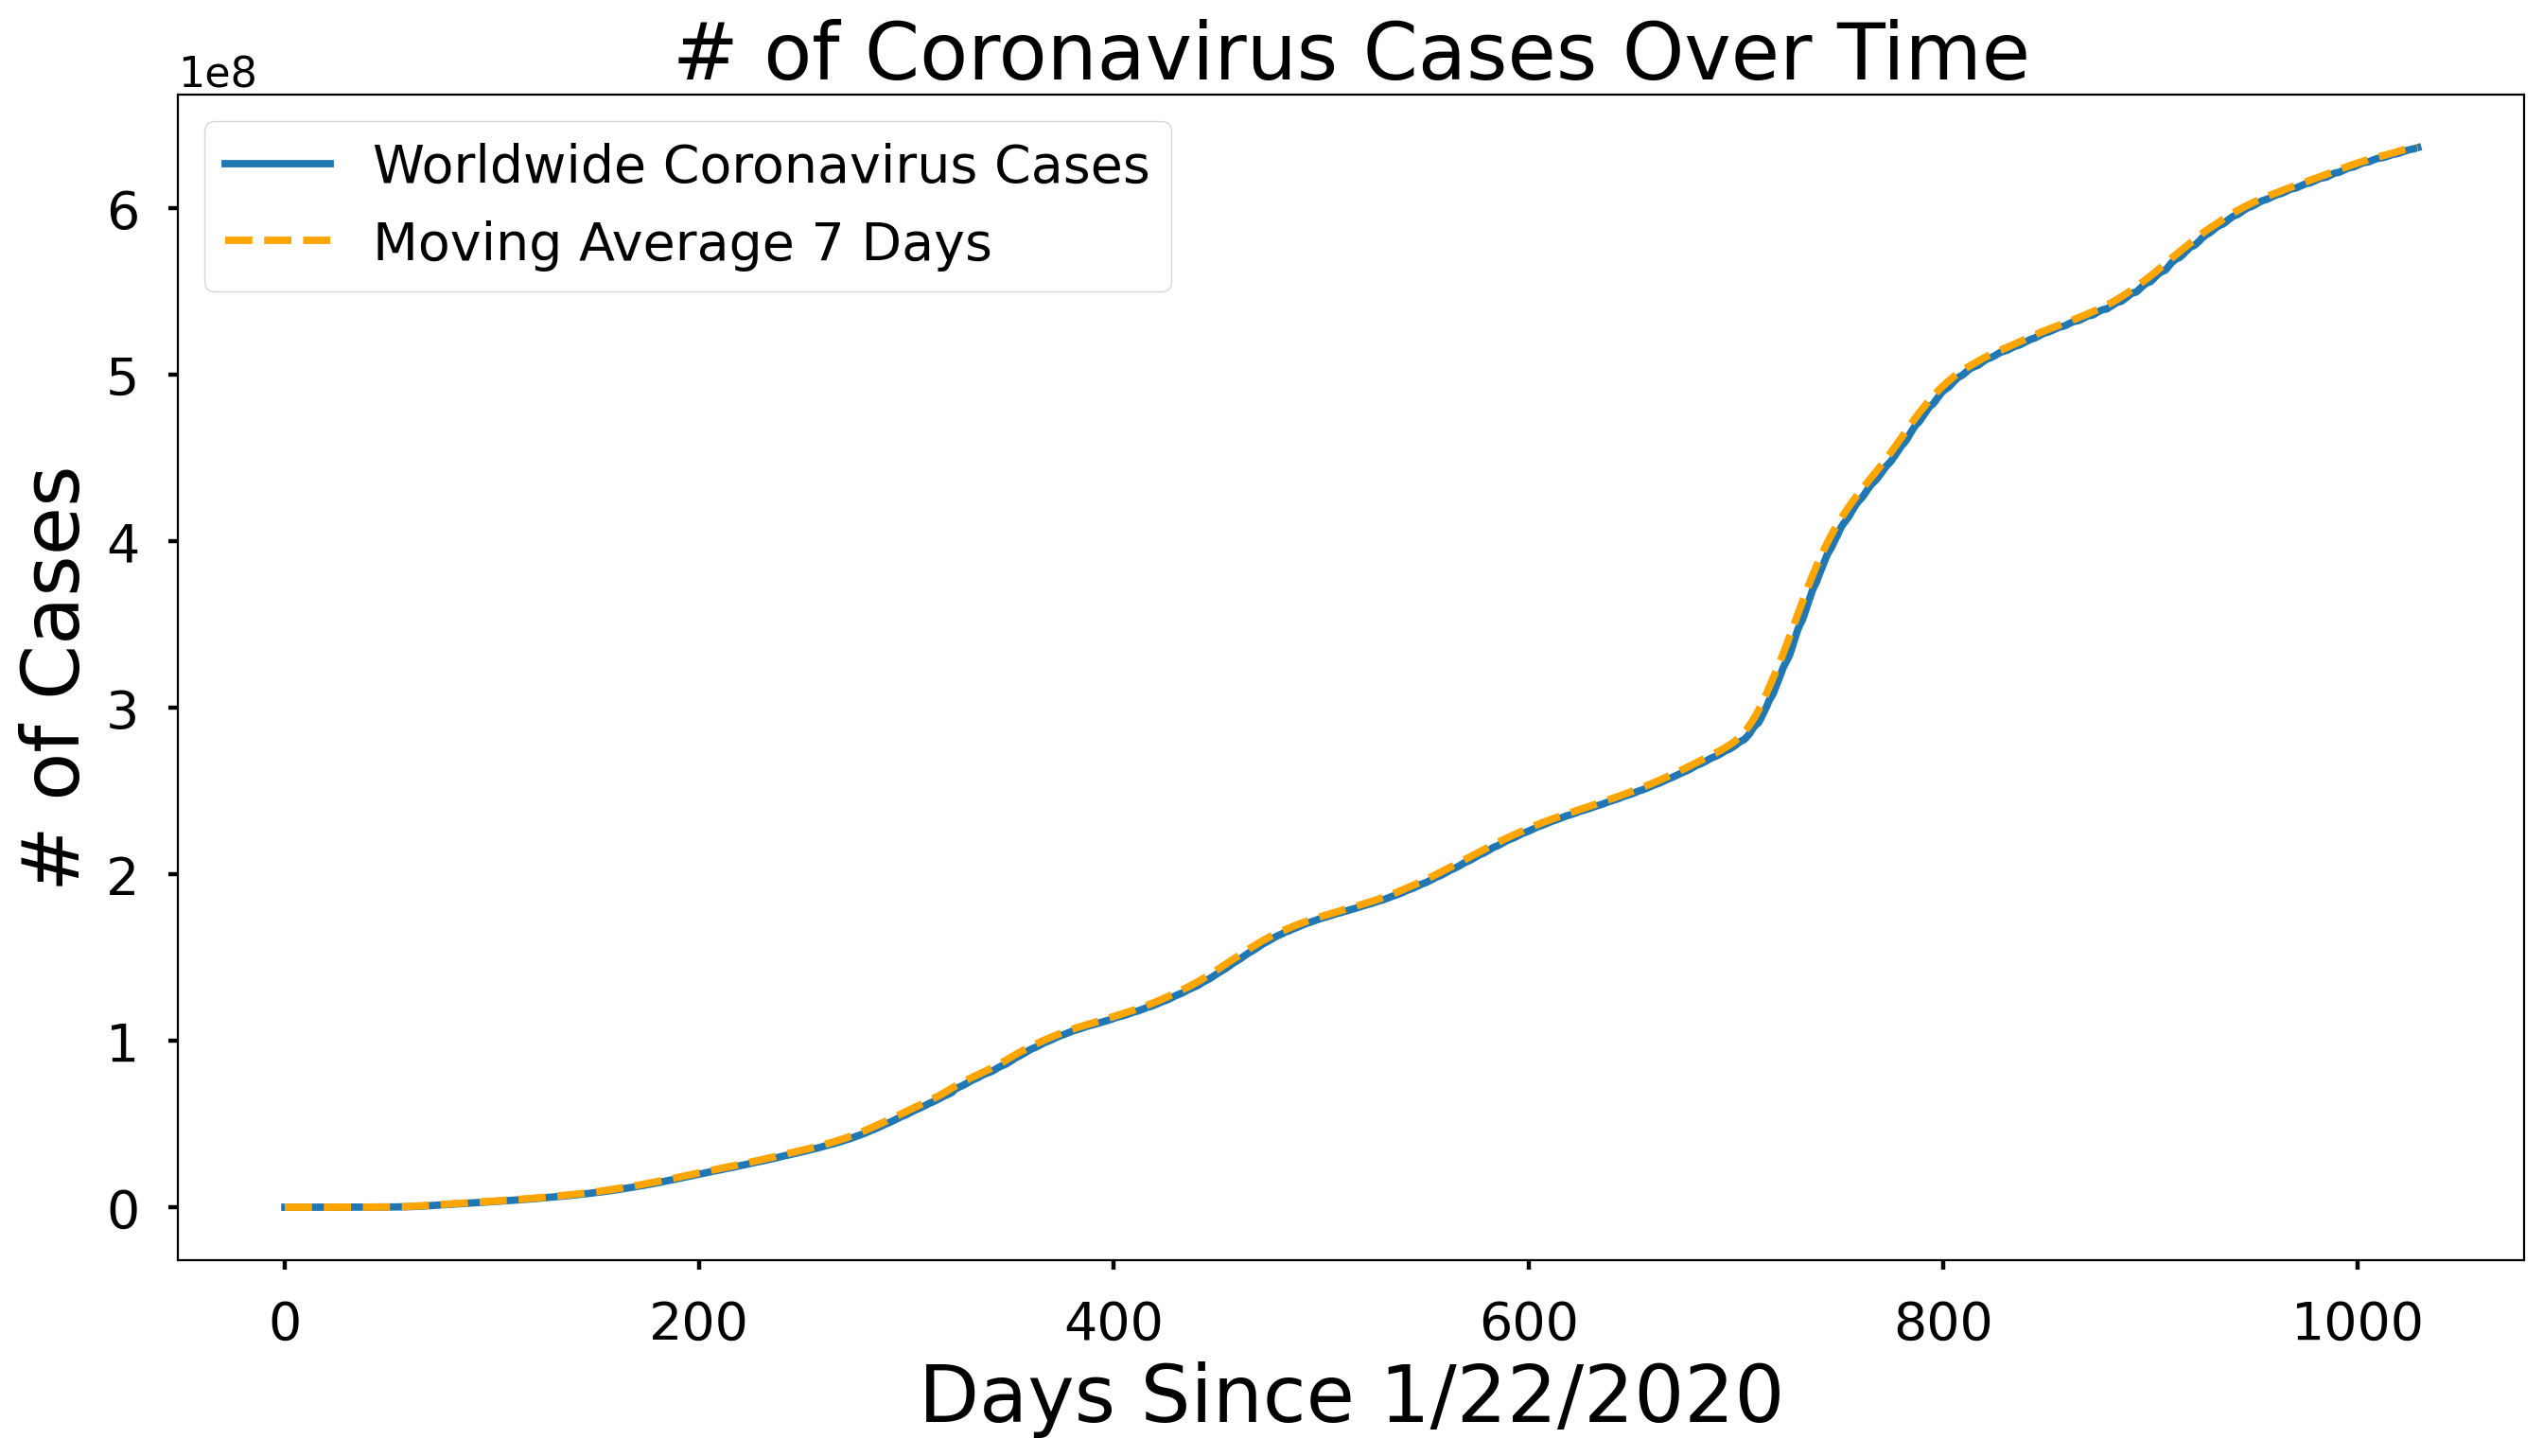

In [64]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 8))
plt.plot(adjusted_dates, world_cases)
plt.plot(adjusted_dates, world_confirmed_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Cases', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

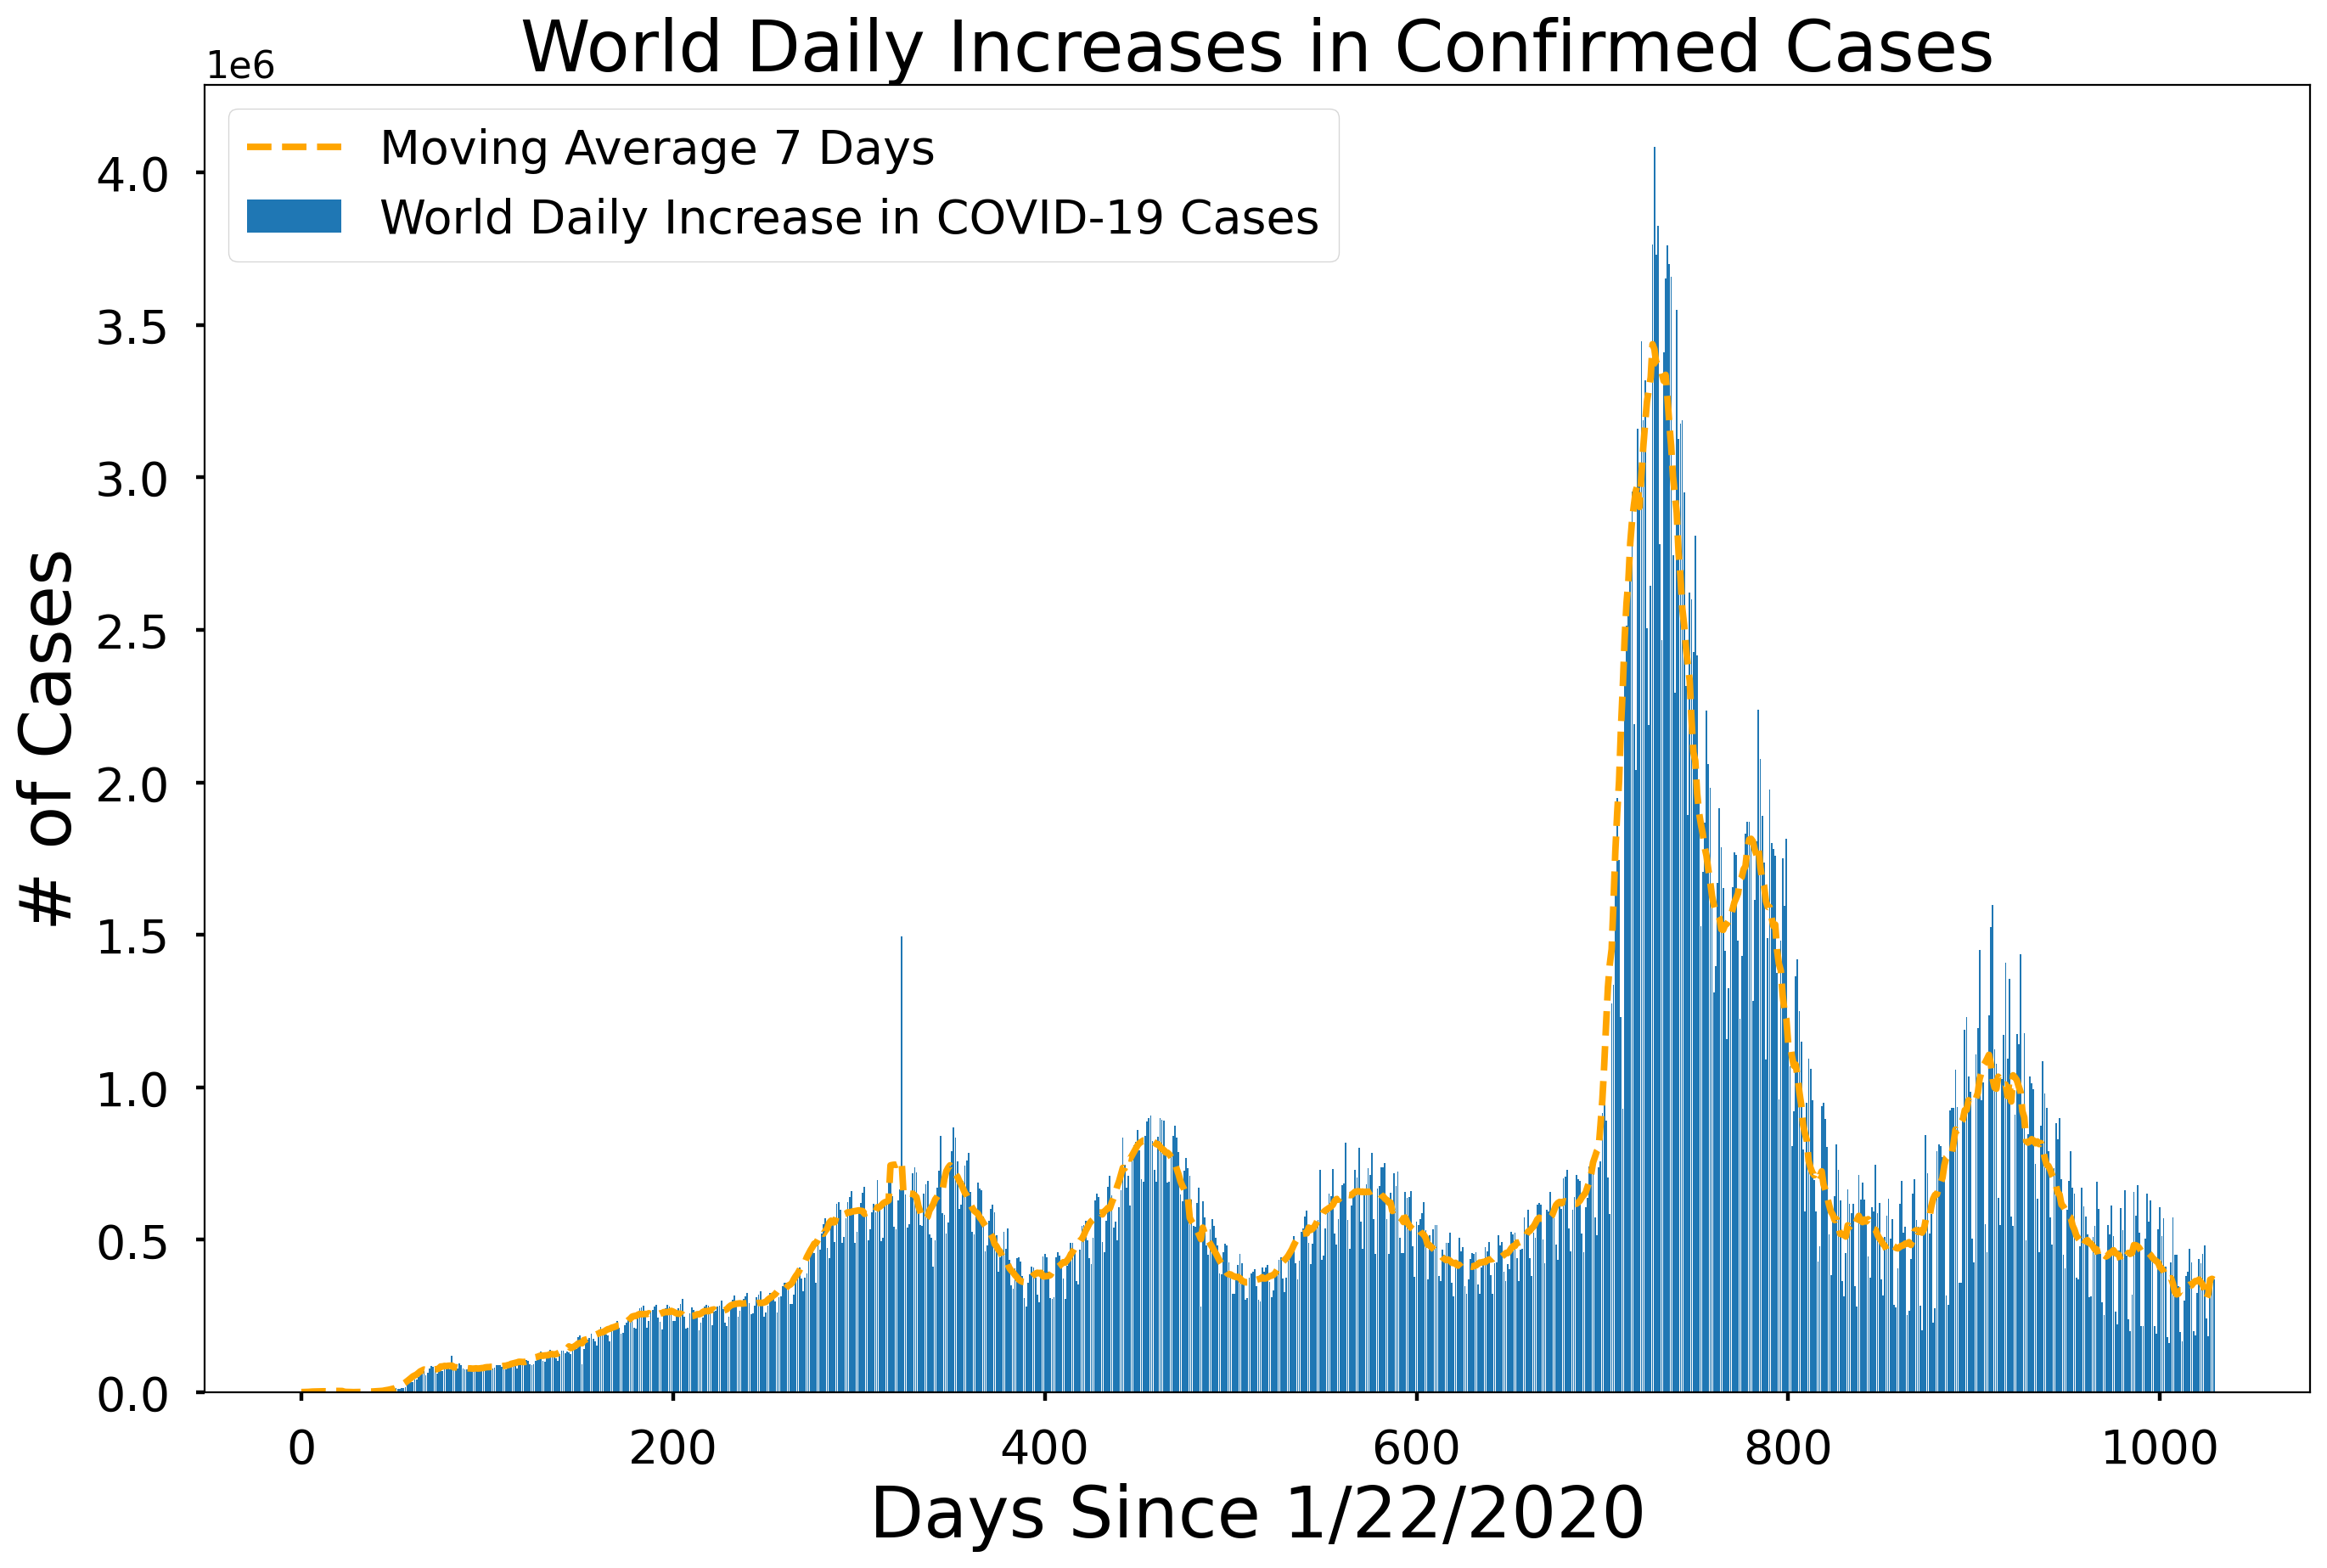

In [65]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_increase)
plt.plot(adjusted_dates, world_daily_increase_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

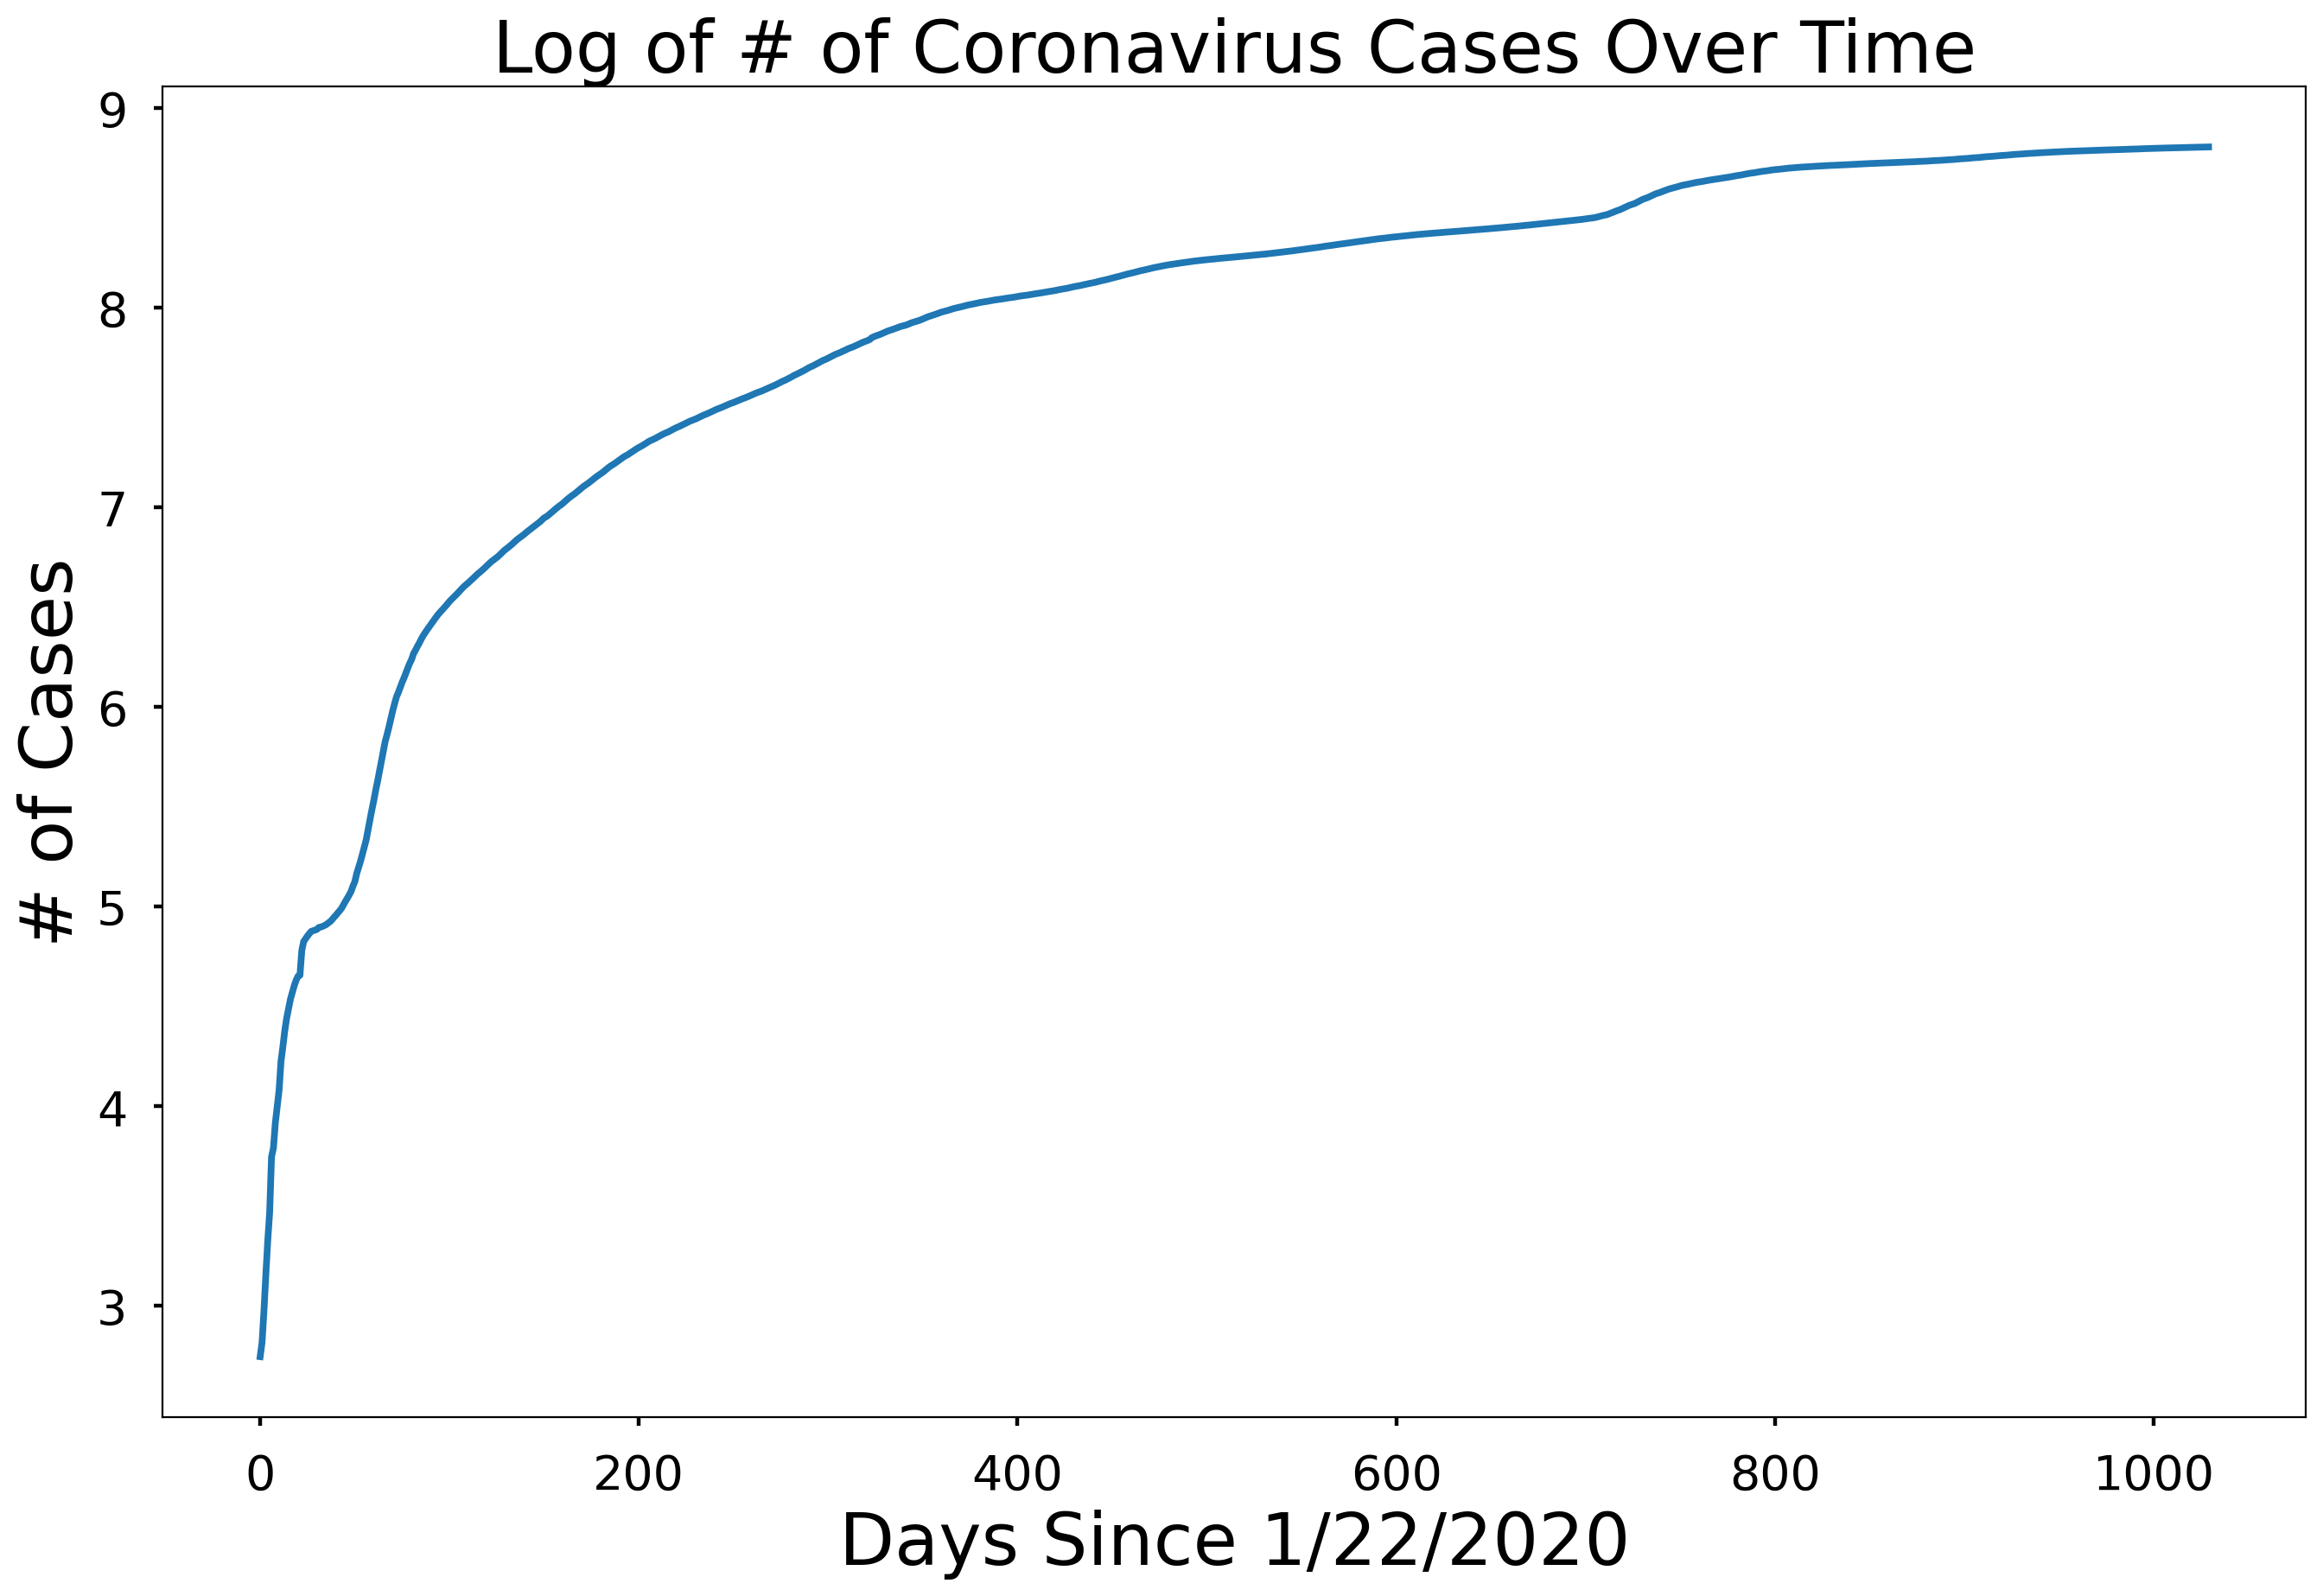

In [66]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [67]:
def country_plot(x, y1, y2, country):
    # window is set as 14 in in the beginning of the notebook 
    confirmed_avg = moving_average(y1, window)
    confirmed_increase_avg = moving_average(y2, window)
    SIZE = (12, 8)
    
    plt.figure(figsize=SIZE)
    plt.plot(x, y1)
    plt.plot(x, confirmed_avg, color='red', linestyle='dashed')
    plt.legend(['{} Confirmed Cases'.format(country), 'Moving Average {} Days'.format(window)], prop={'size': 20})
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=SIZE)
    plt.bar(x, y2)
    plt.plot(x, confirmed_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Cases'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()


# helper function for getting a country's total covid cases and deaths    
def get_country_info(country_name):
    country_cases = []
    
    for i in range(num_dates):
        country_cases.append(confirmed_df[confirmed_df['Country/Region']==country_name][ck[i]].sum())
    return (country_cases)
    
    
def country_visualizations(country_name):
    country_cases = get_country_info(country_name)
    
    country_daily_increase = daily_increase(country_cases)
    
    country_plot(adjusted_dates, country_cases, country_daily_increase, country_name)
    

# Country Specific Graphs
Unlike the previous section, we are taking a look at specific countries. This allows us to examine covid at a more localized level. Feel free to change/edit this list to visulize the countries of your choice. 
<a id='country_graphs'></a>

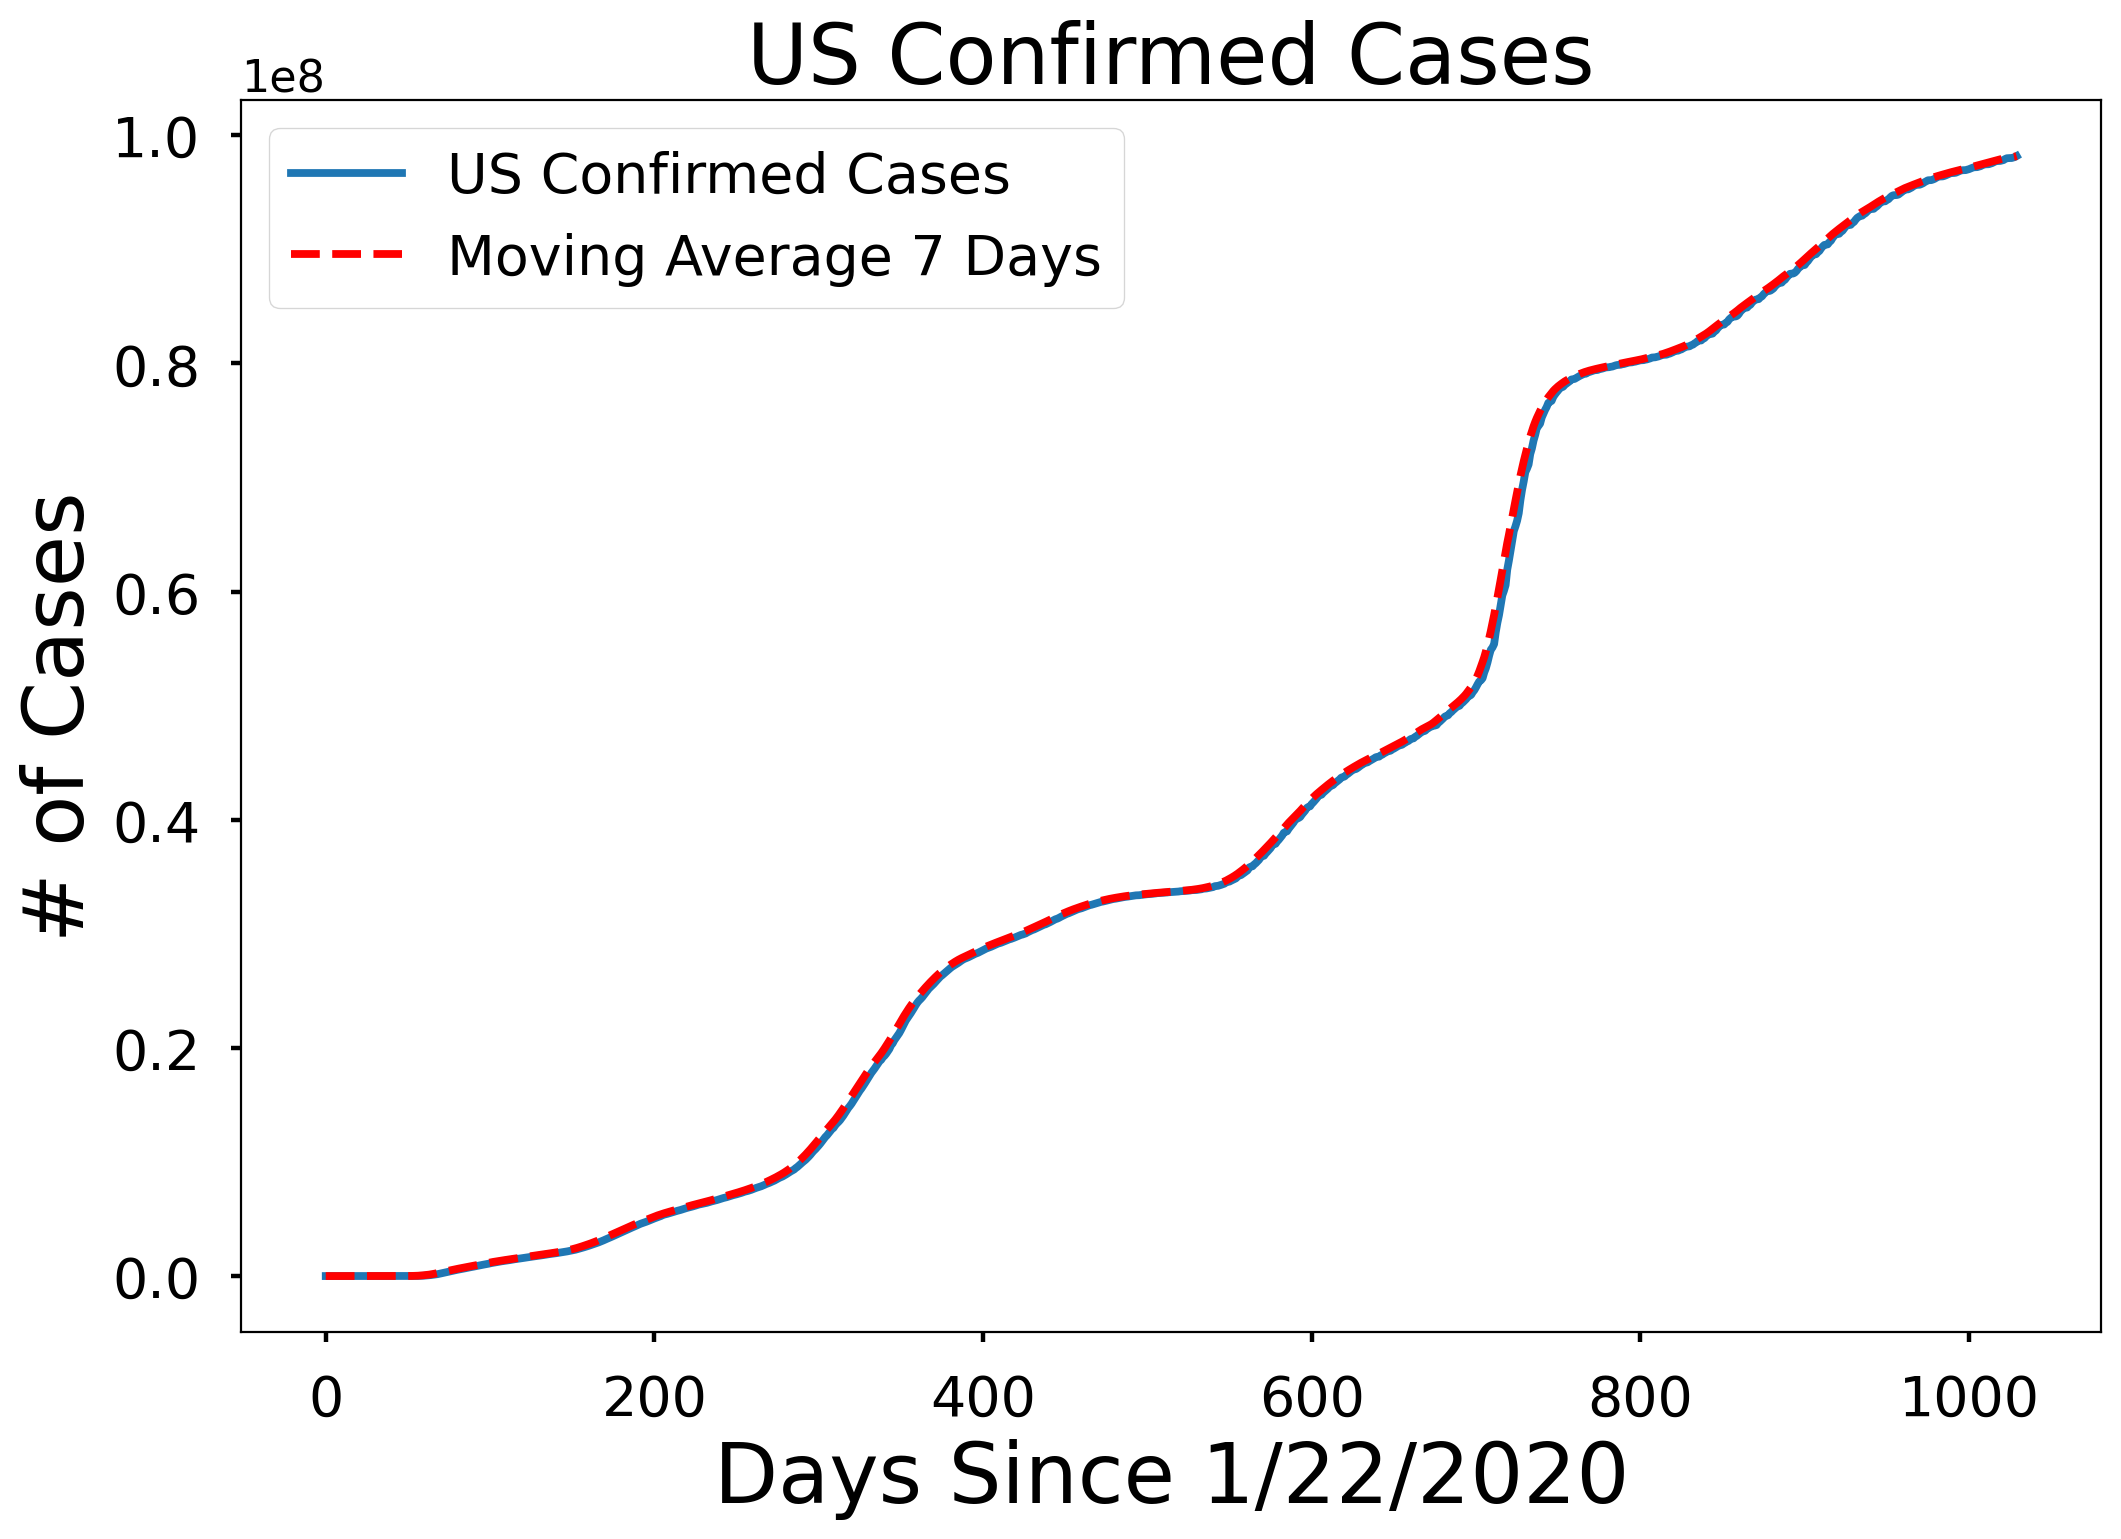

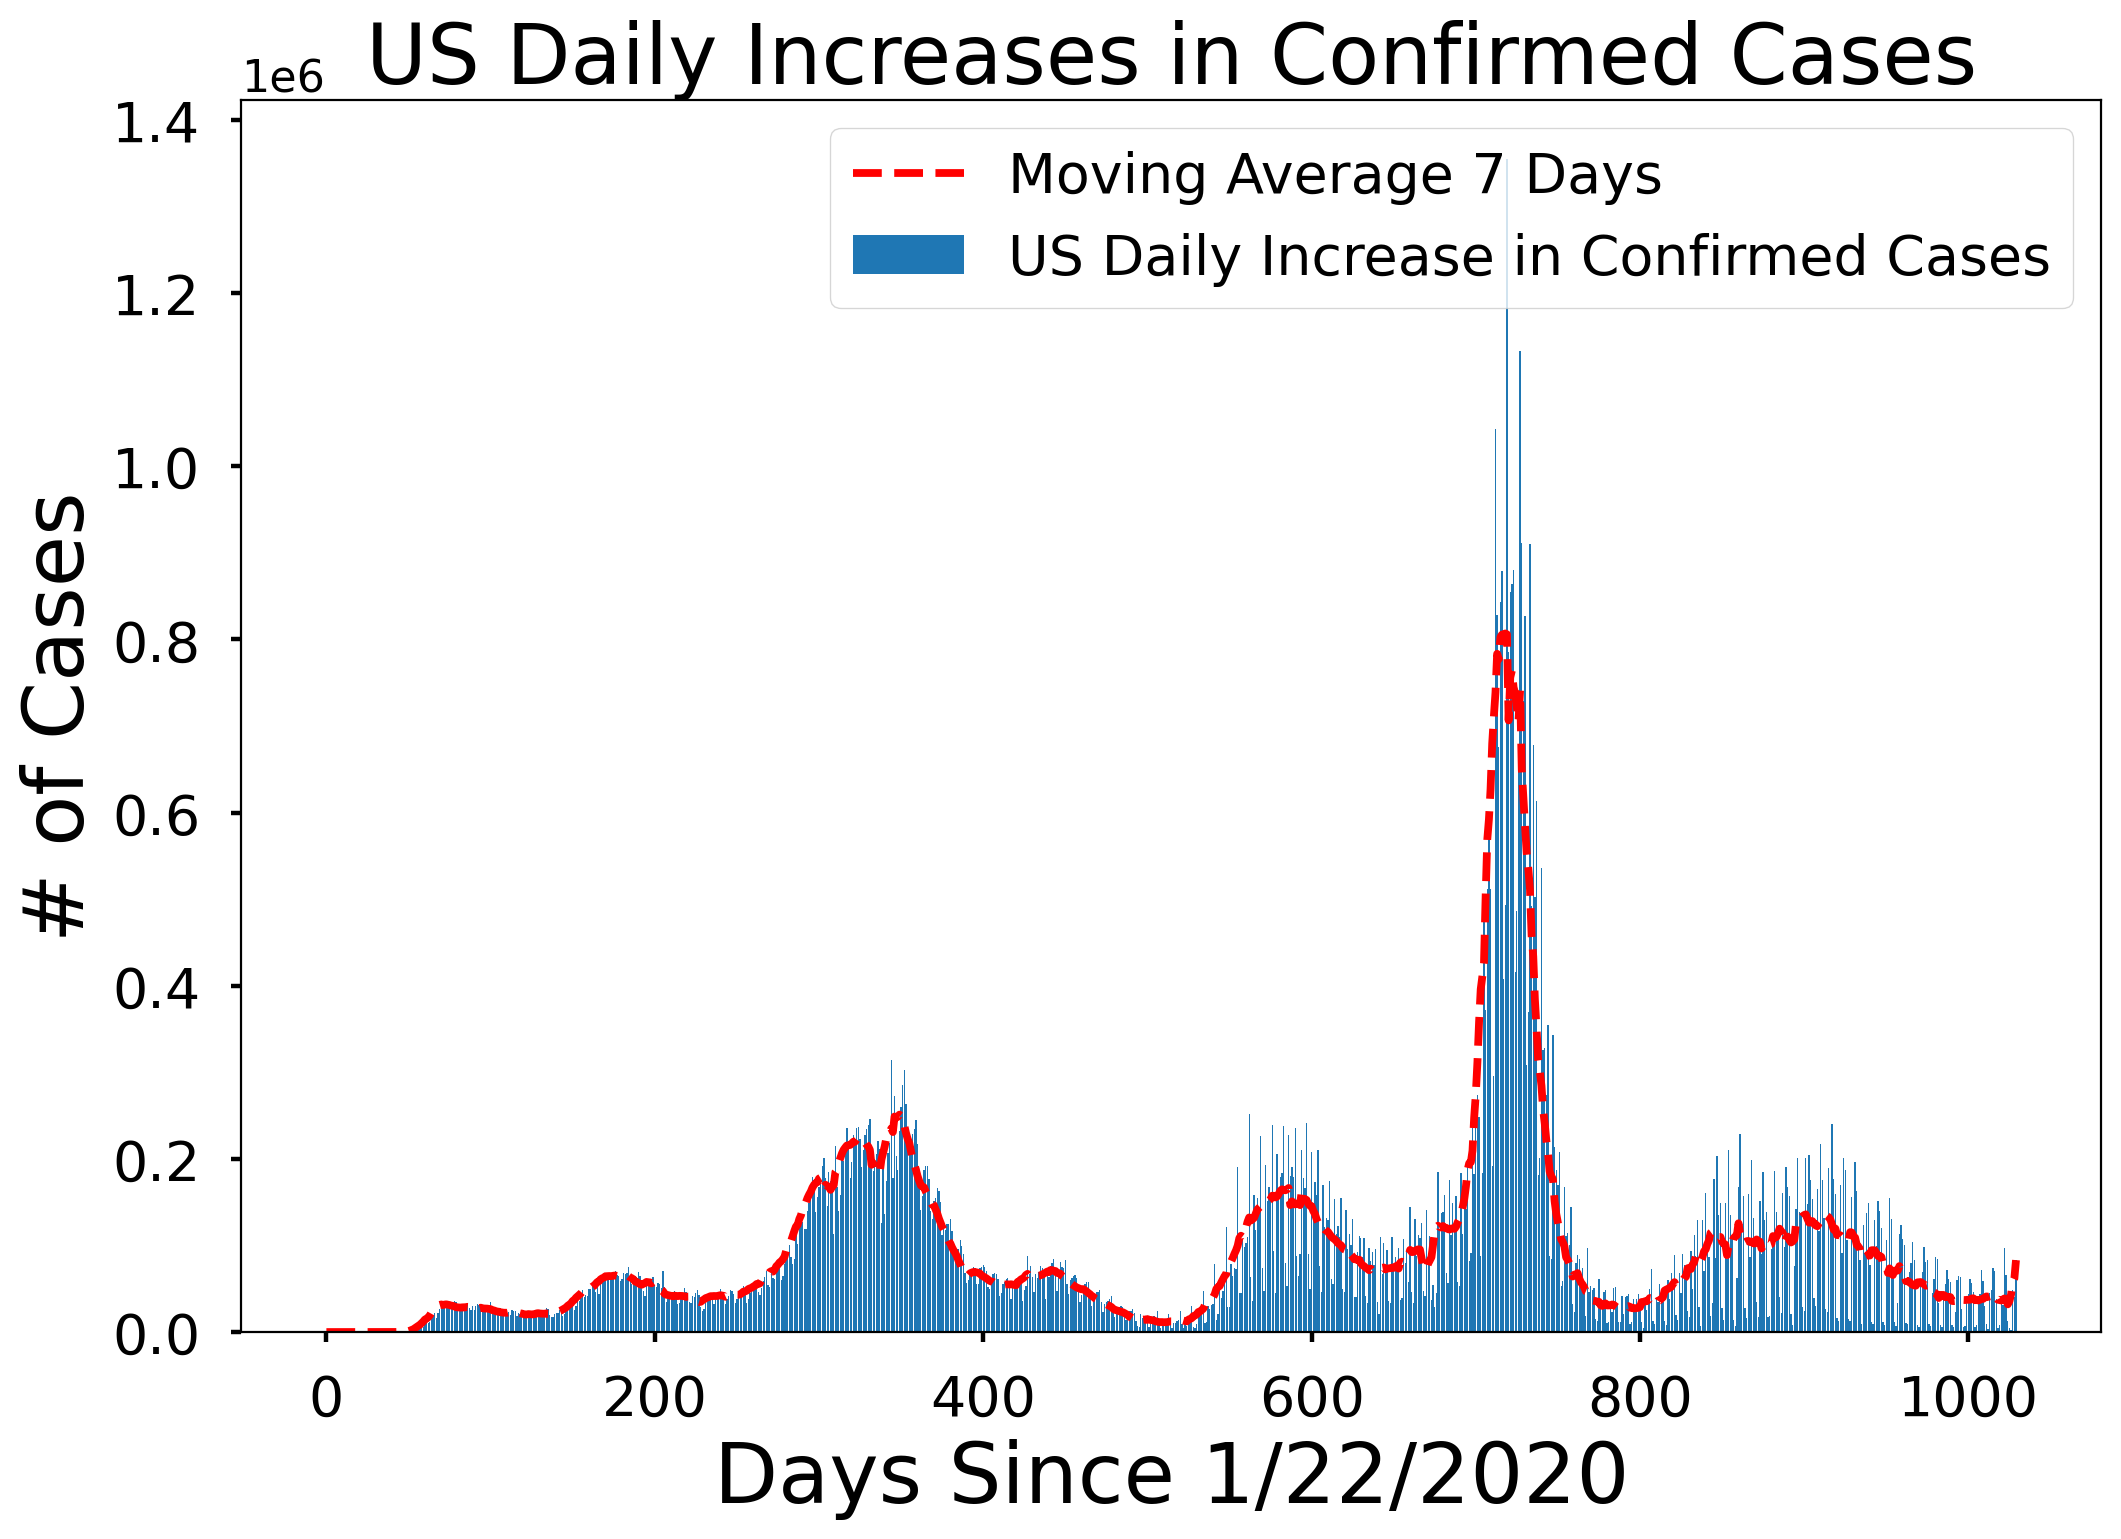

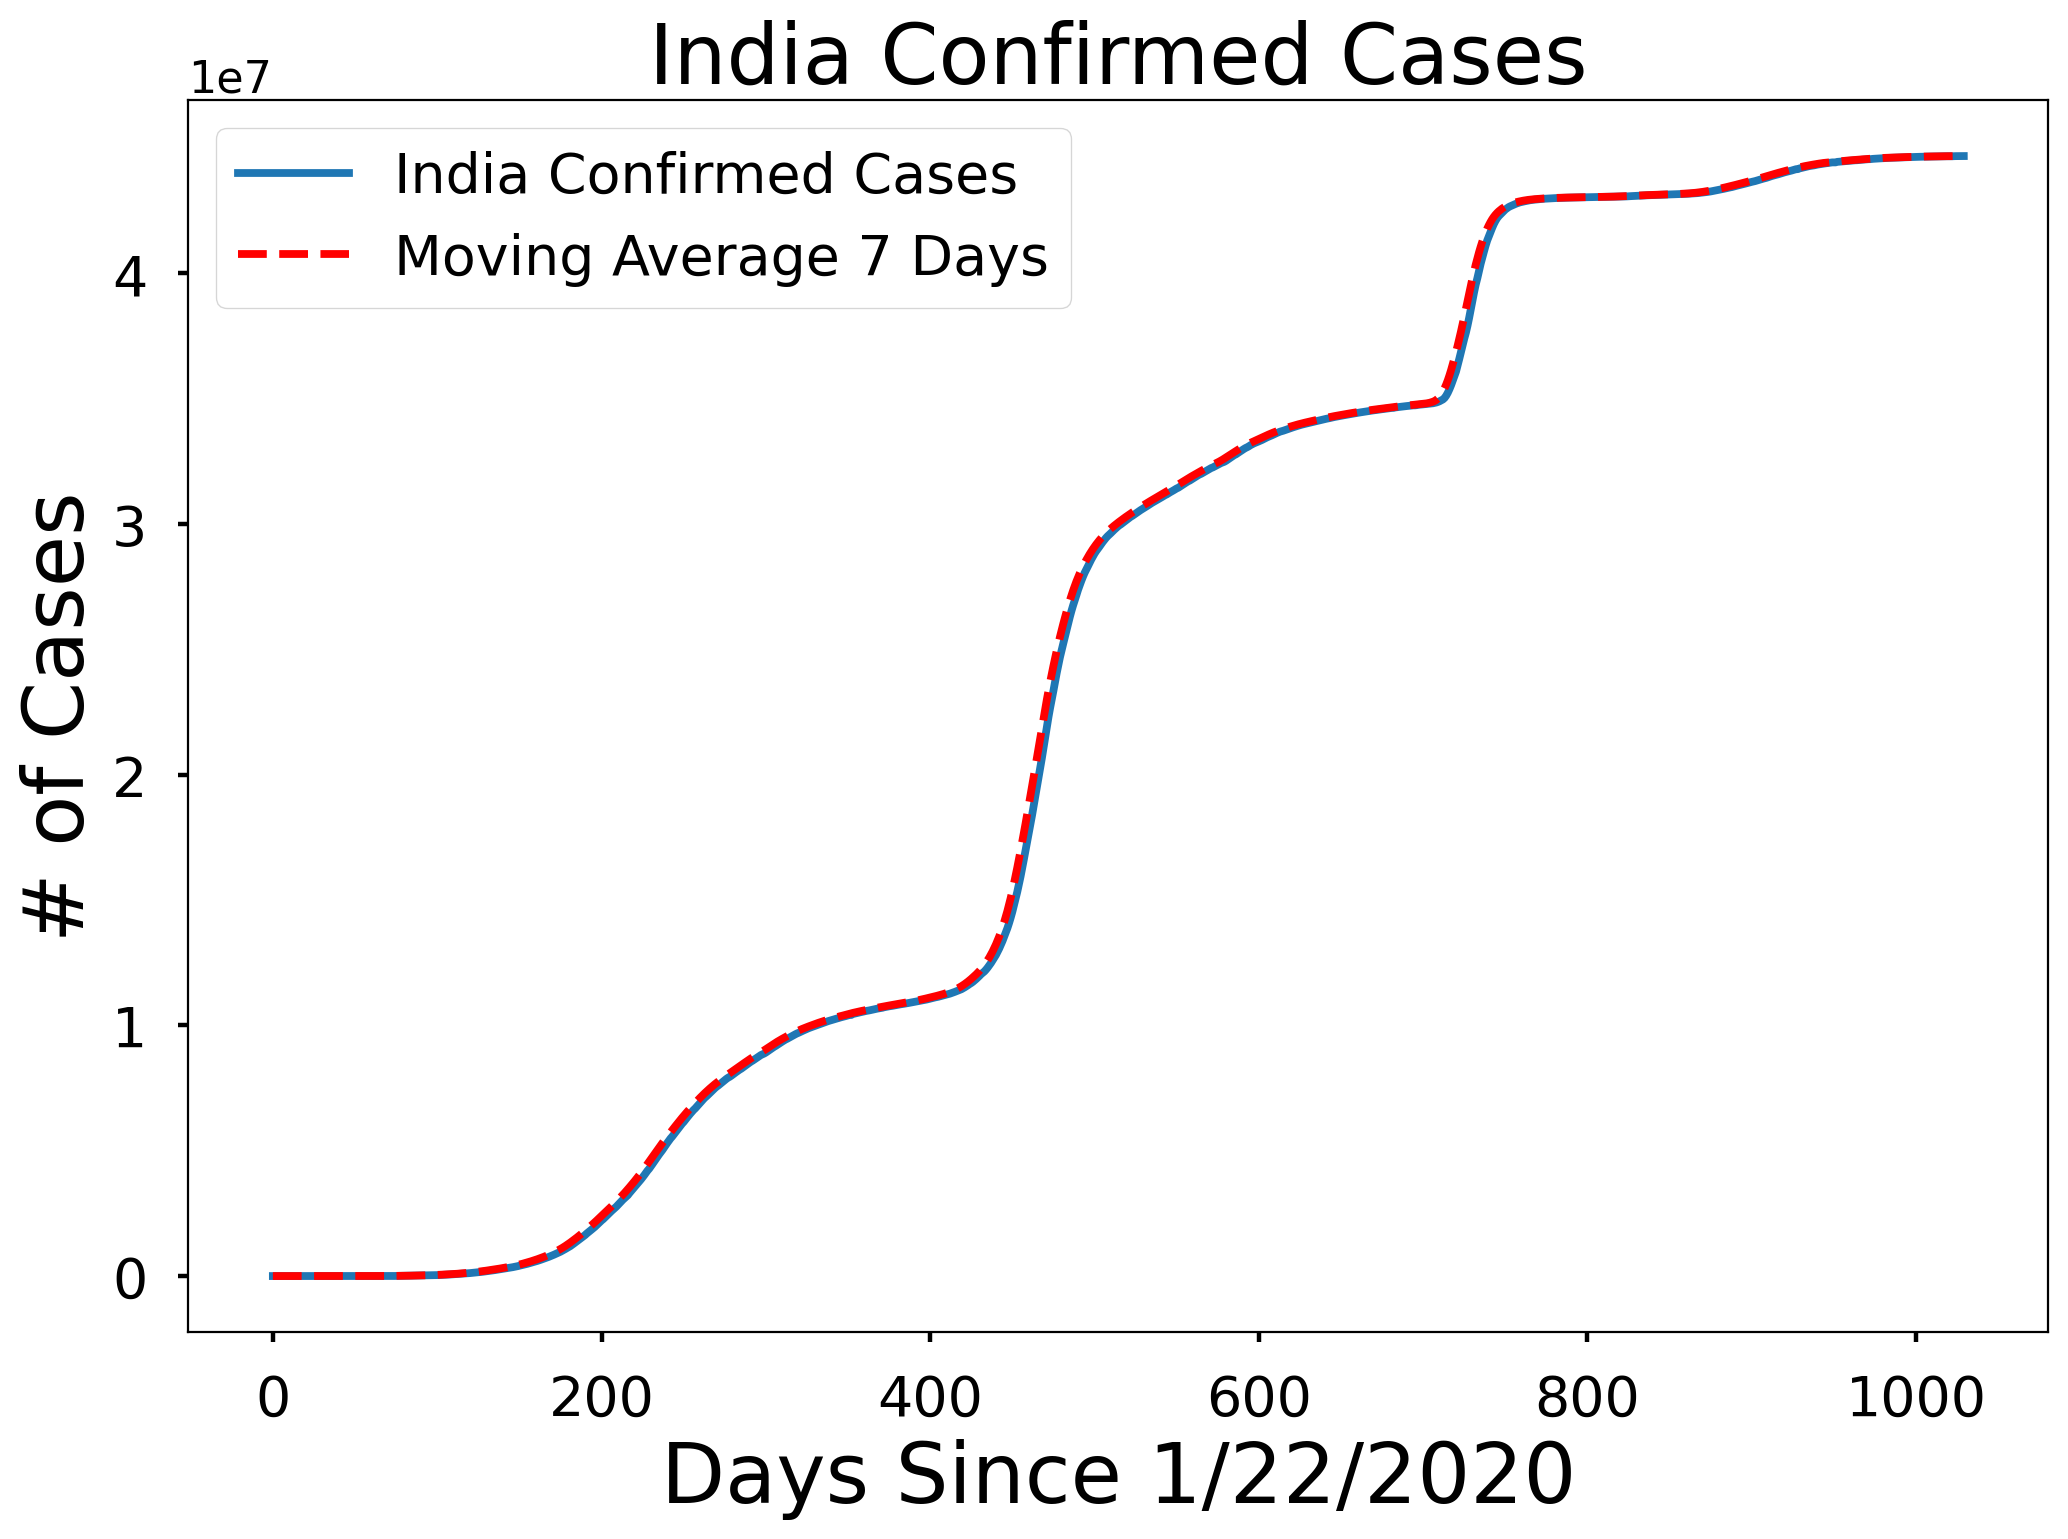

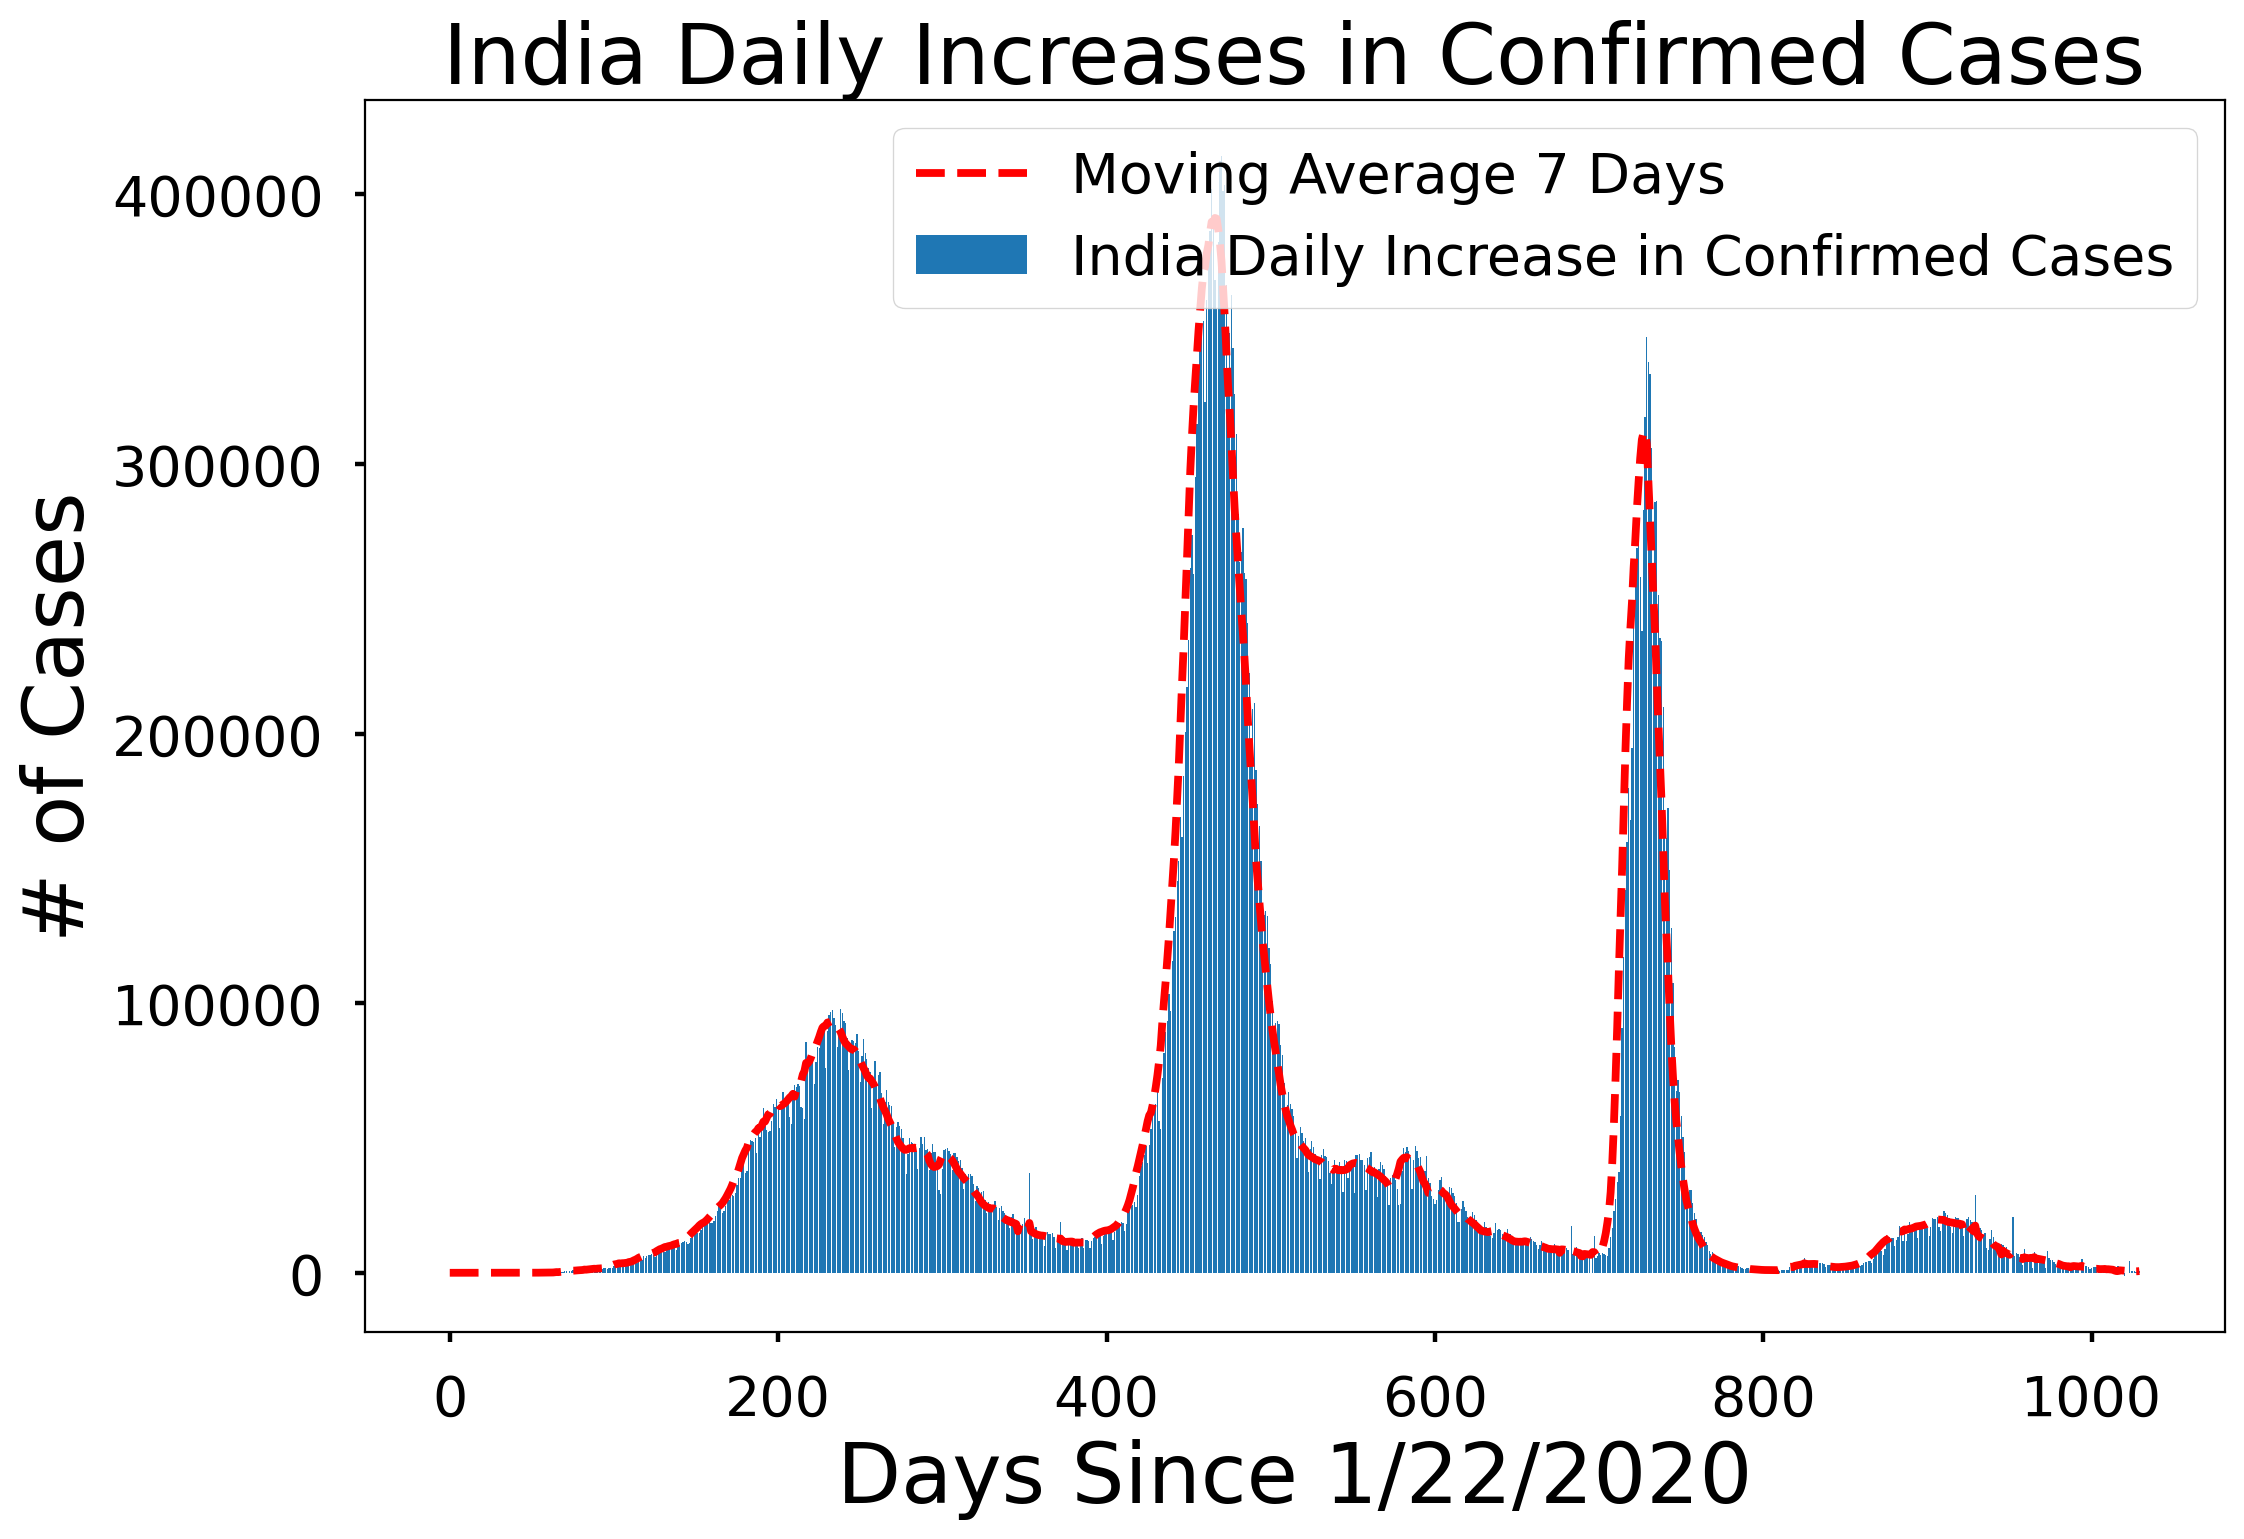

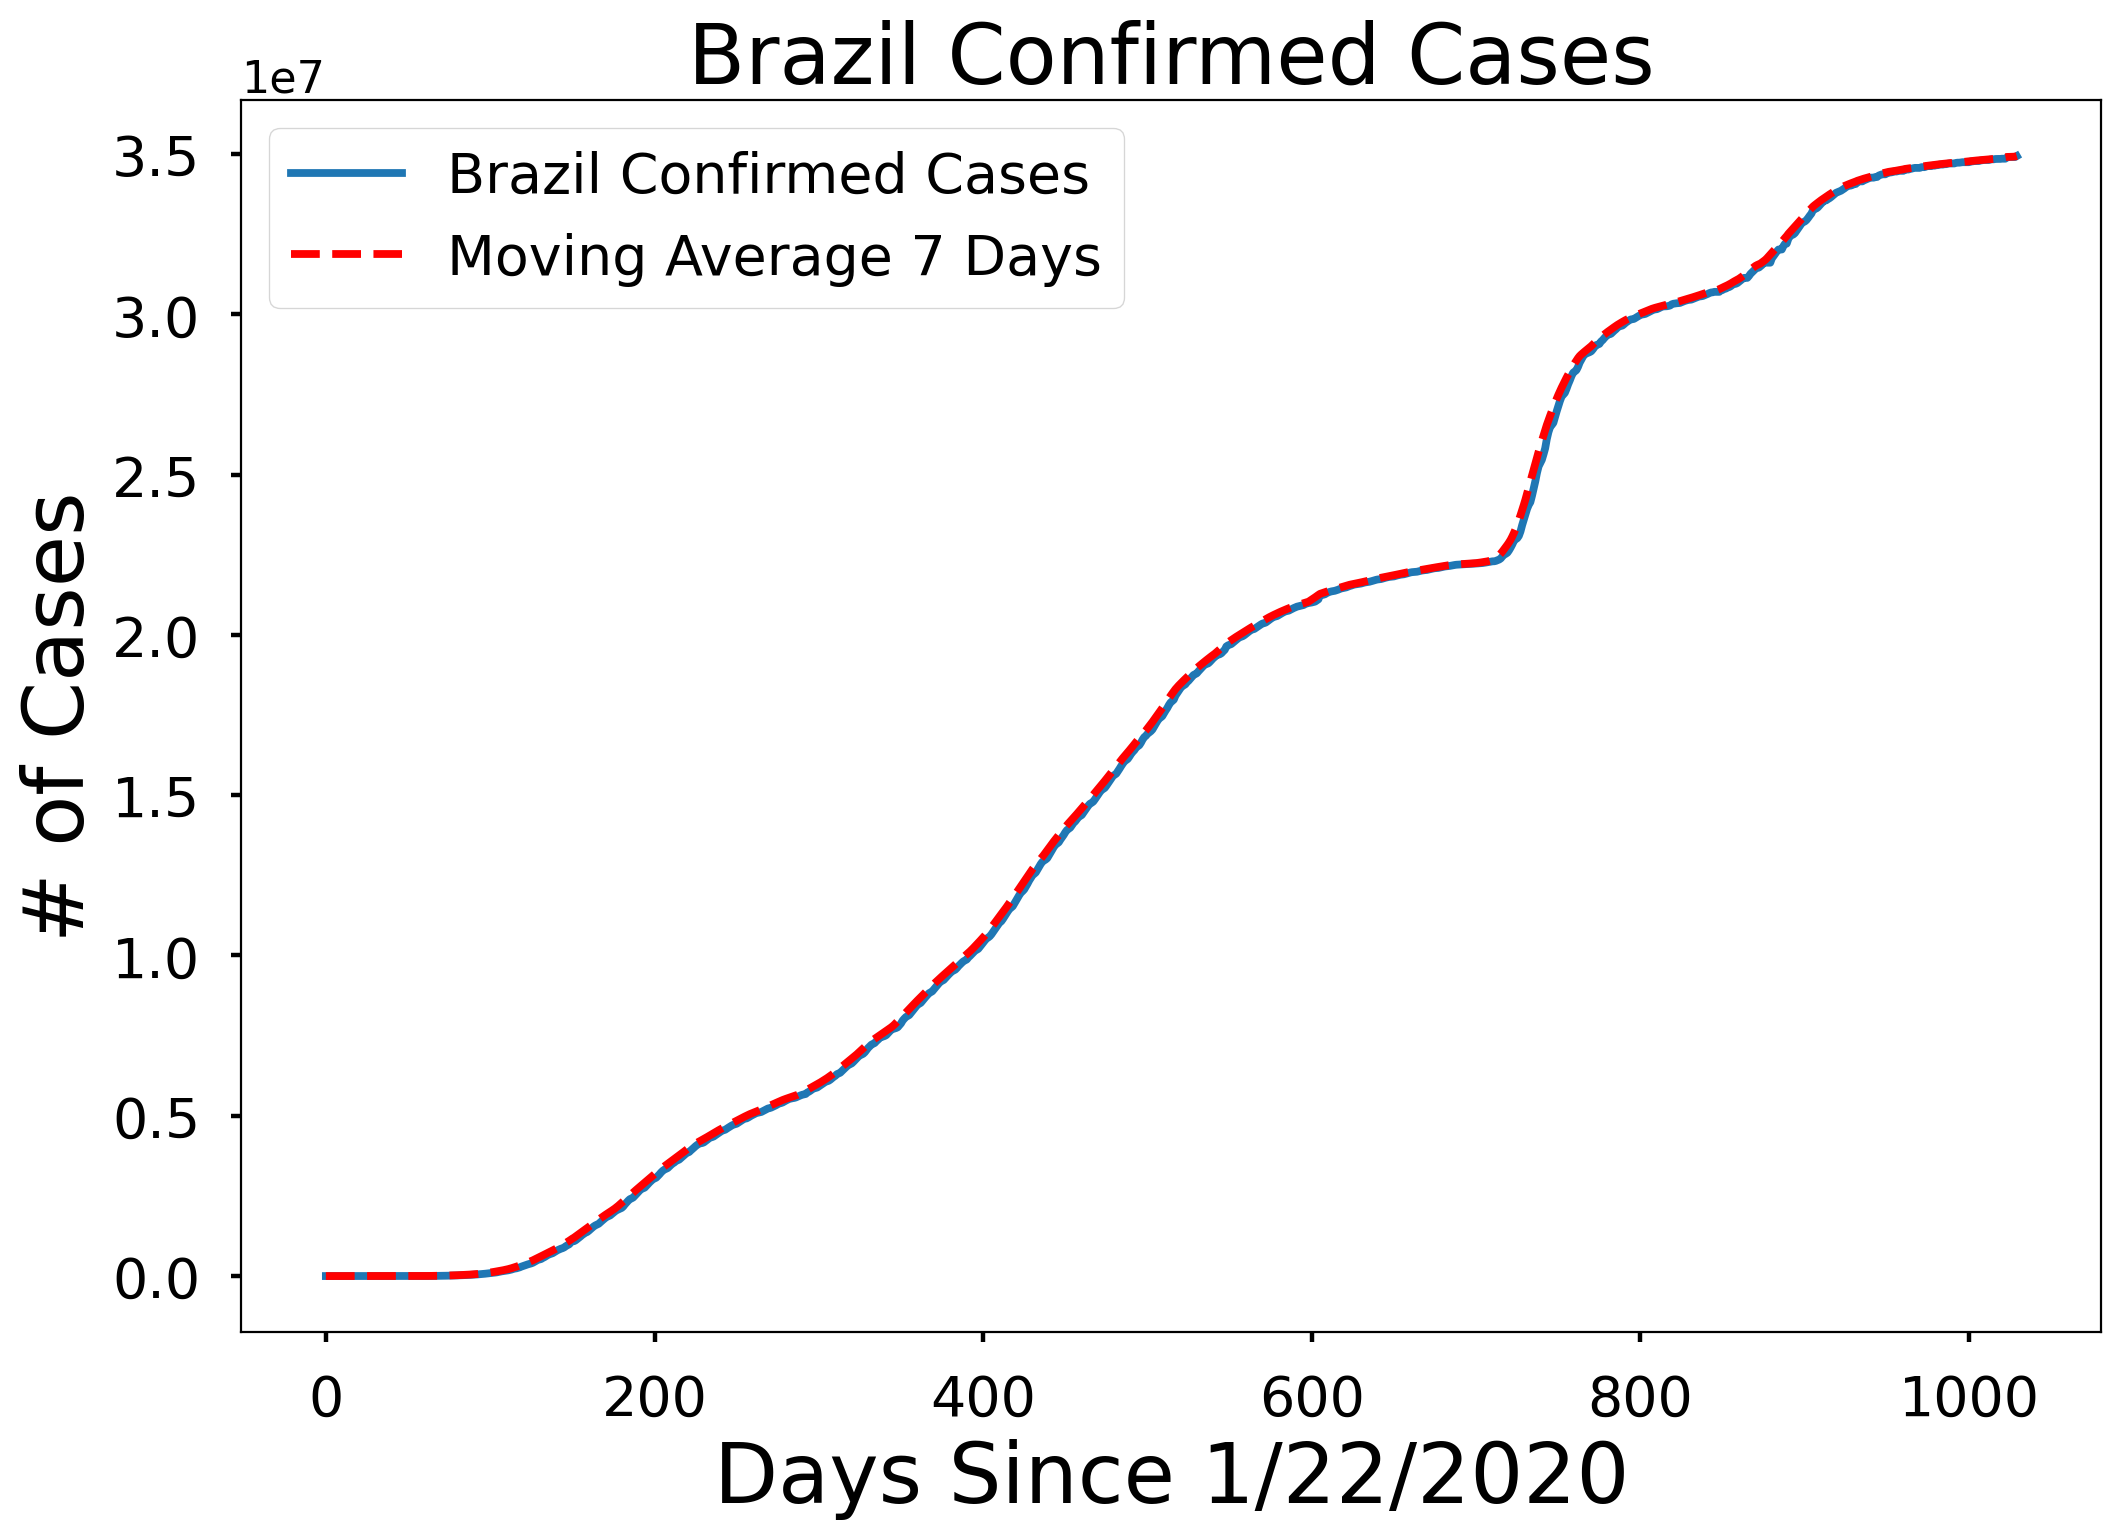

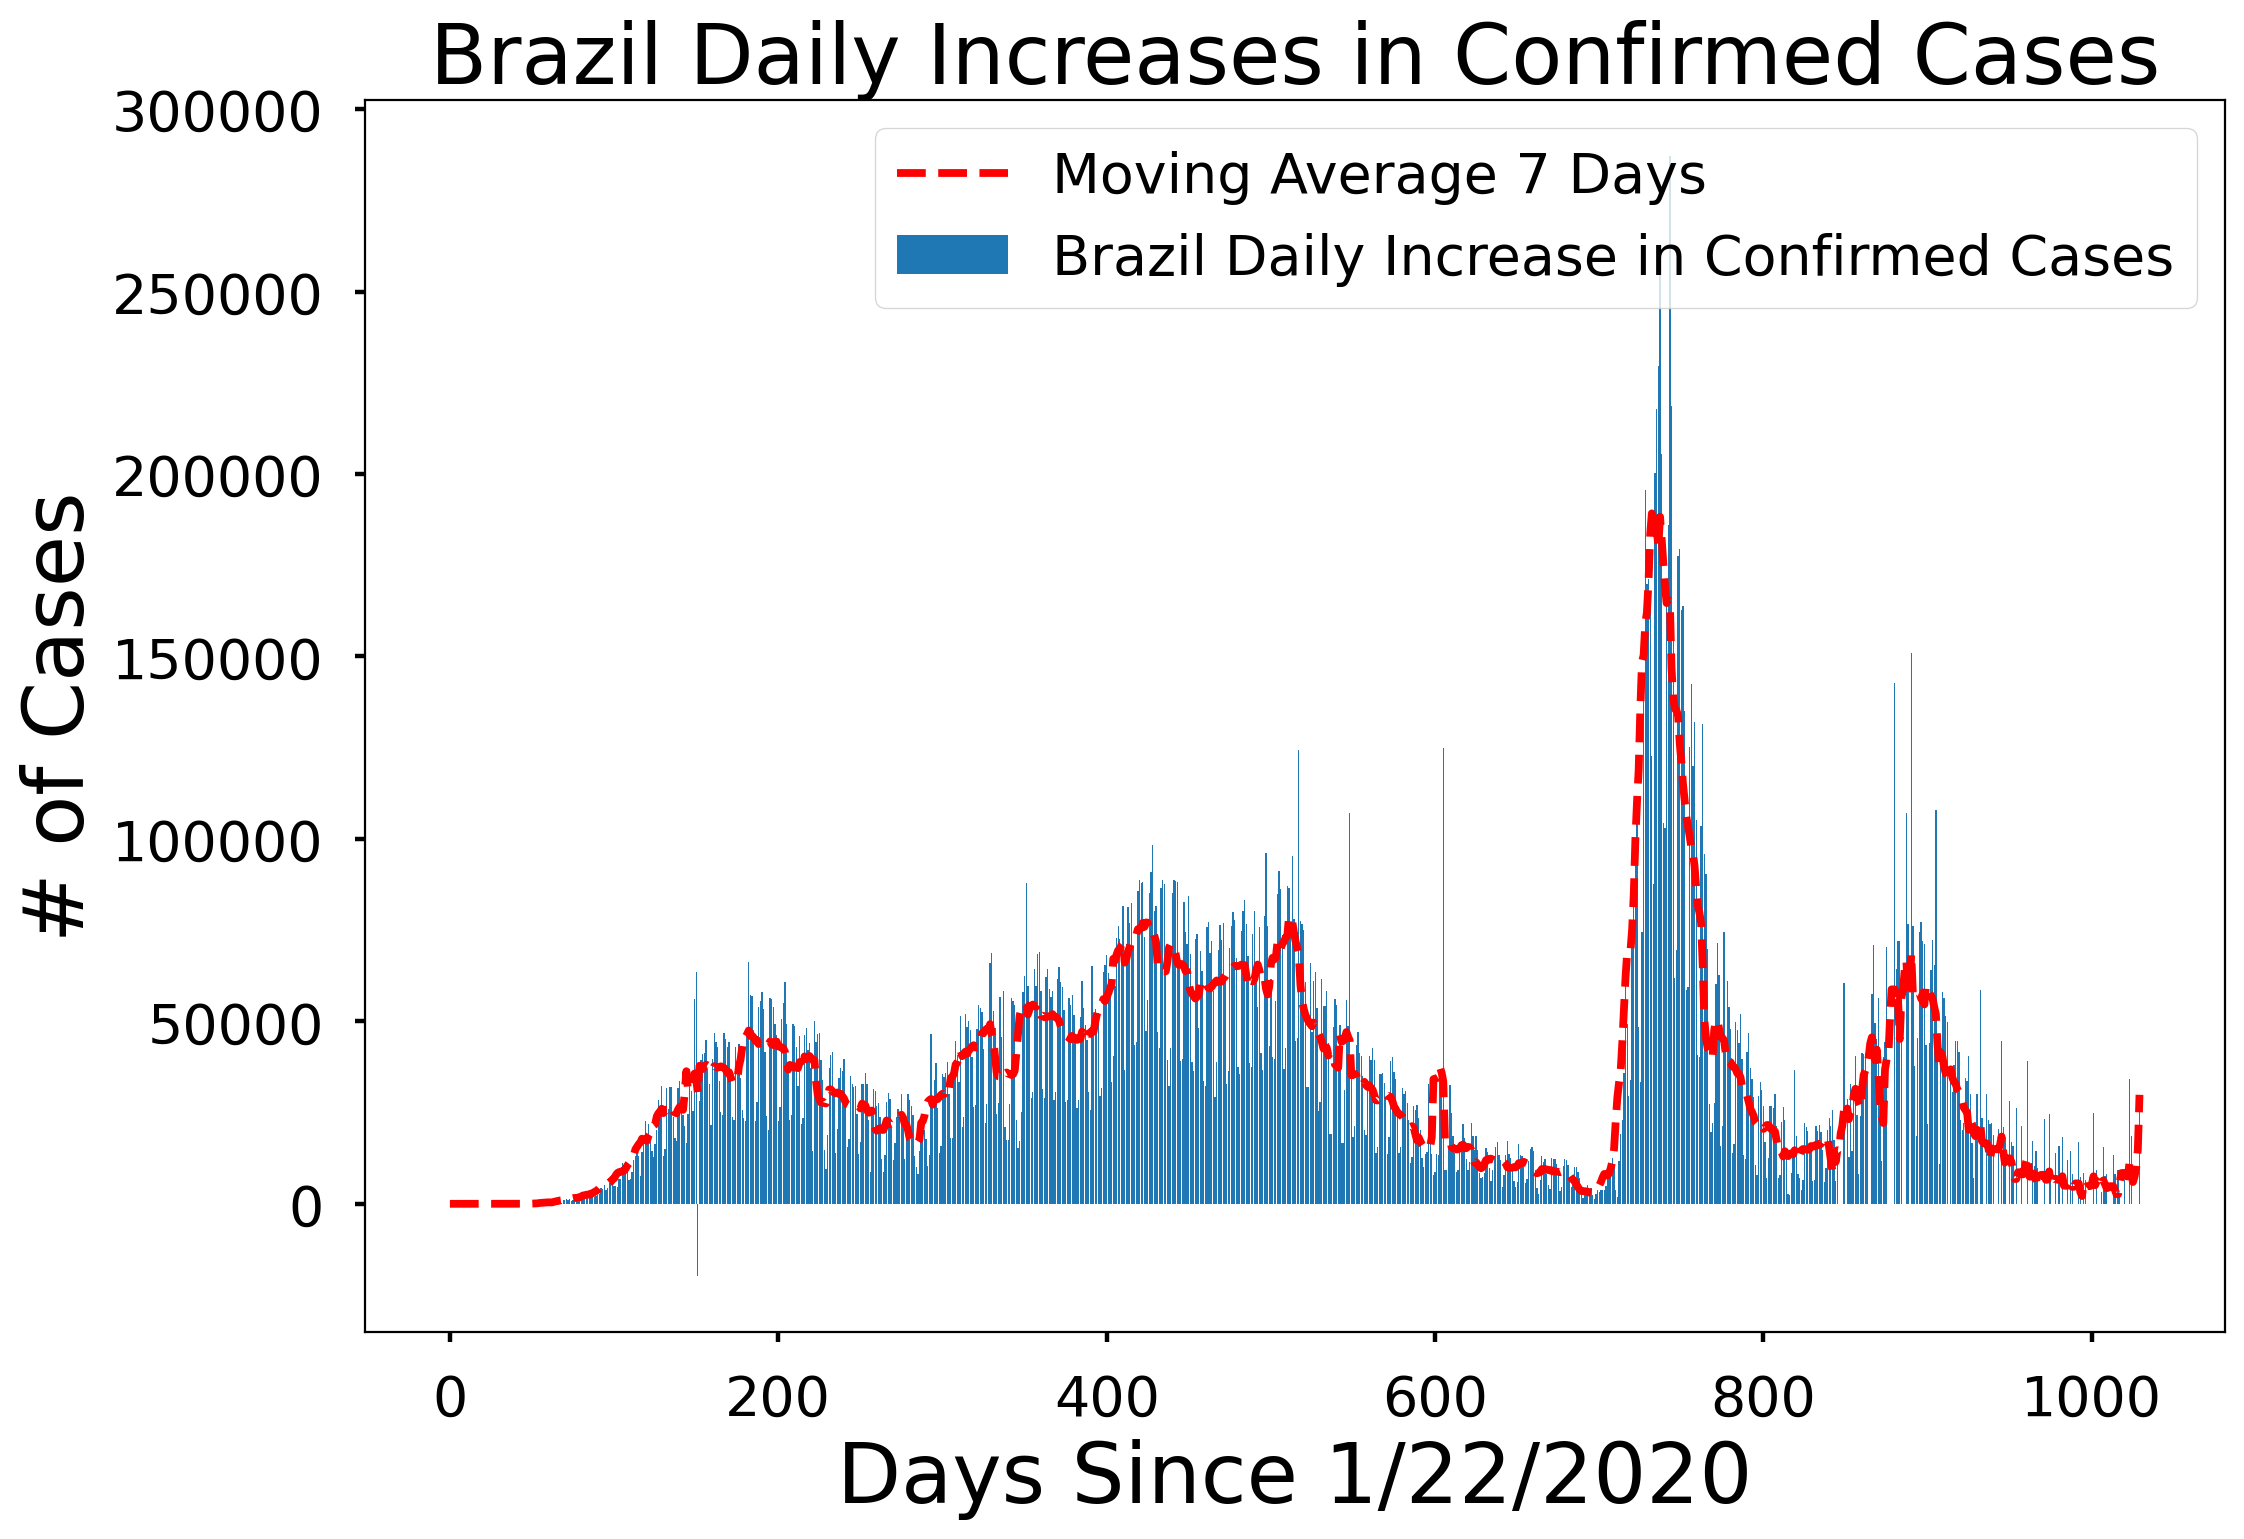

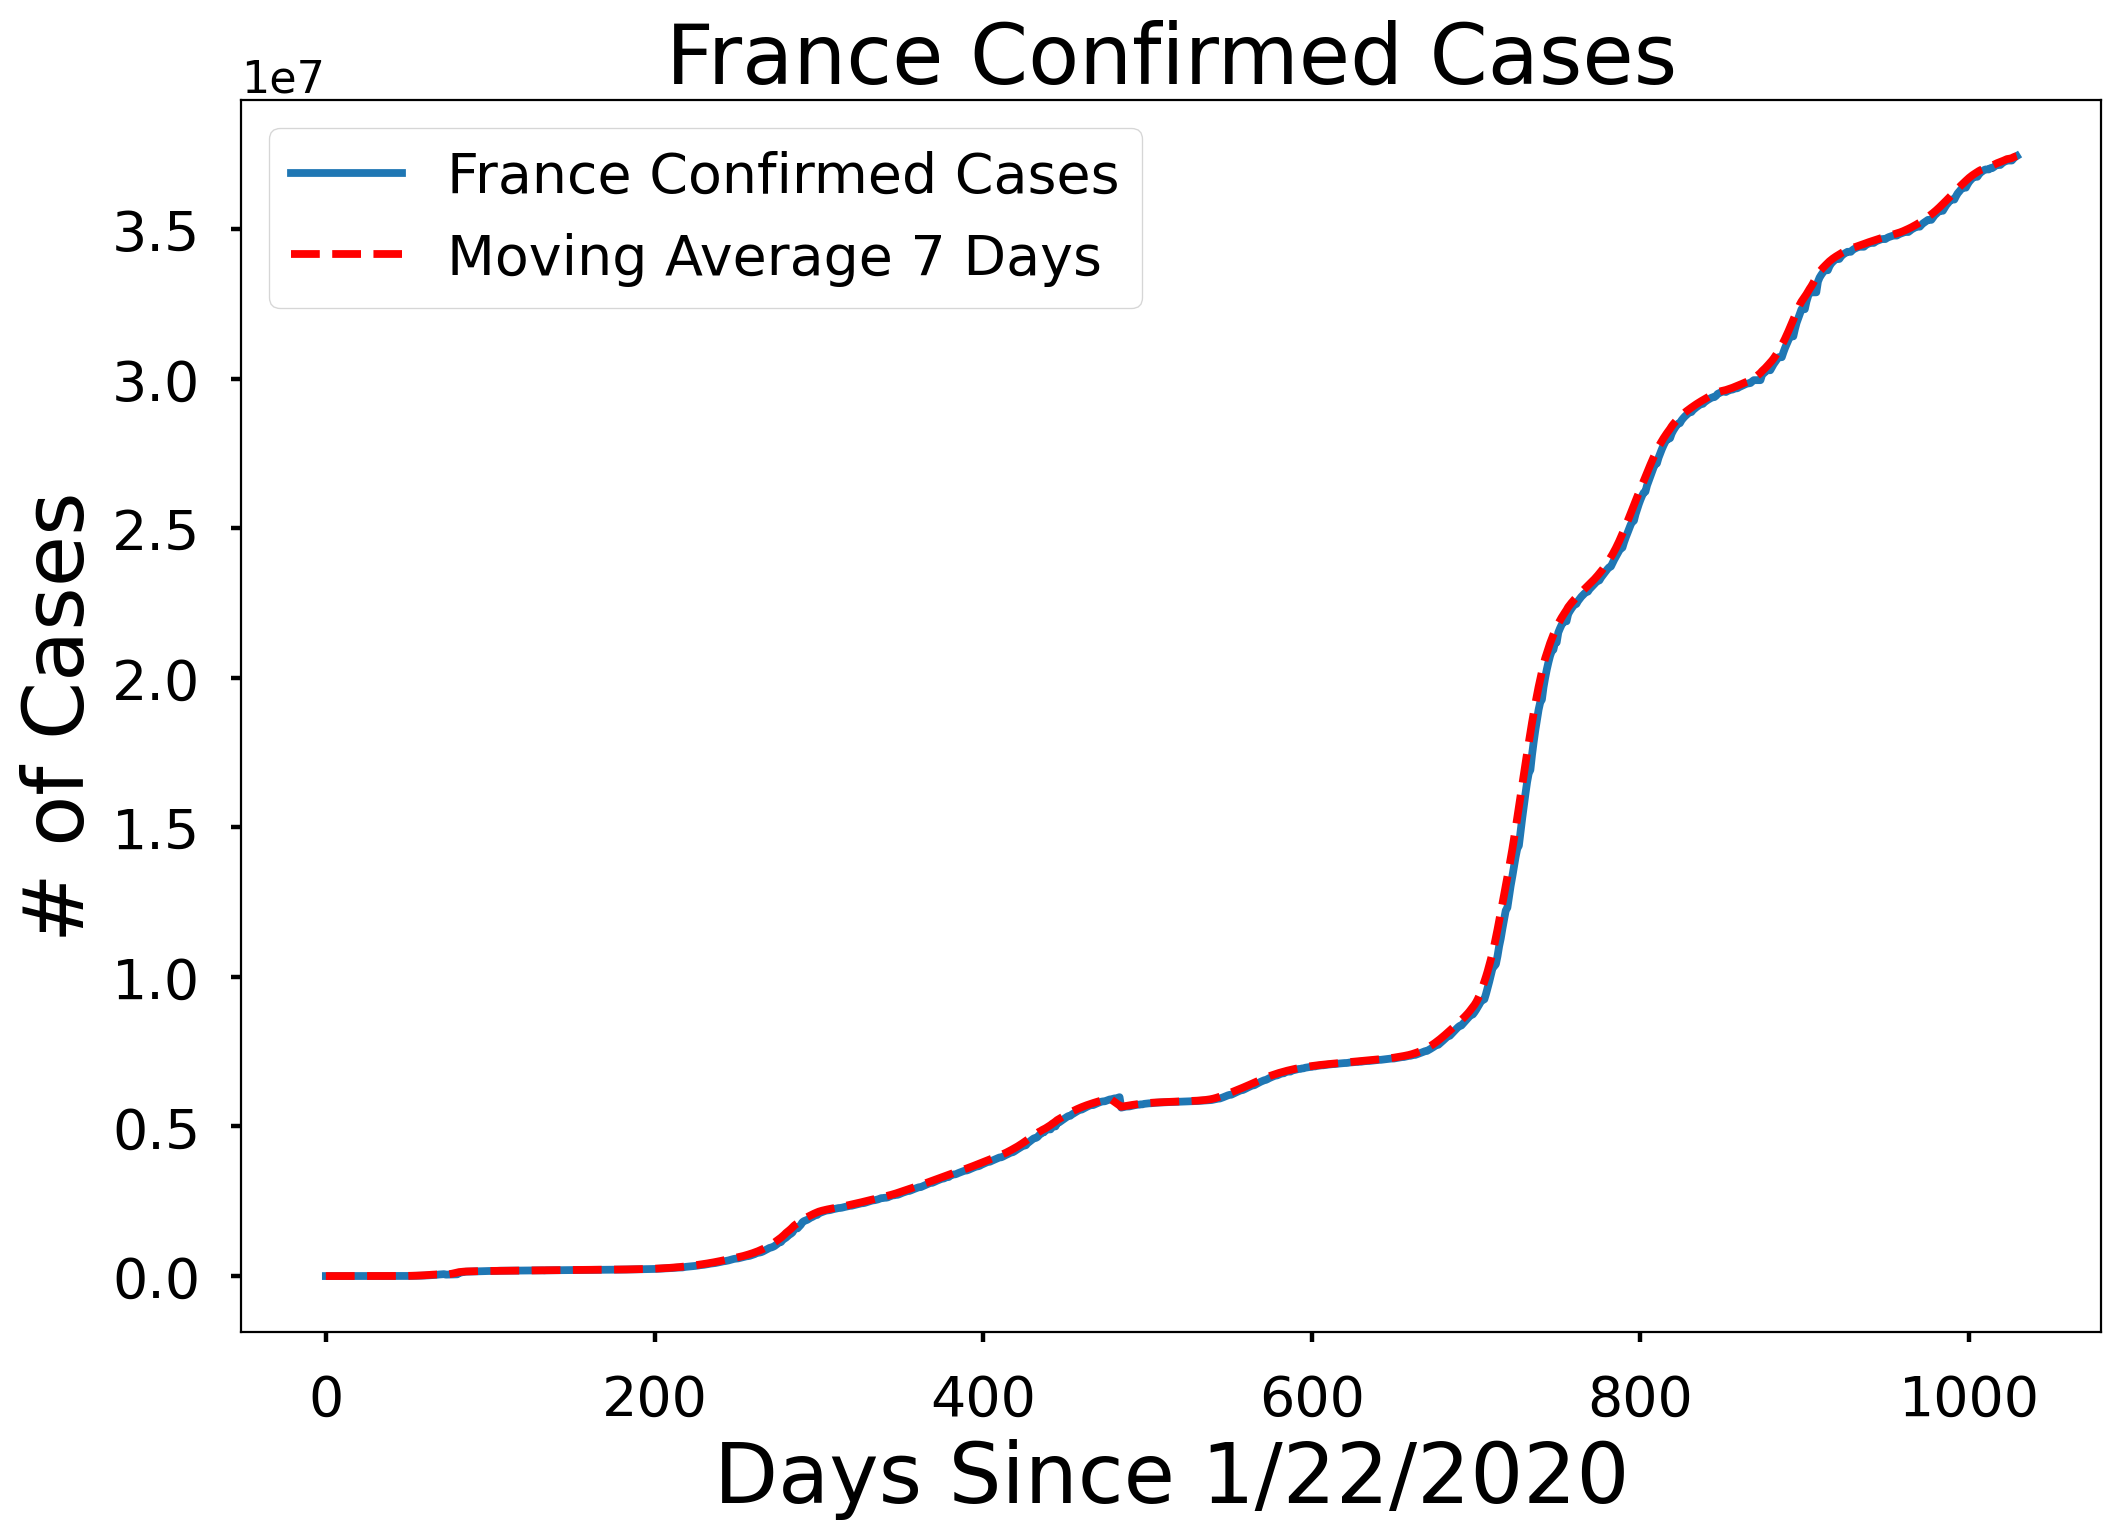

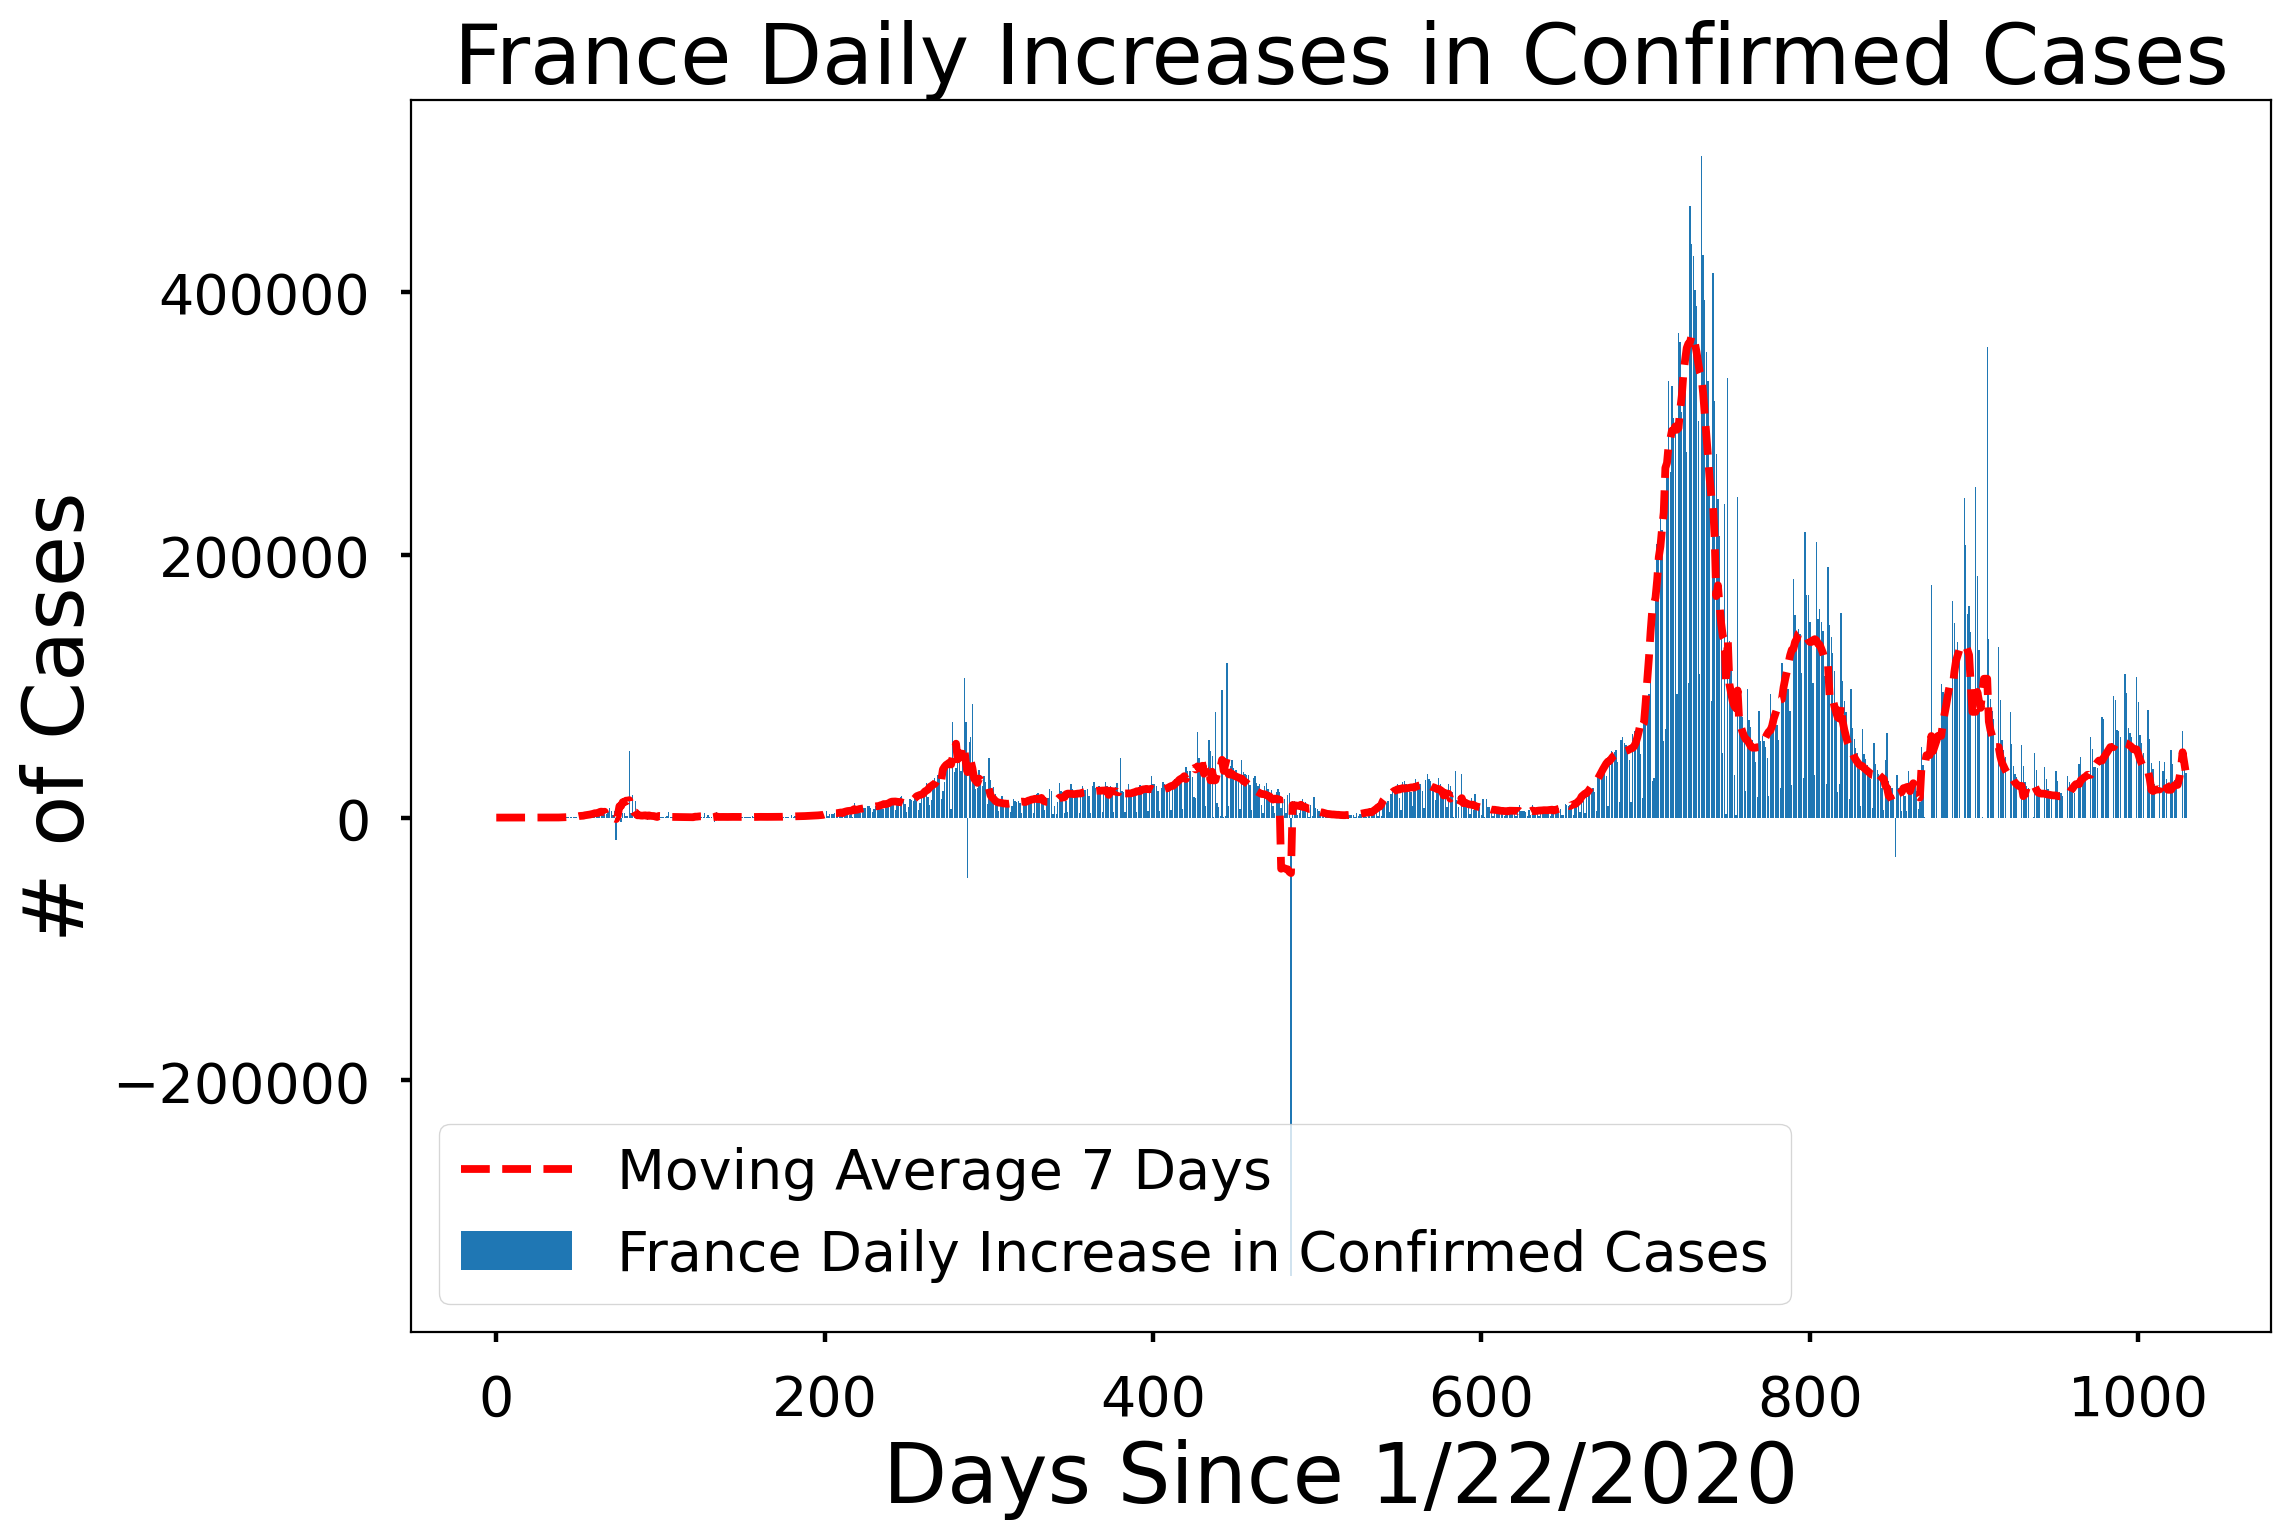

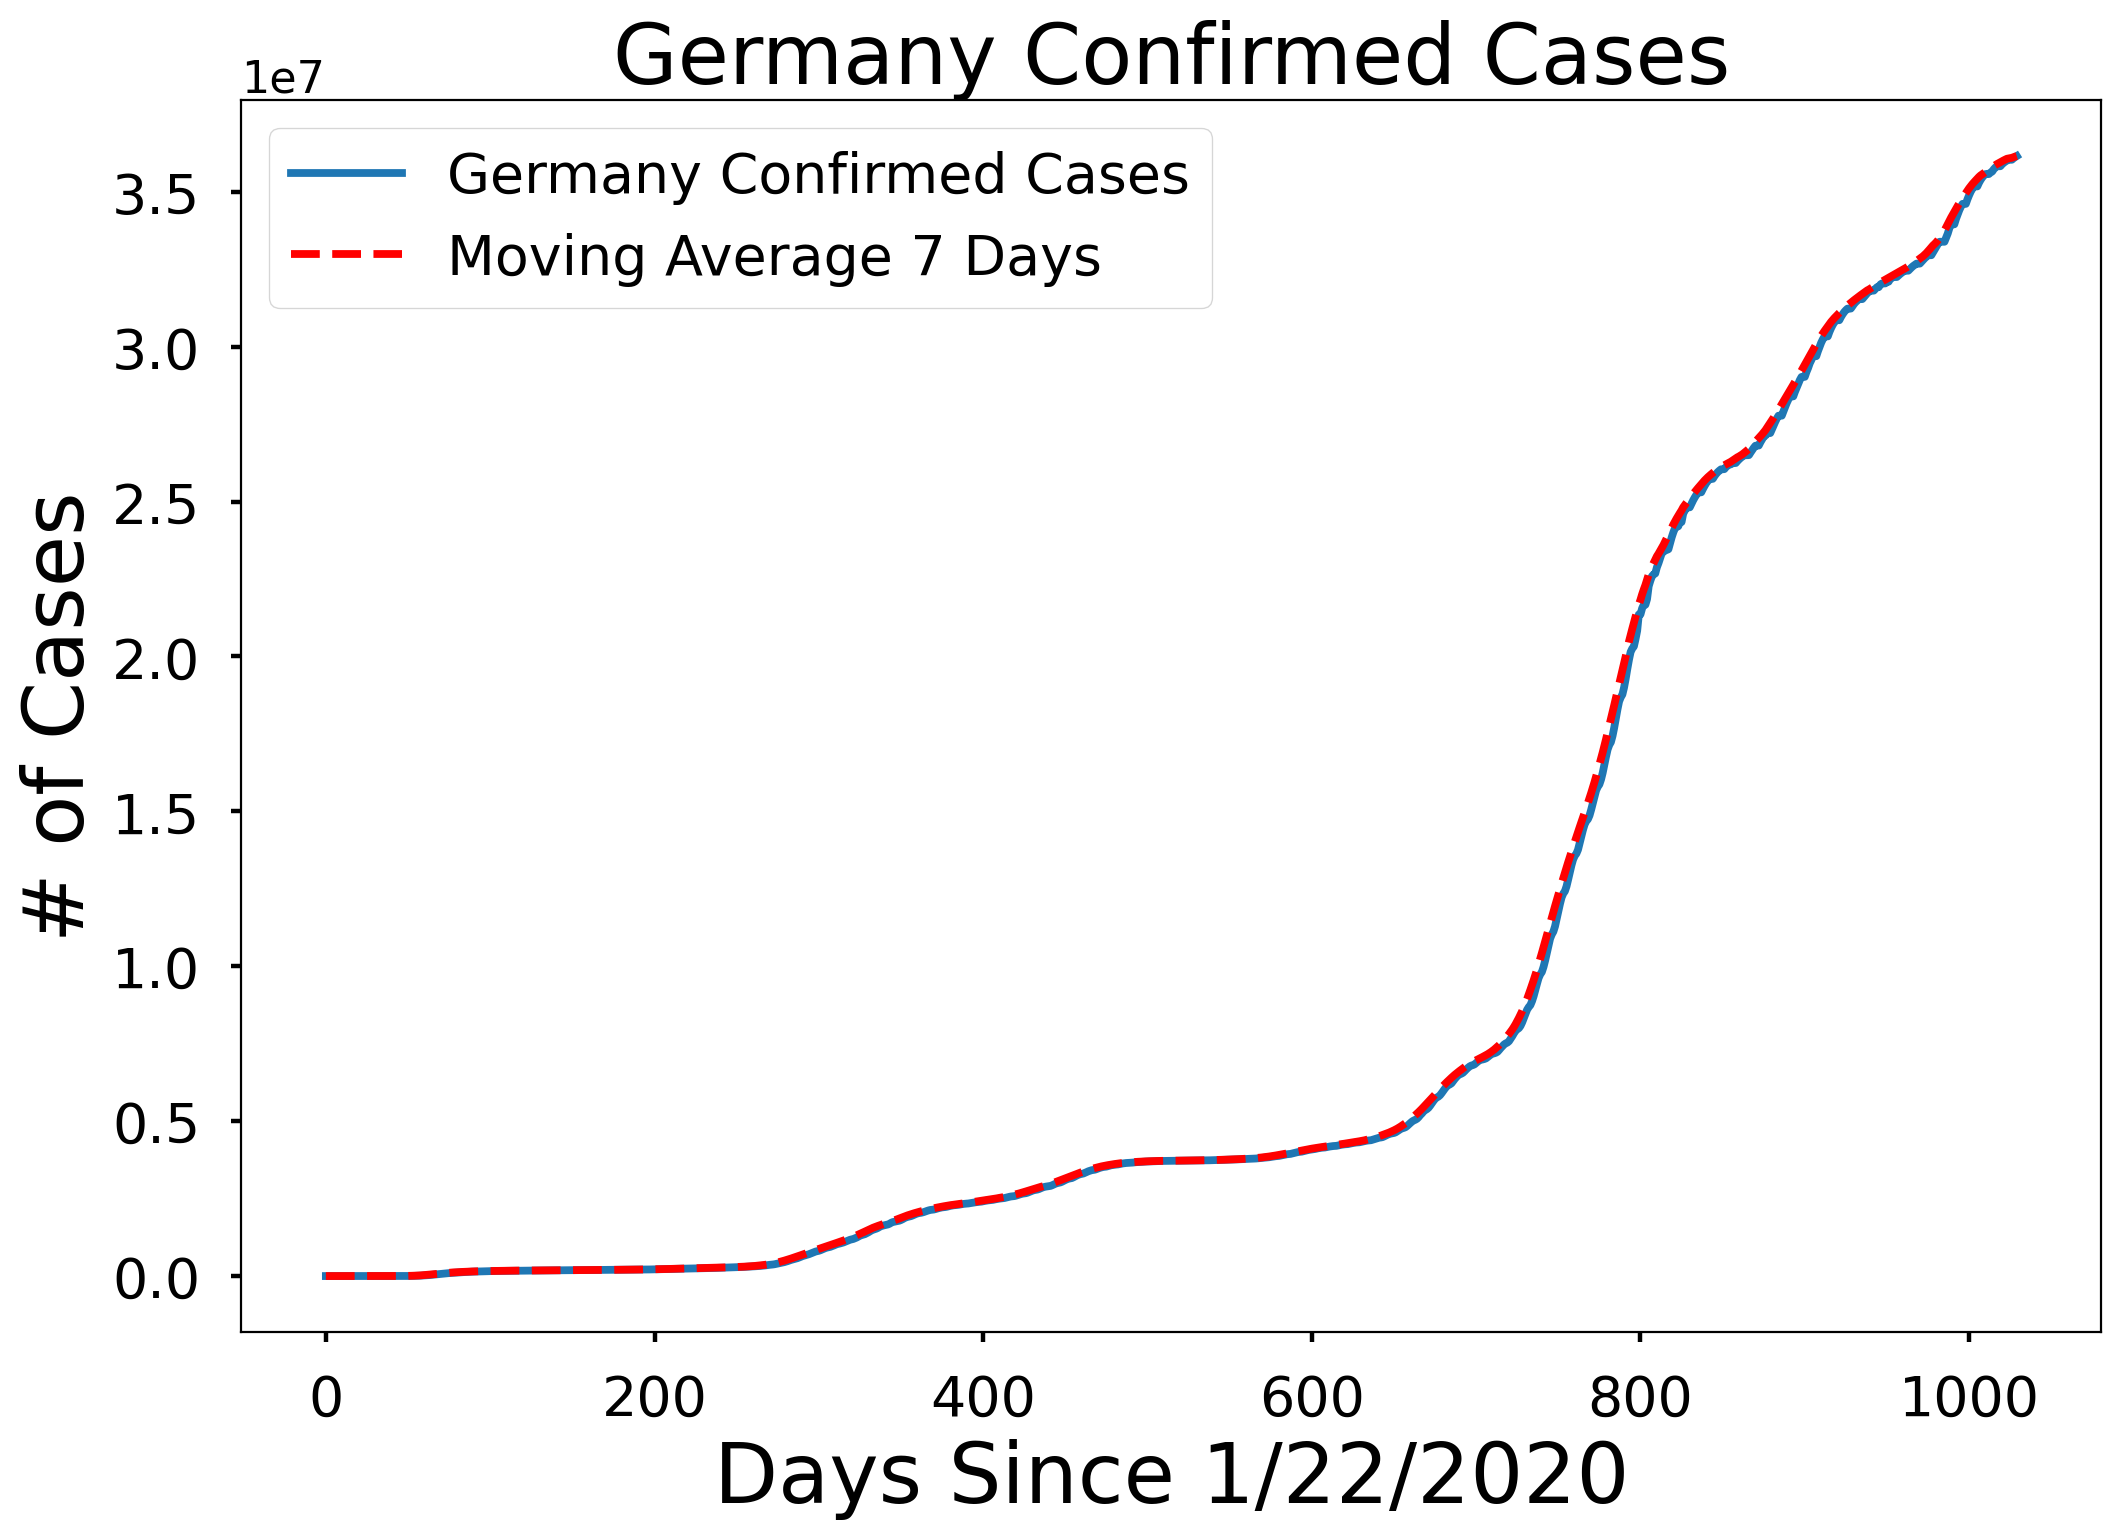

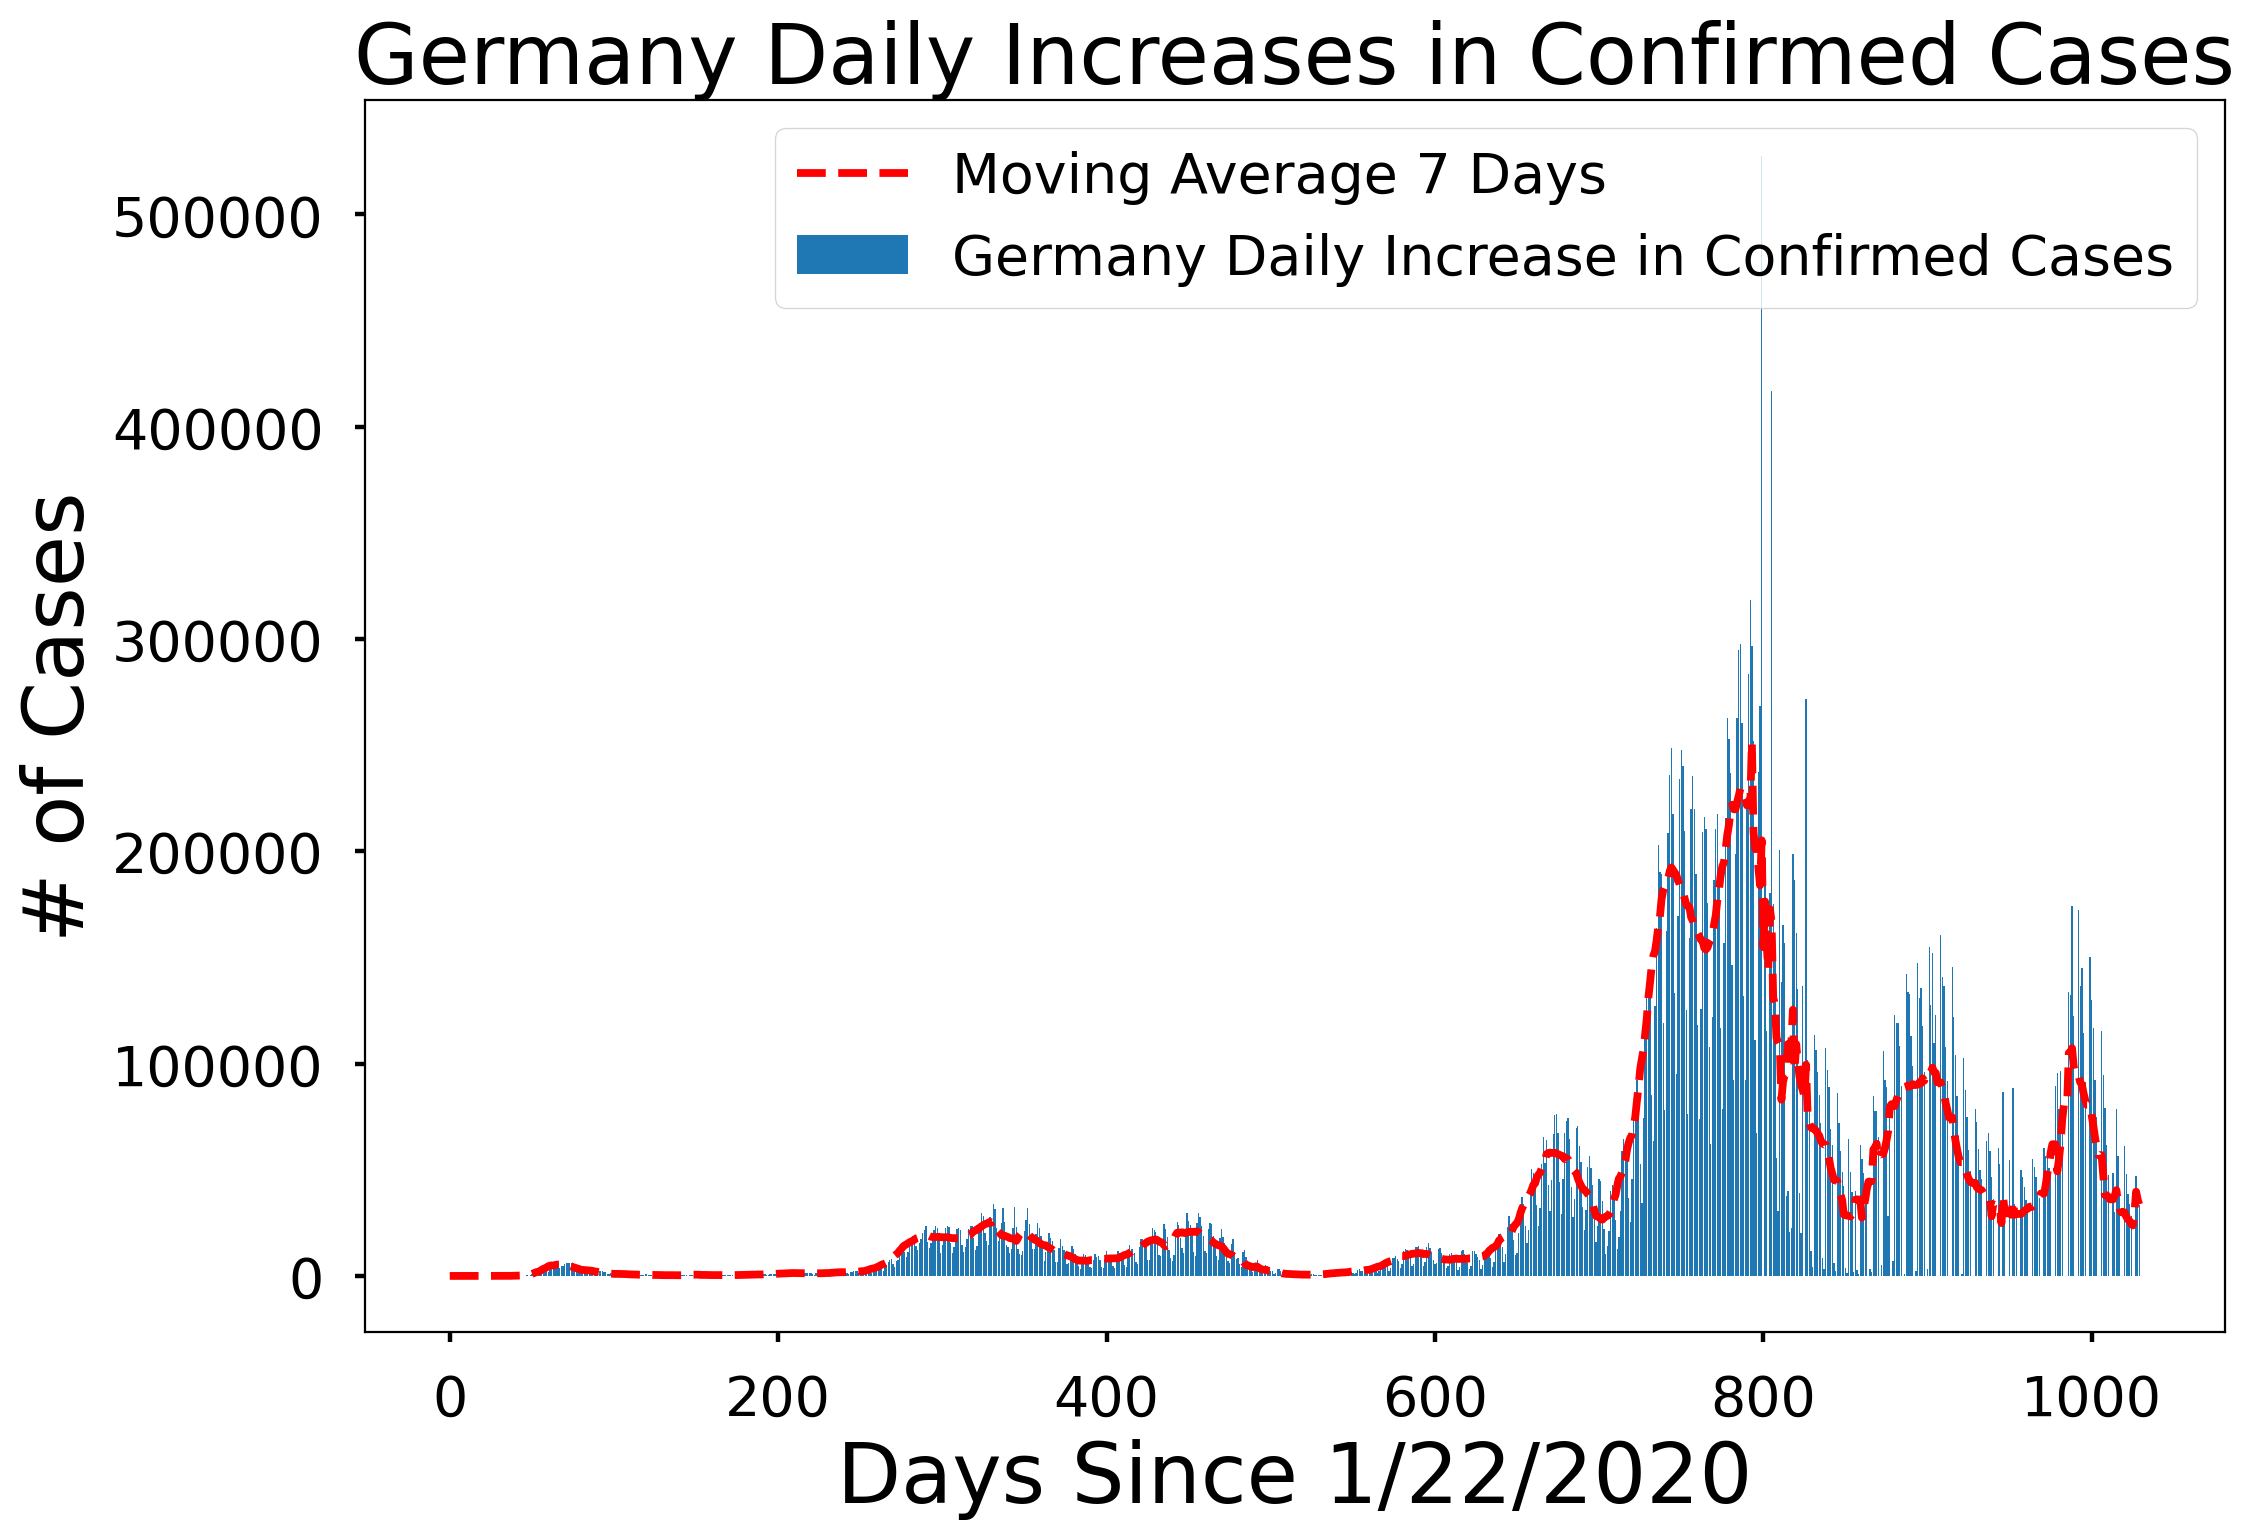

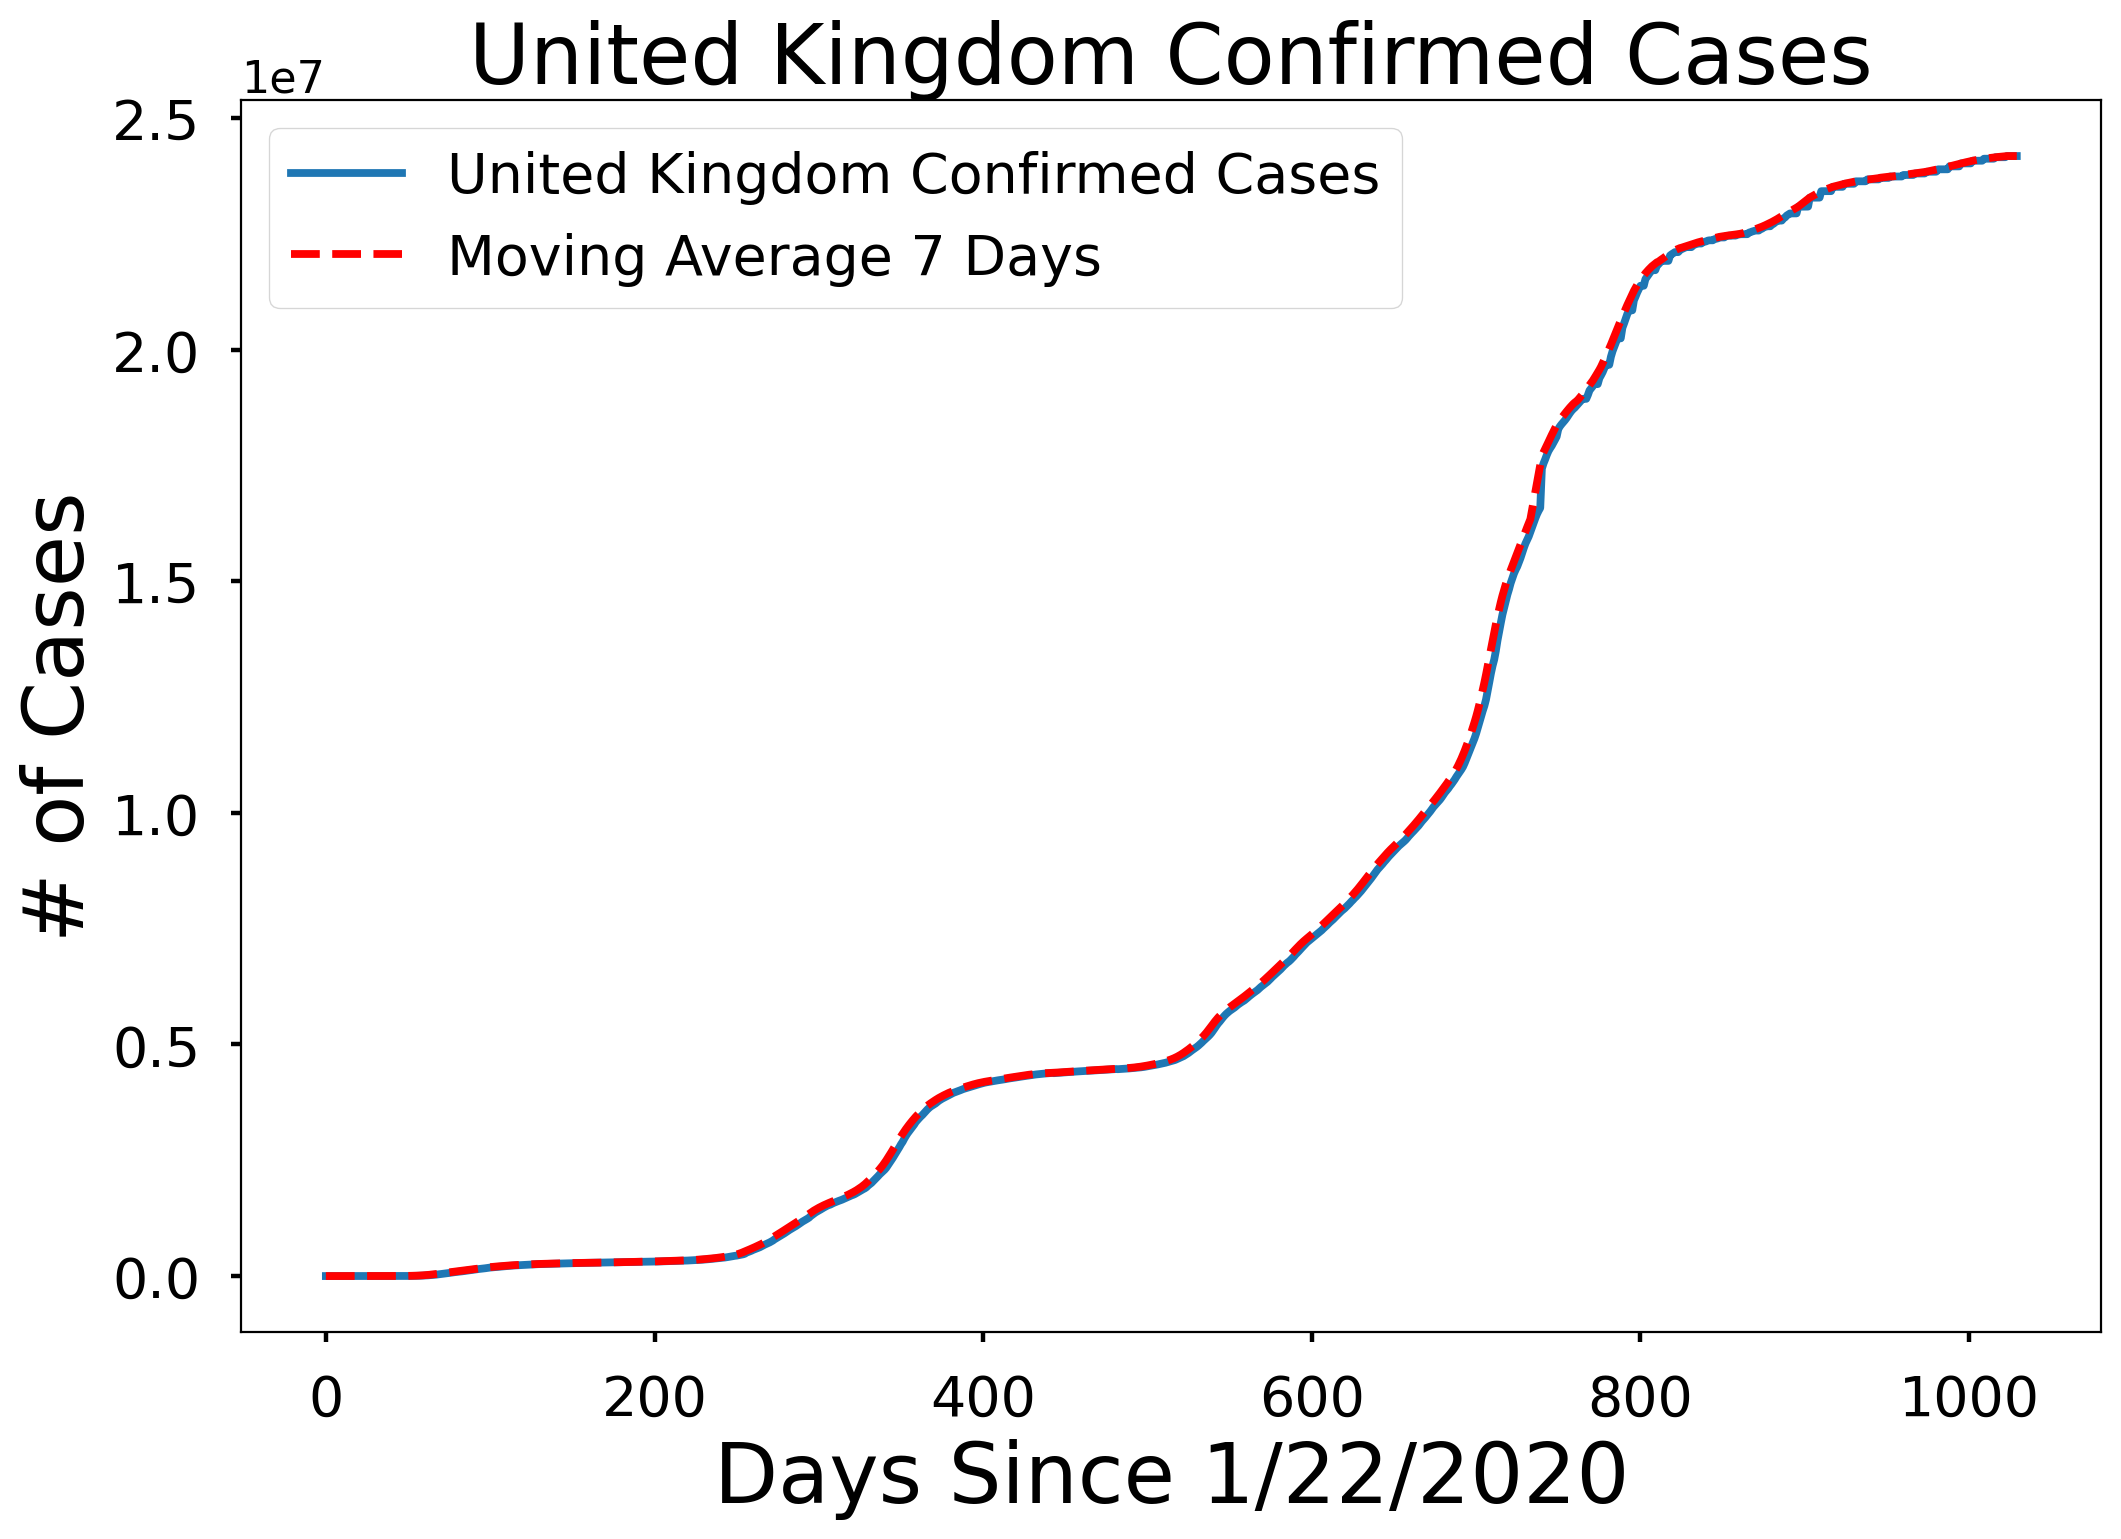

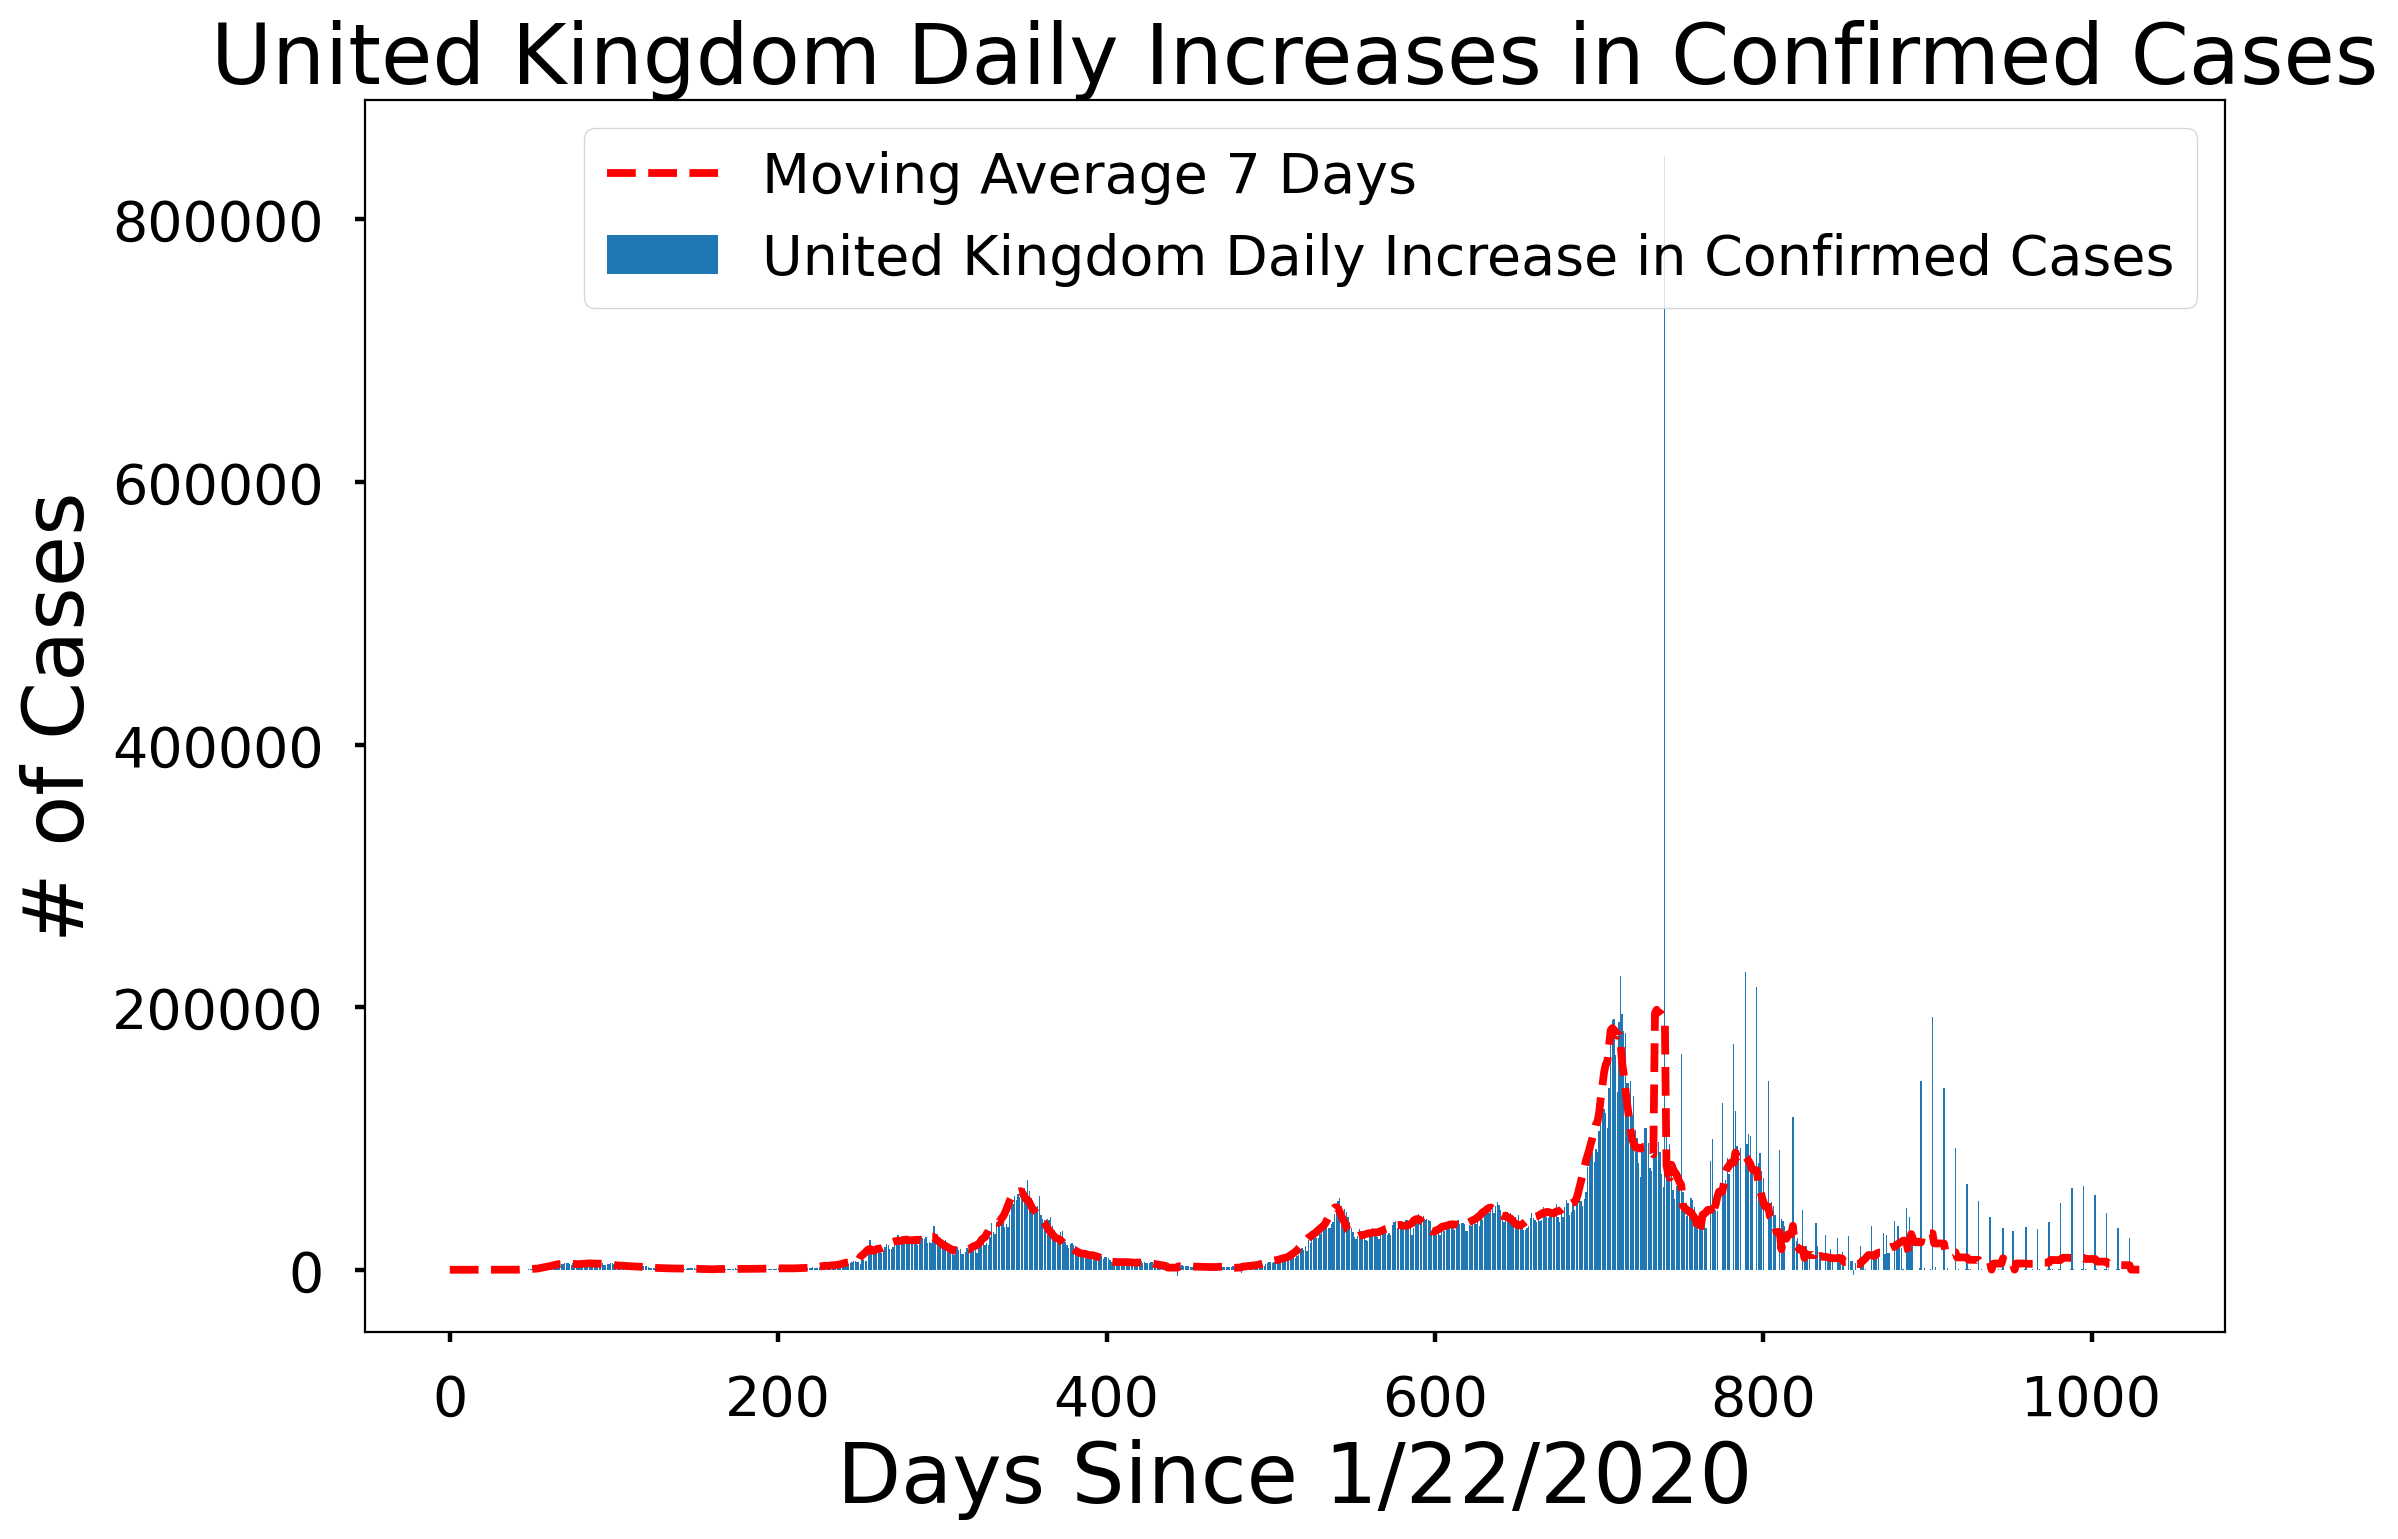

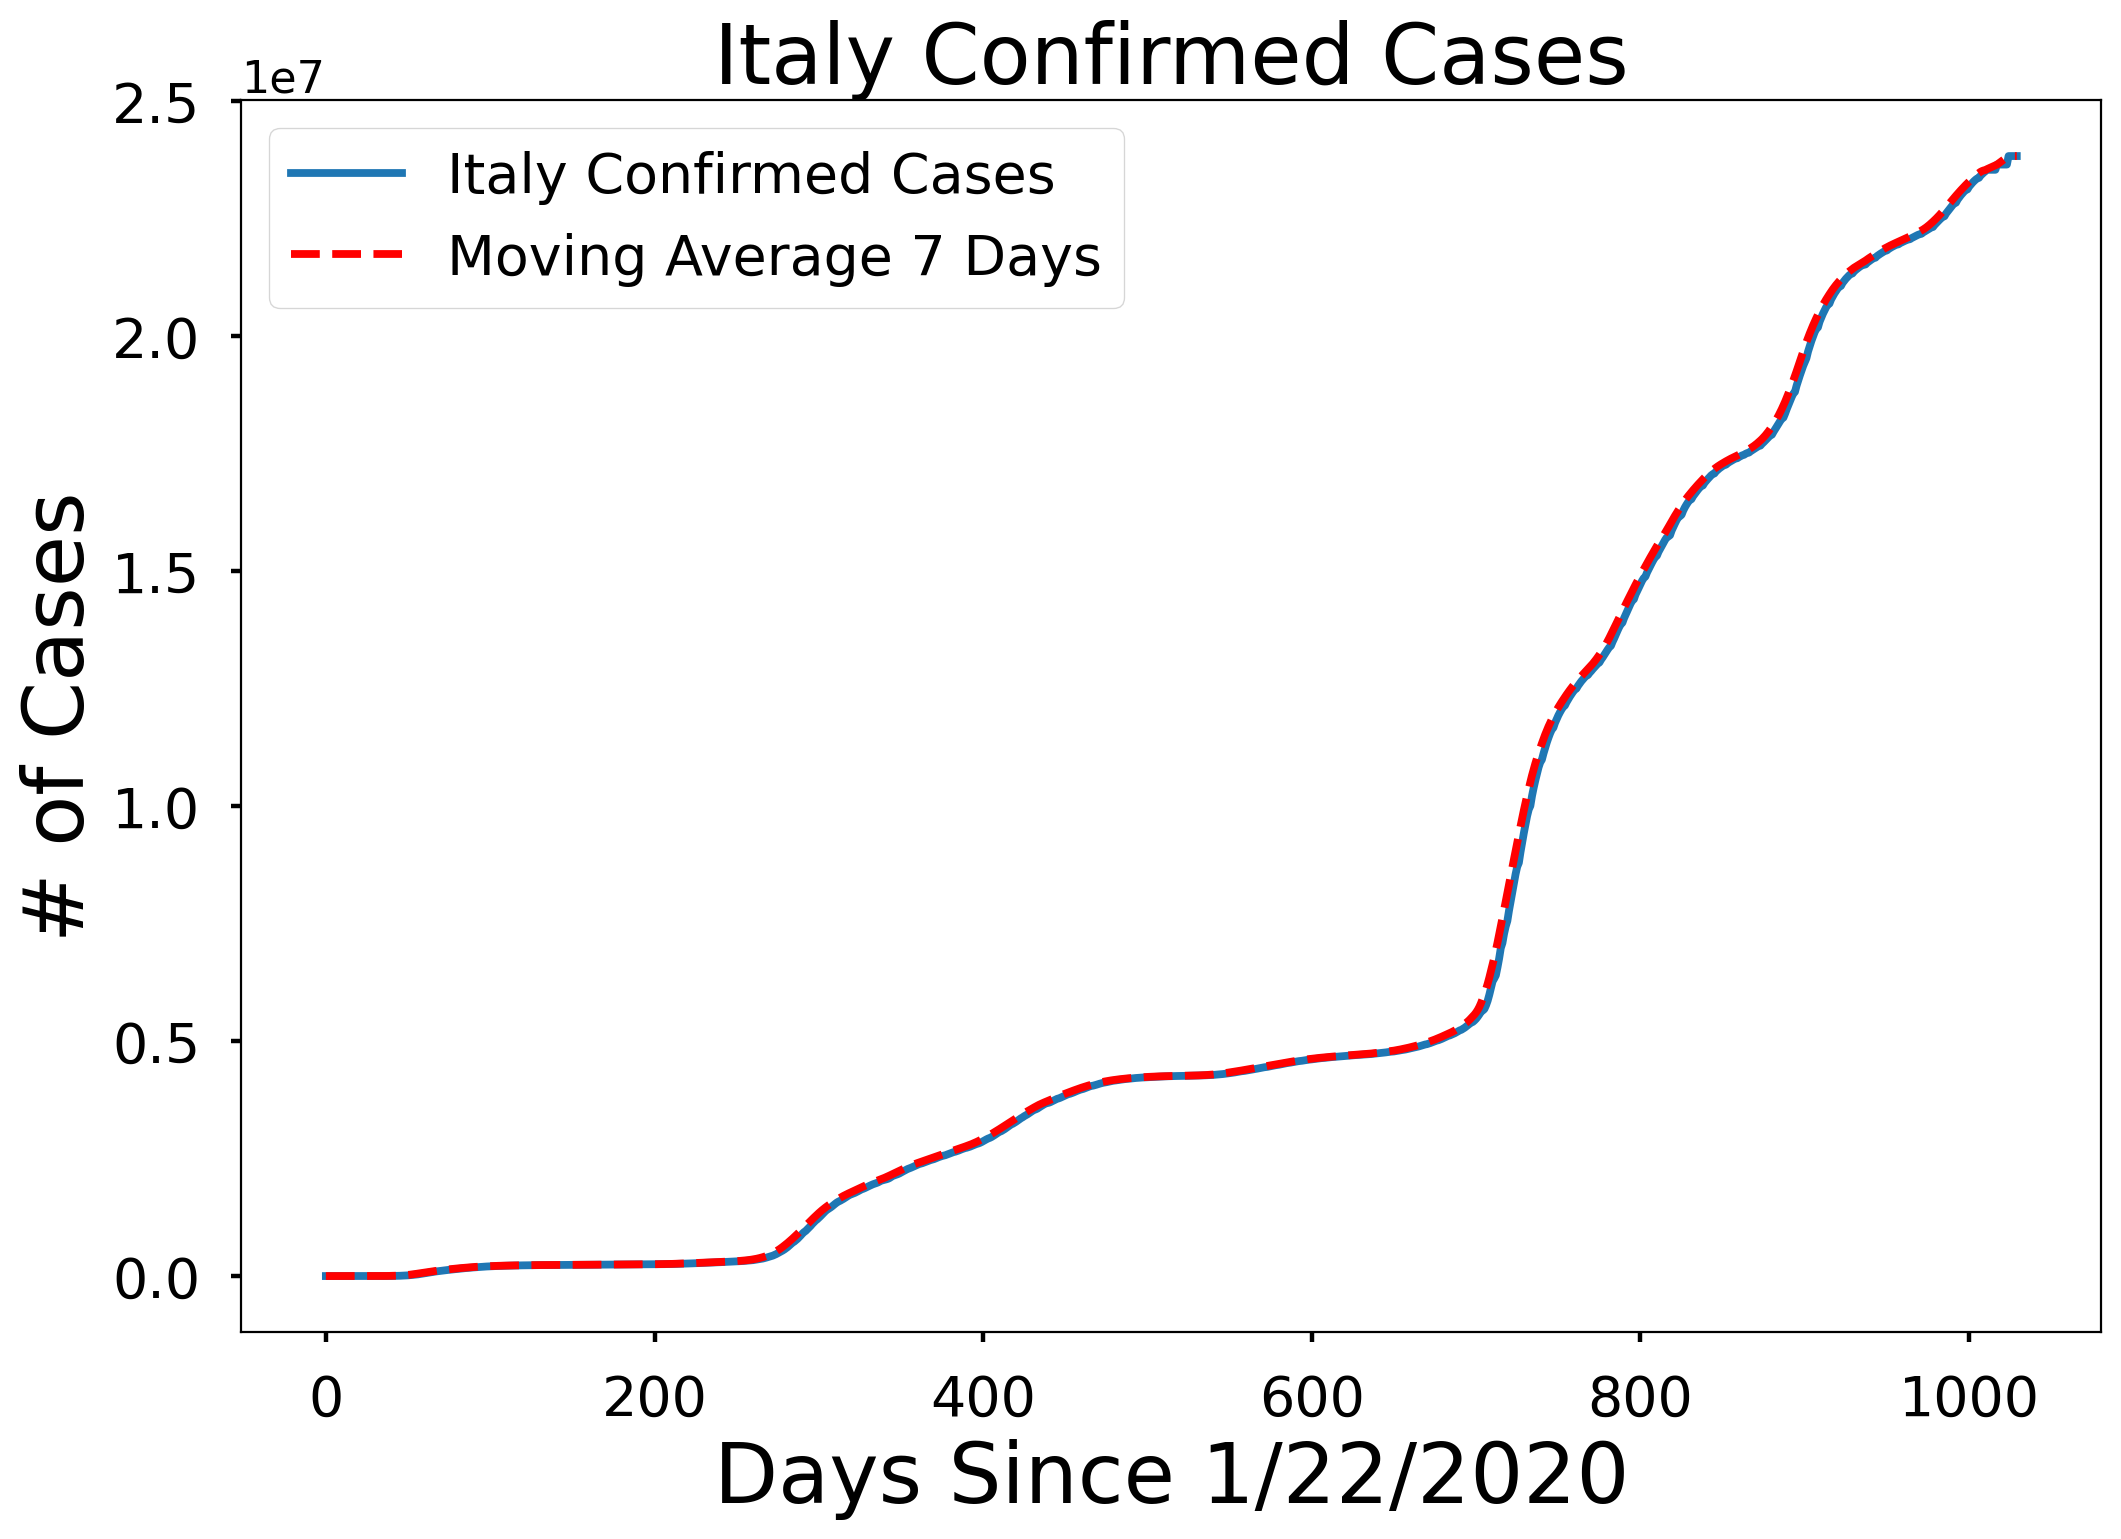

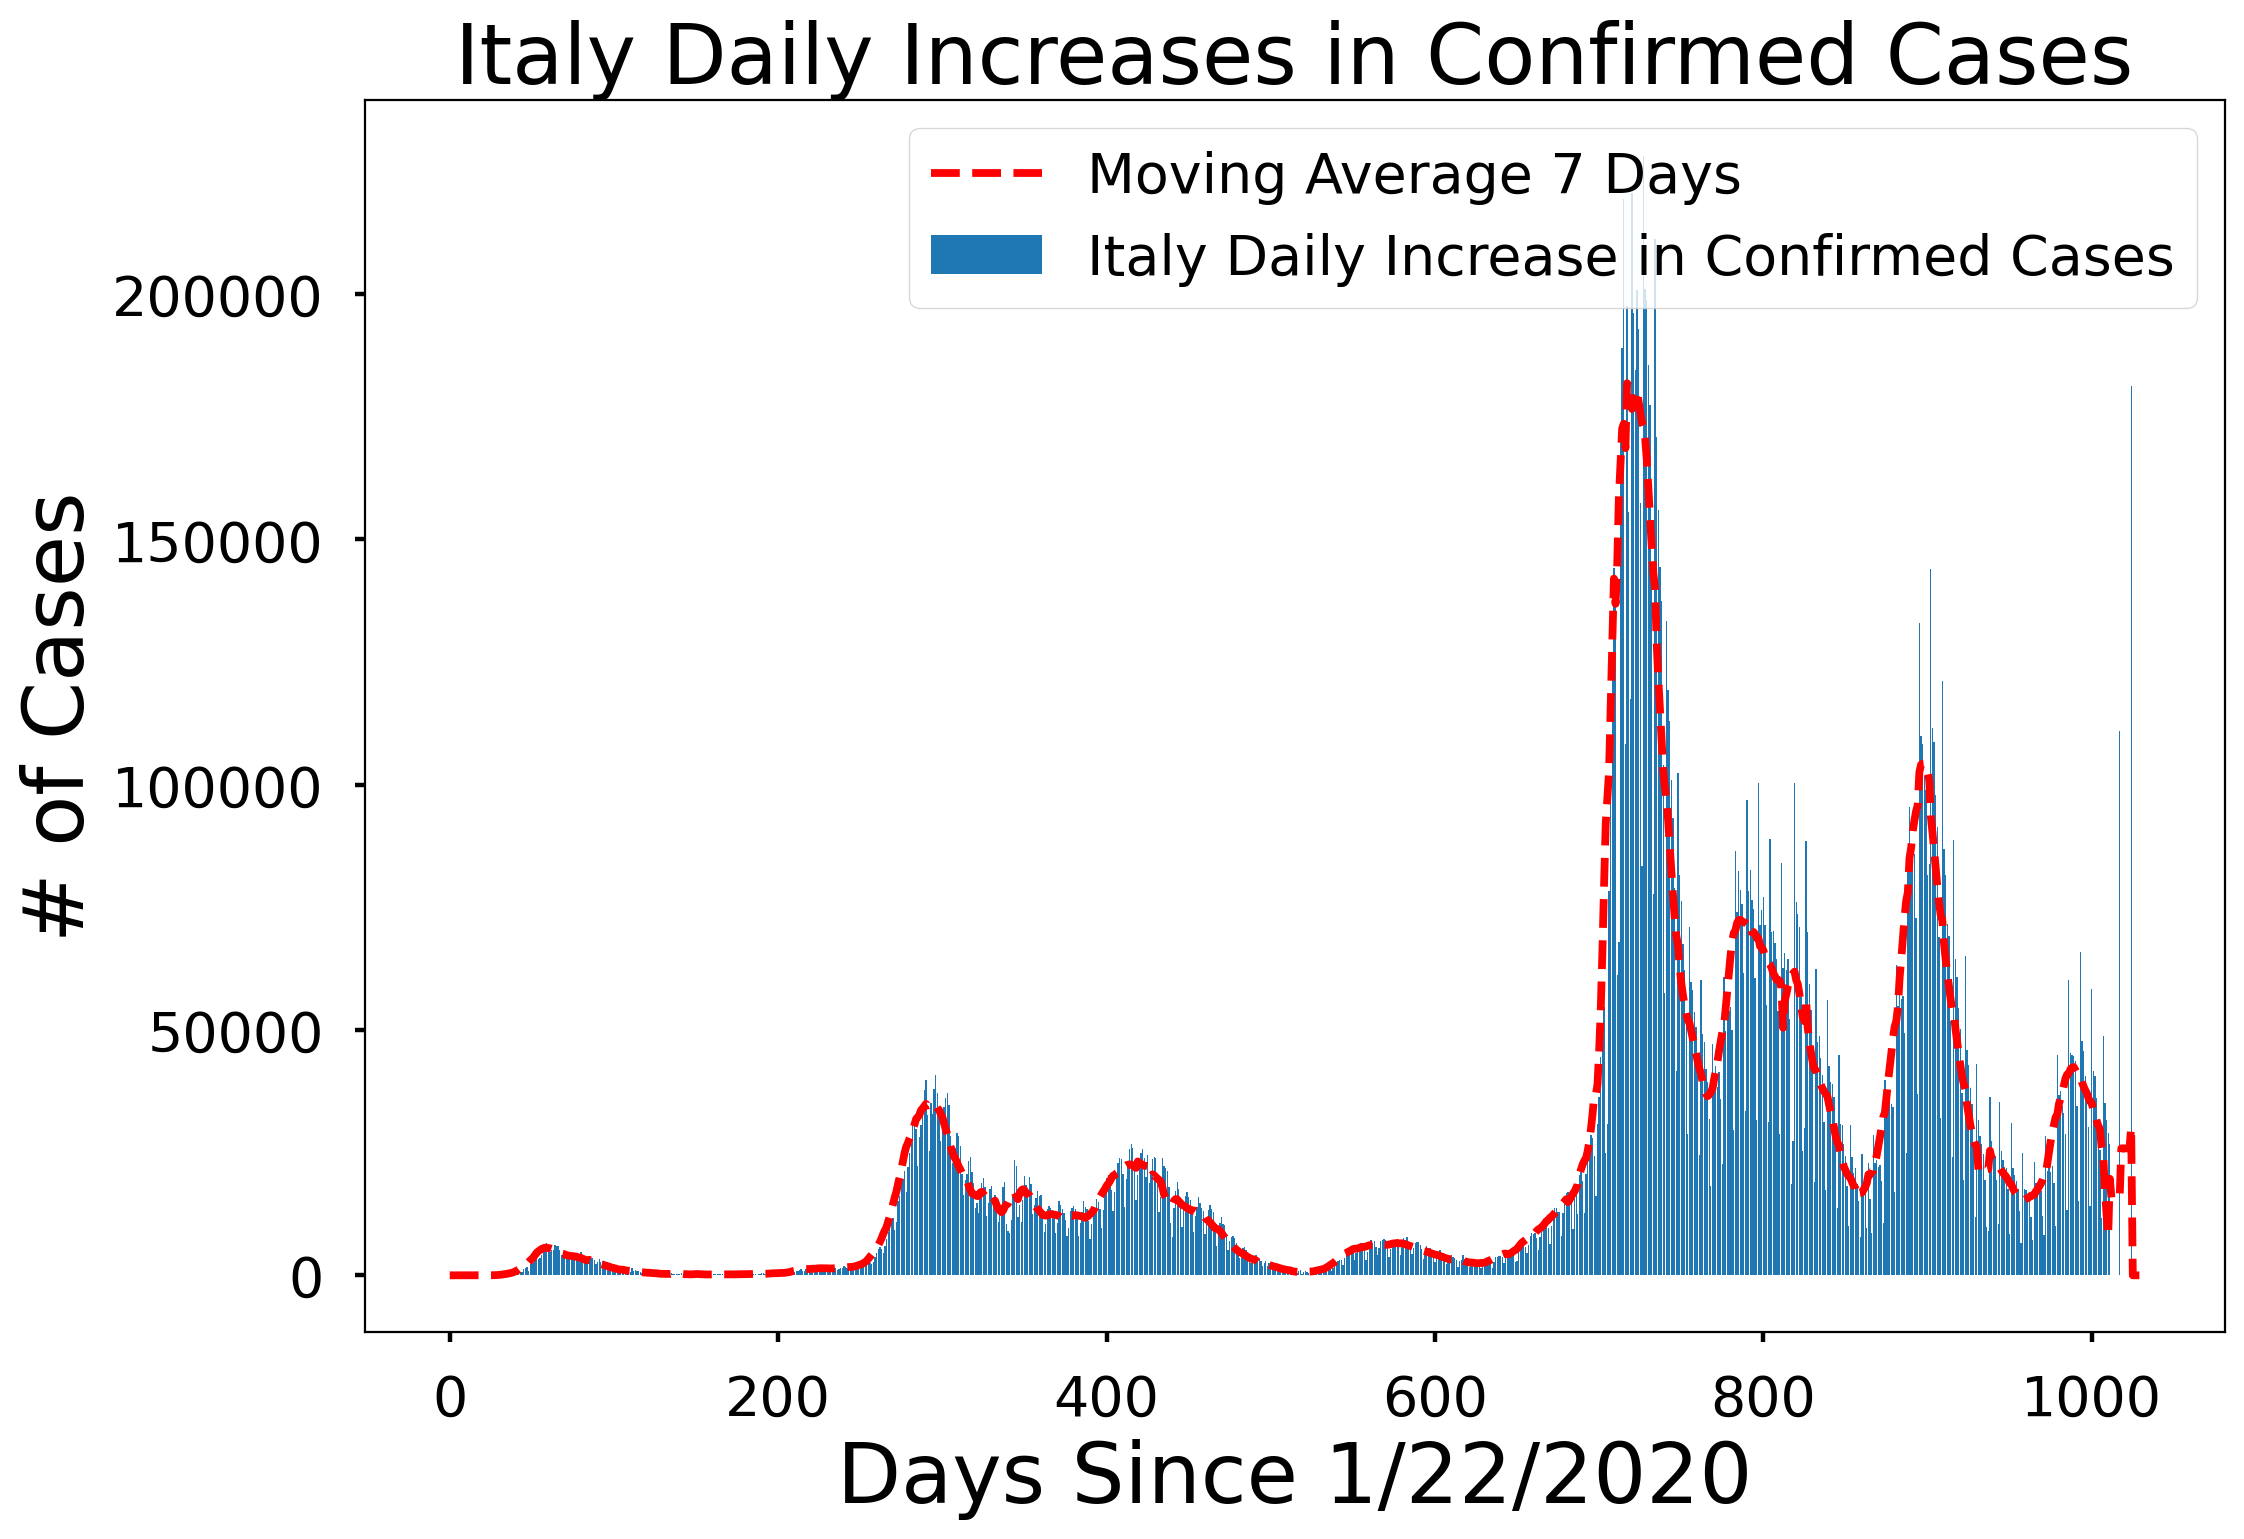

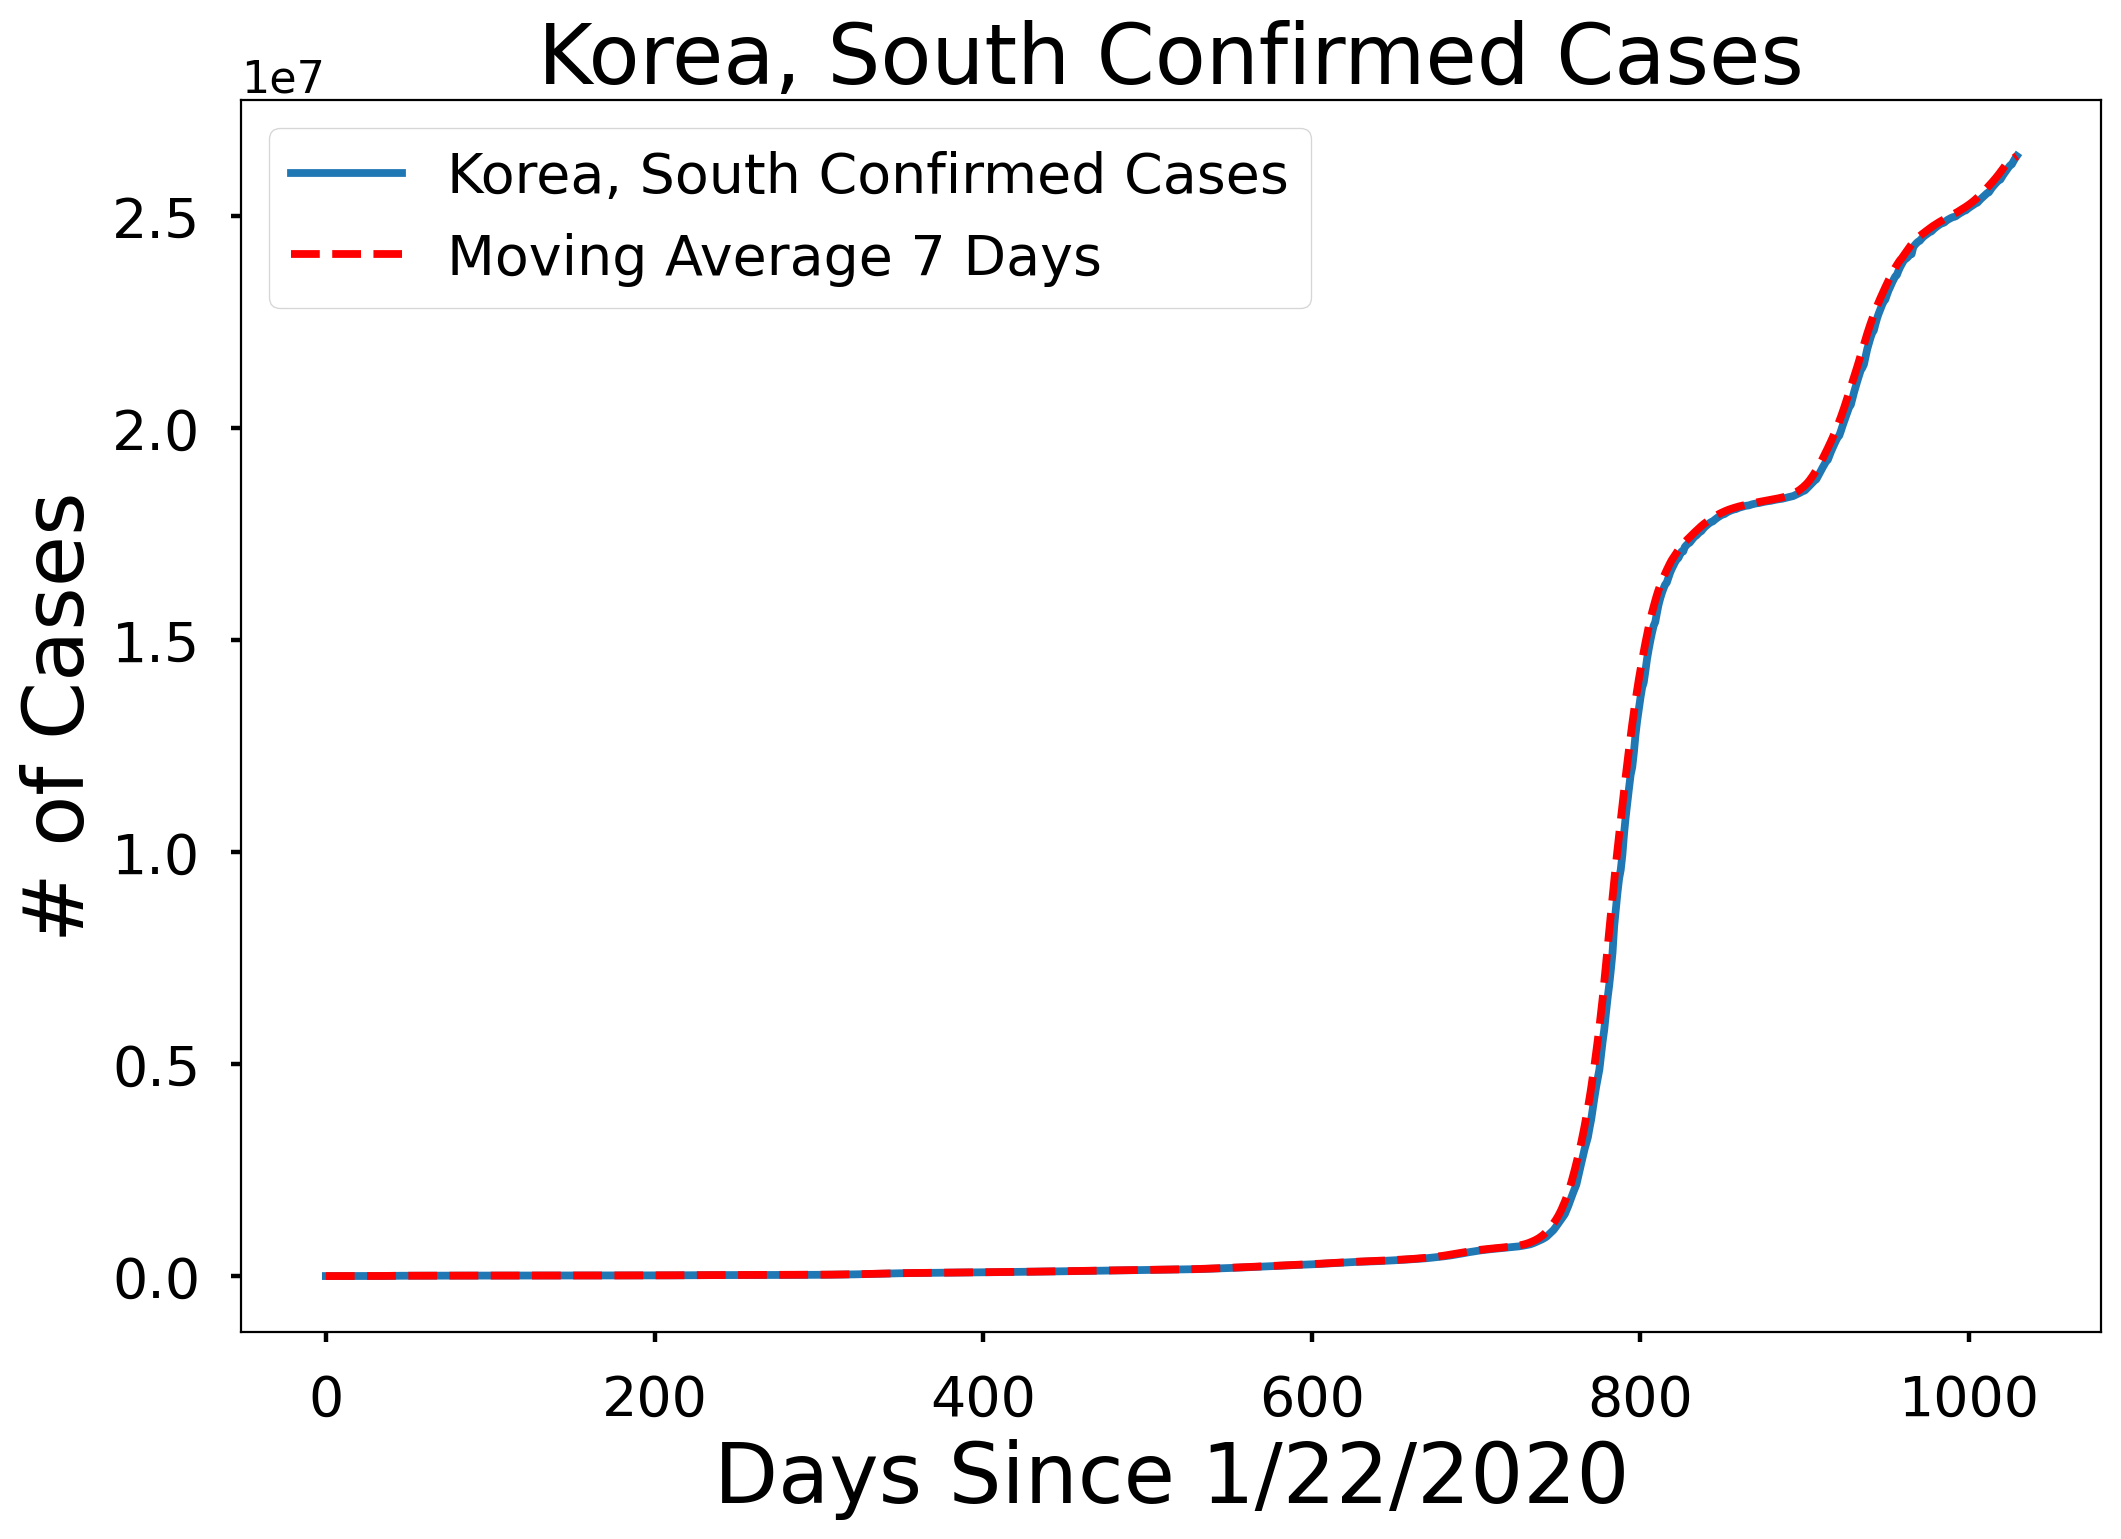

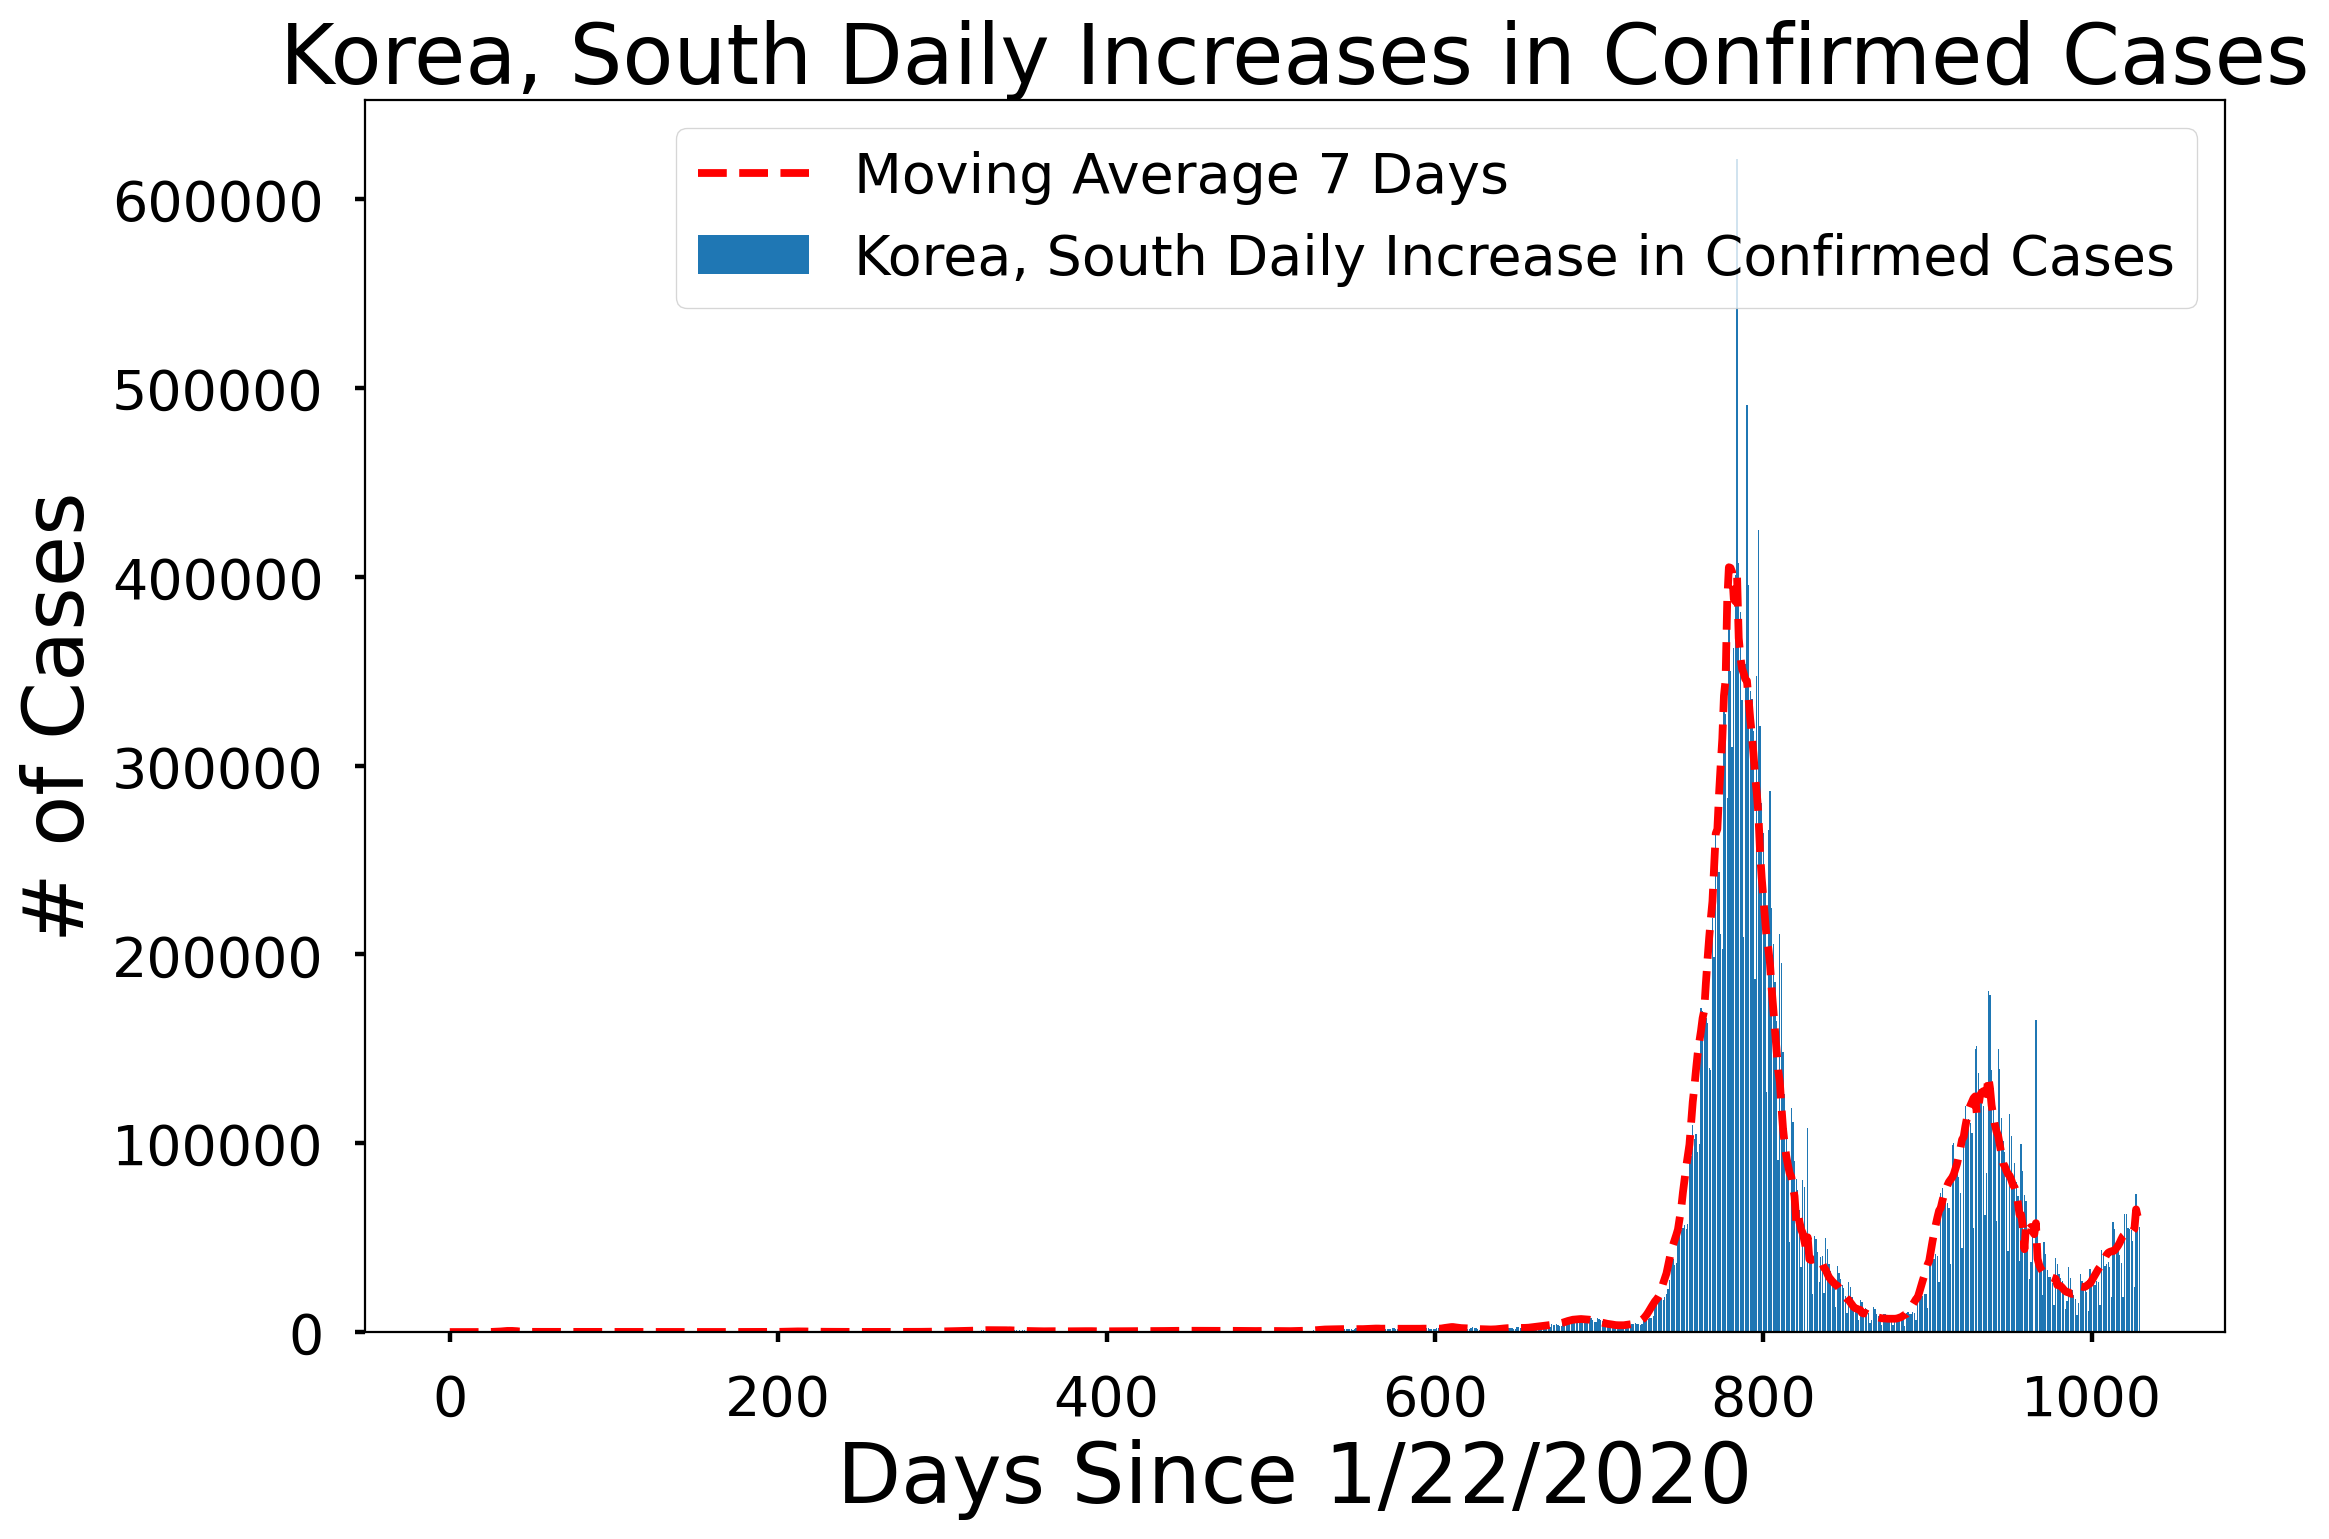

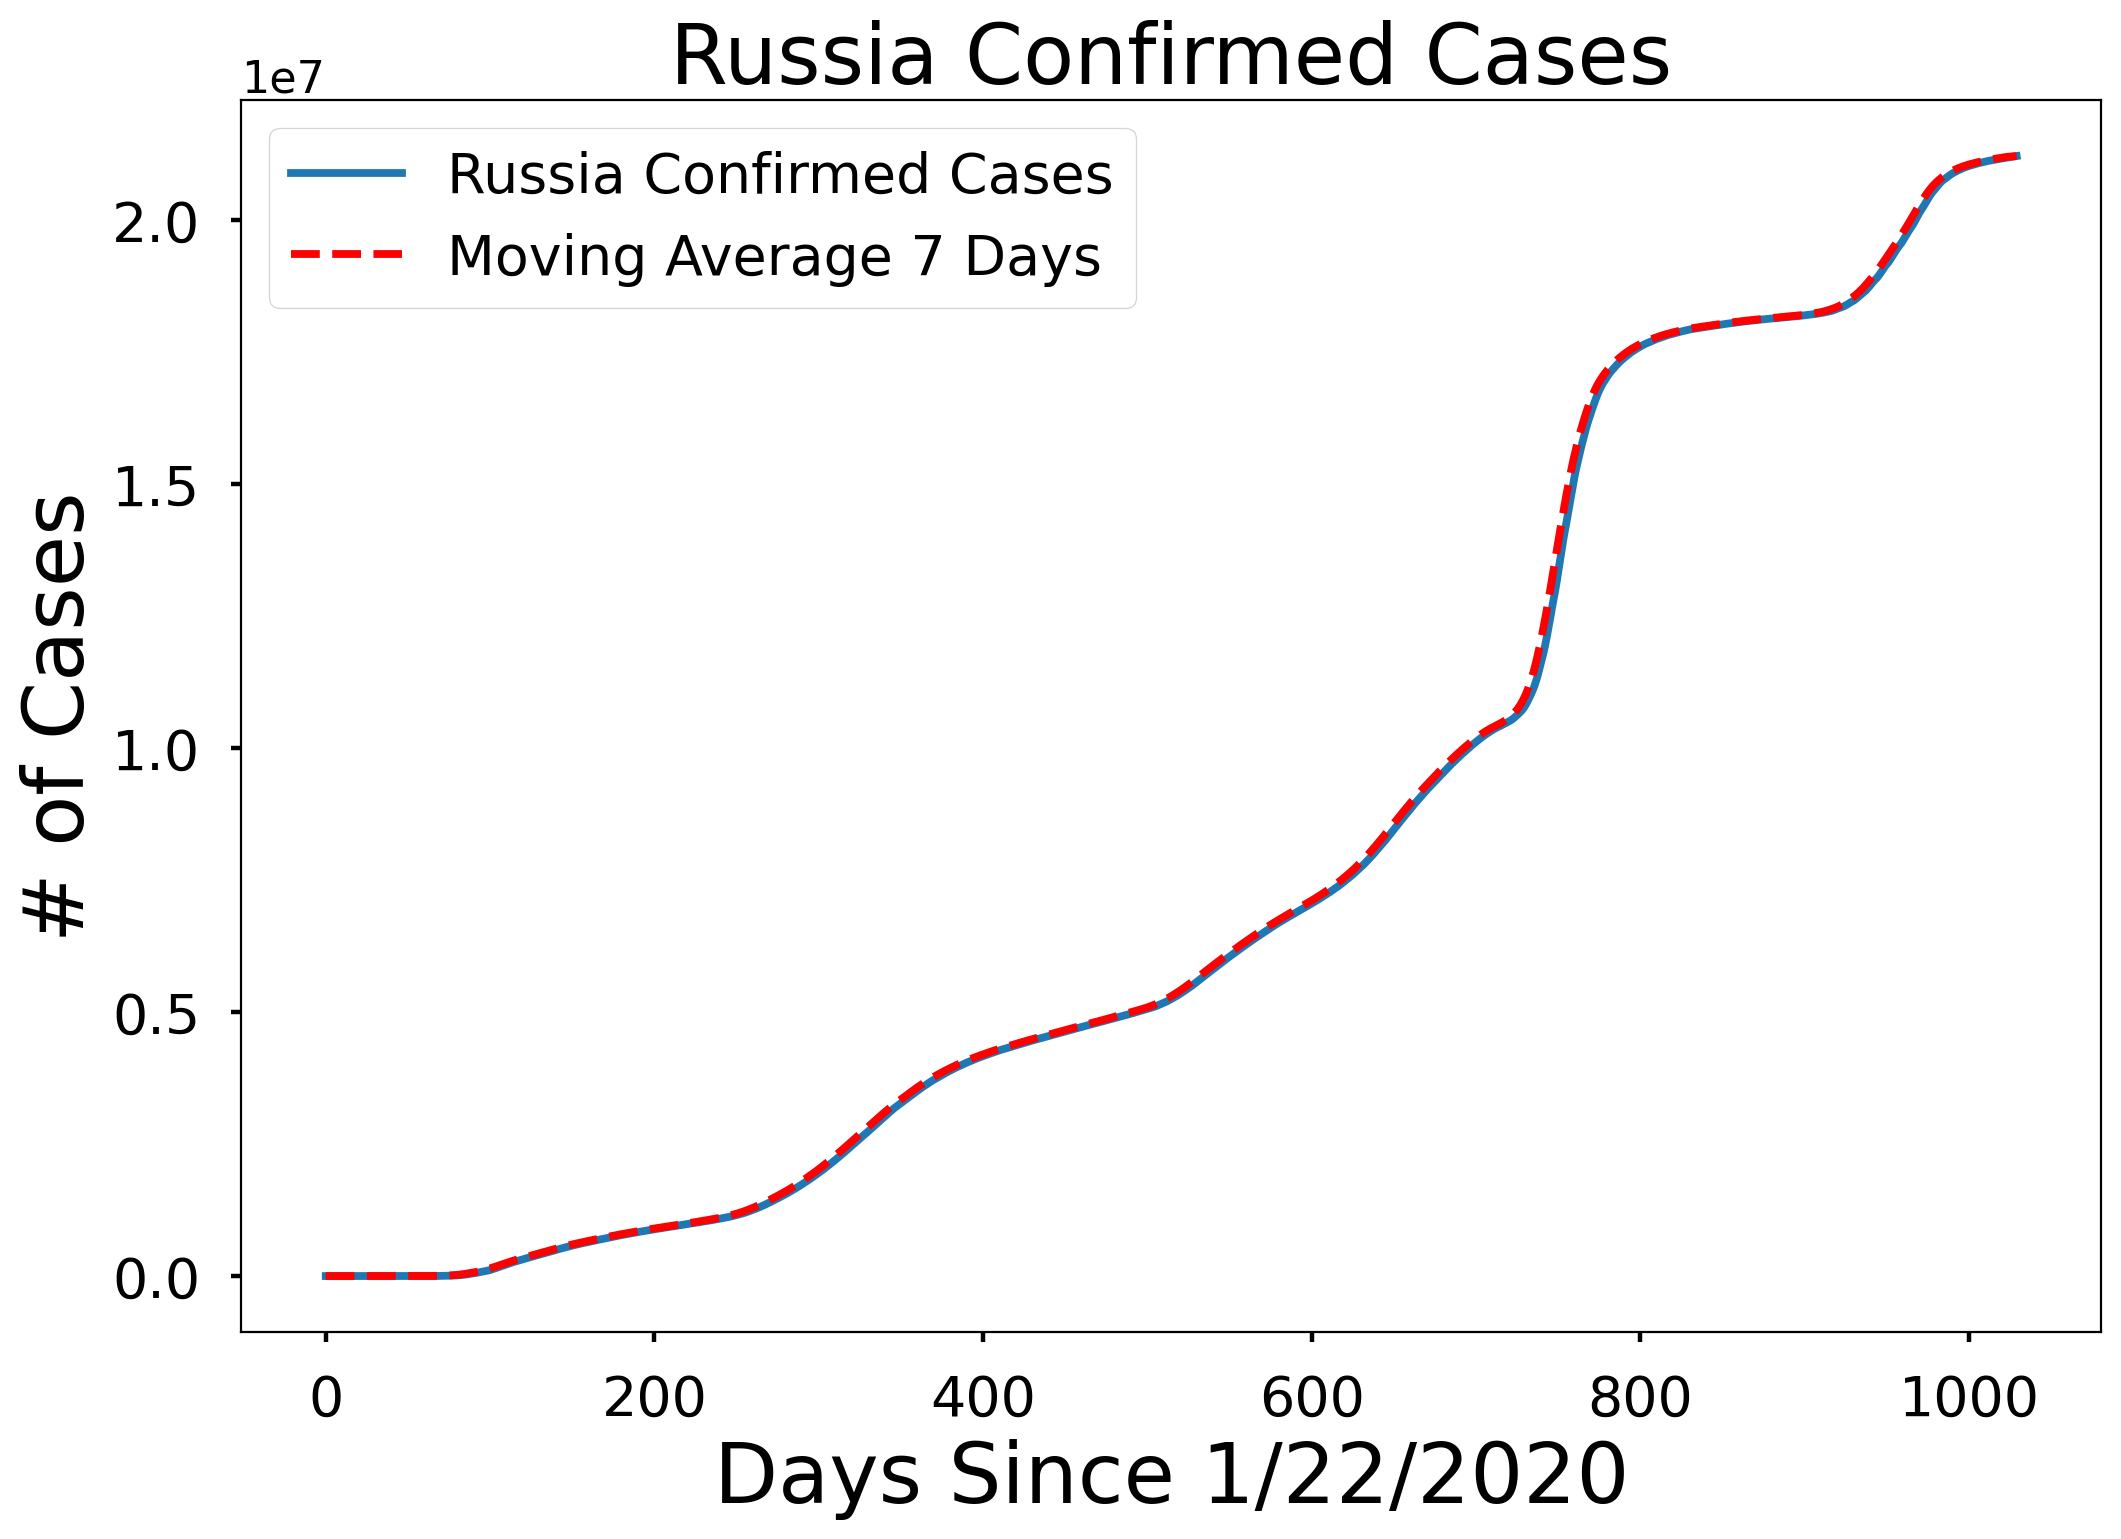

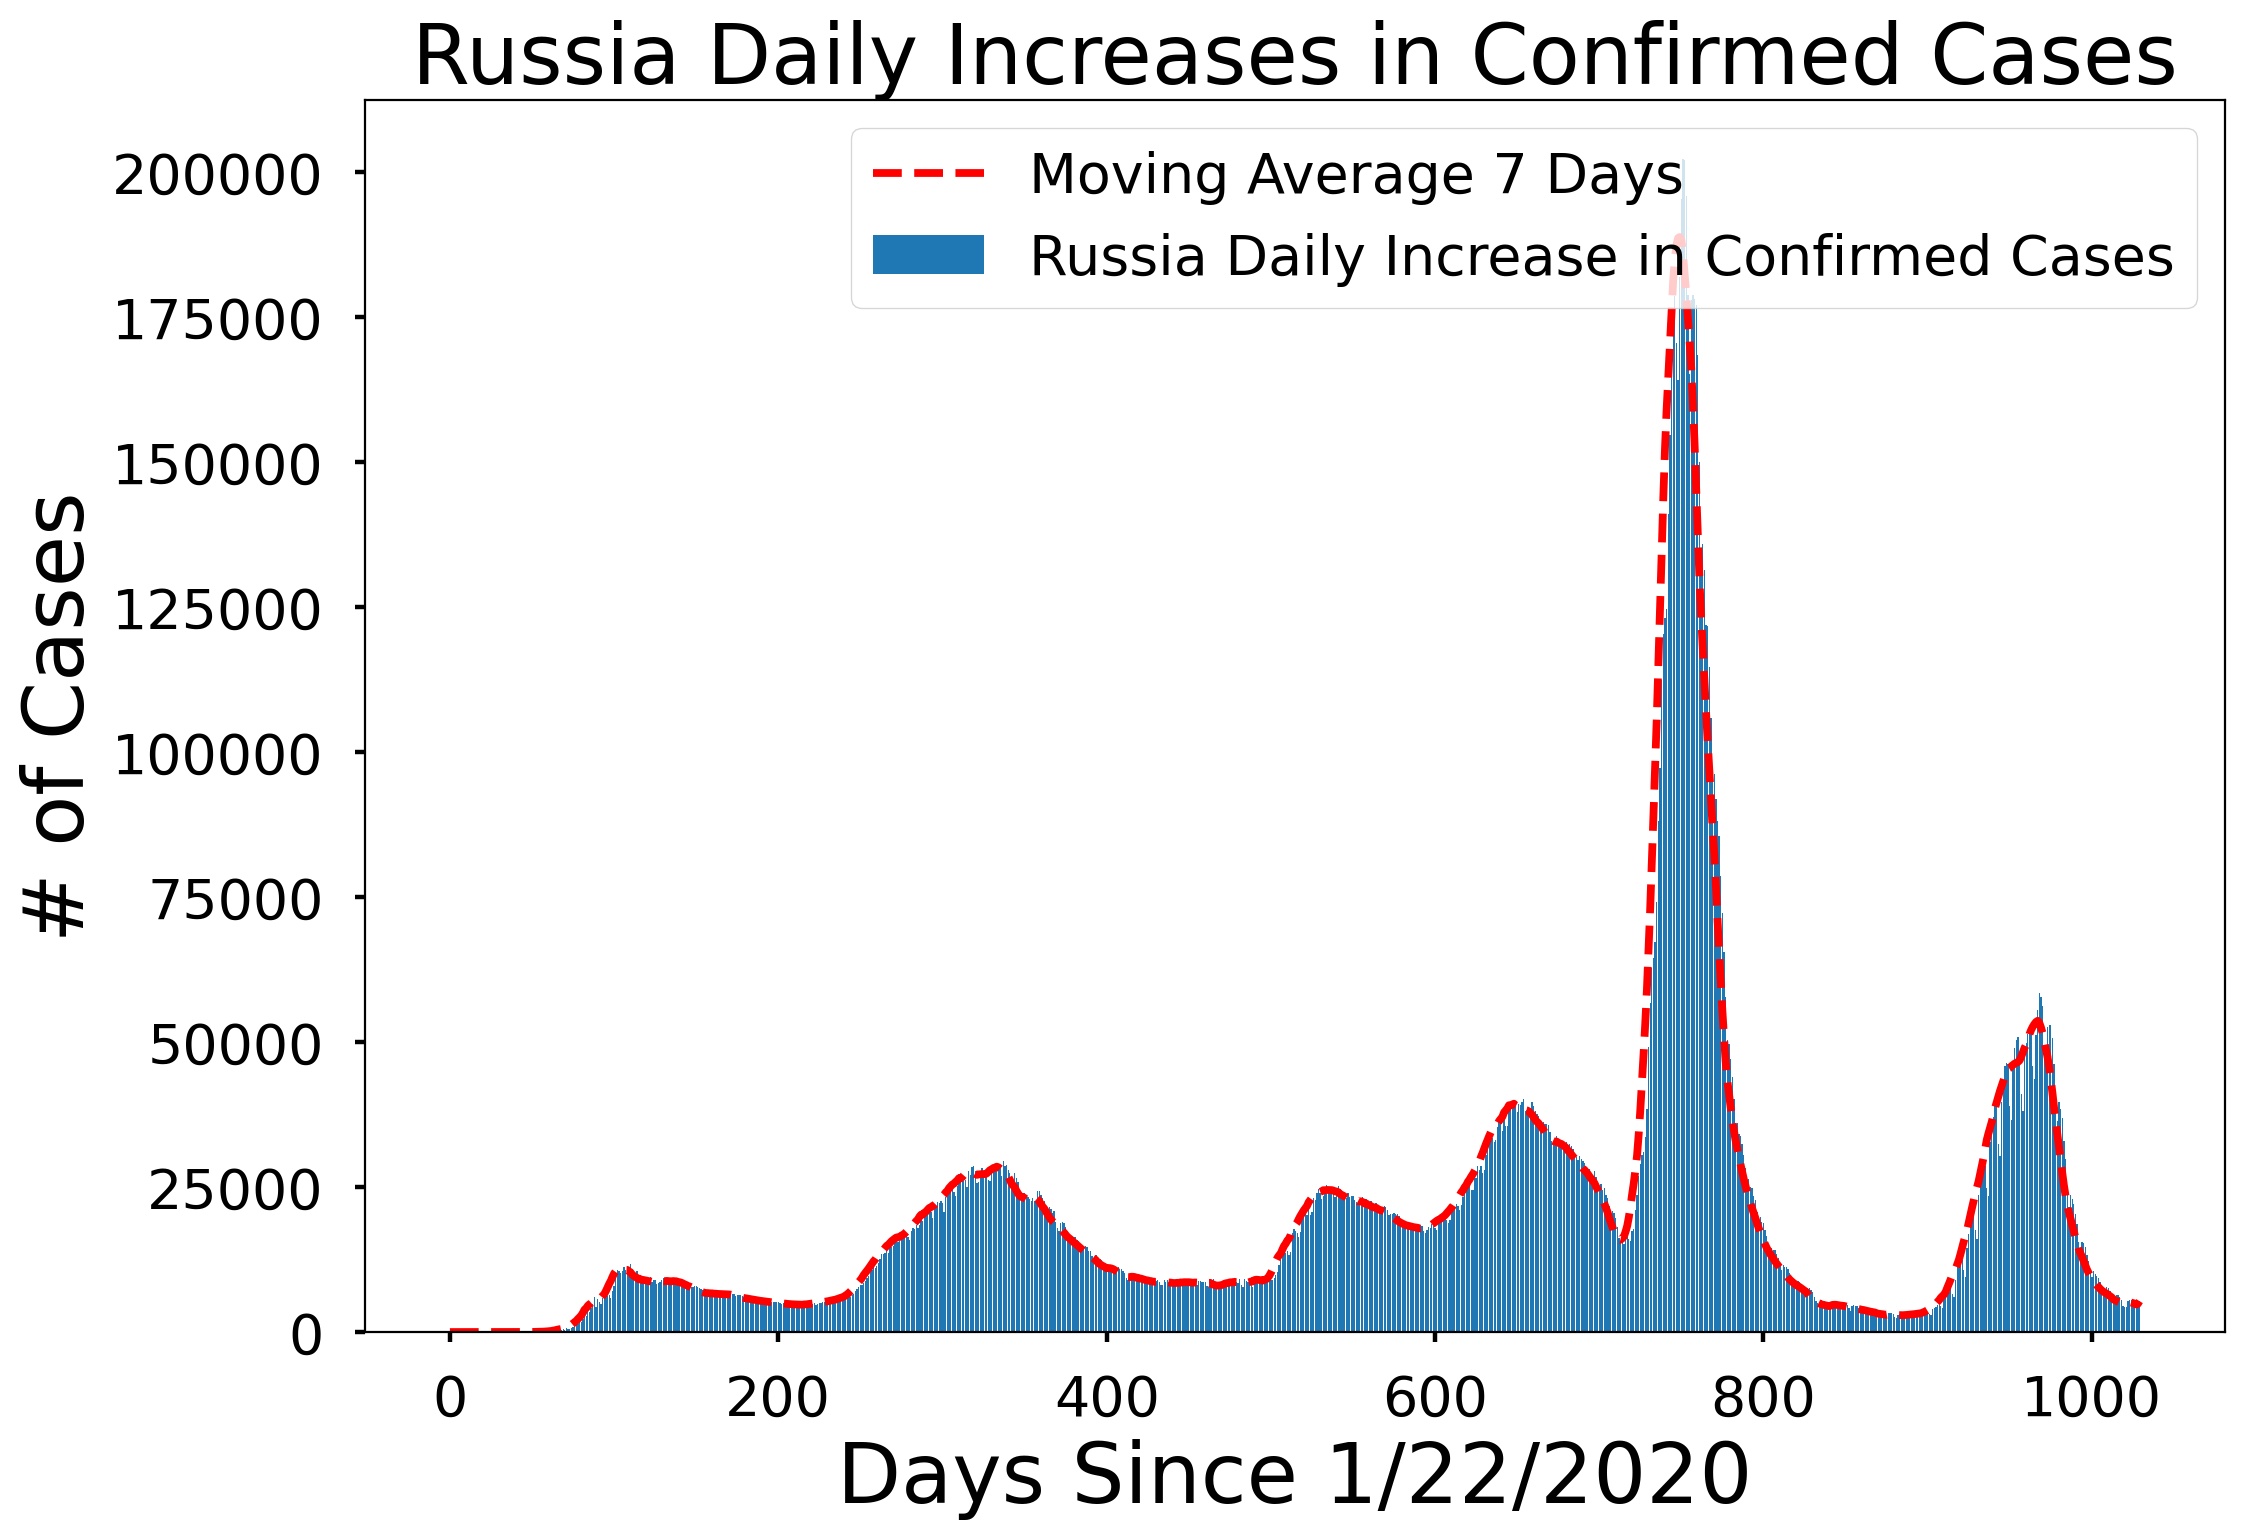

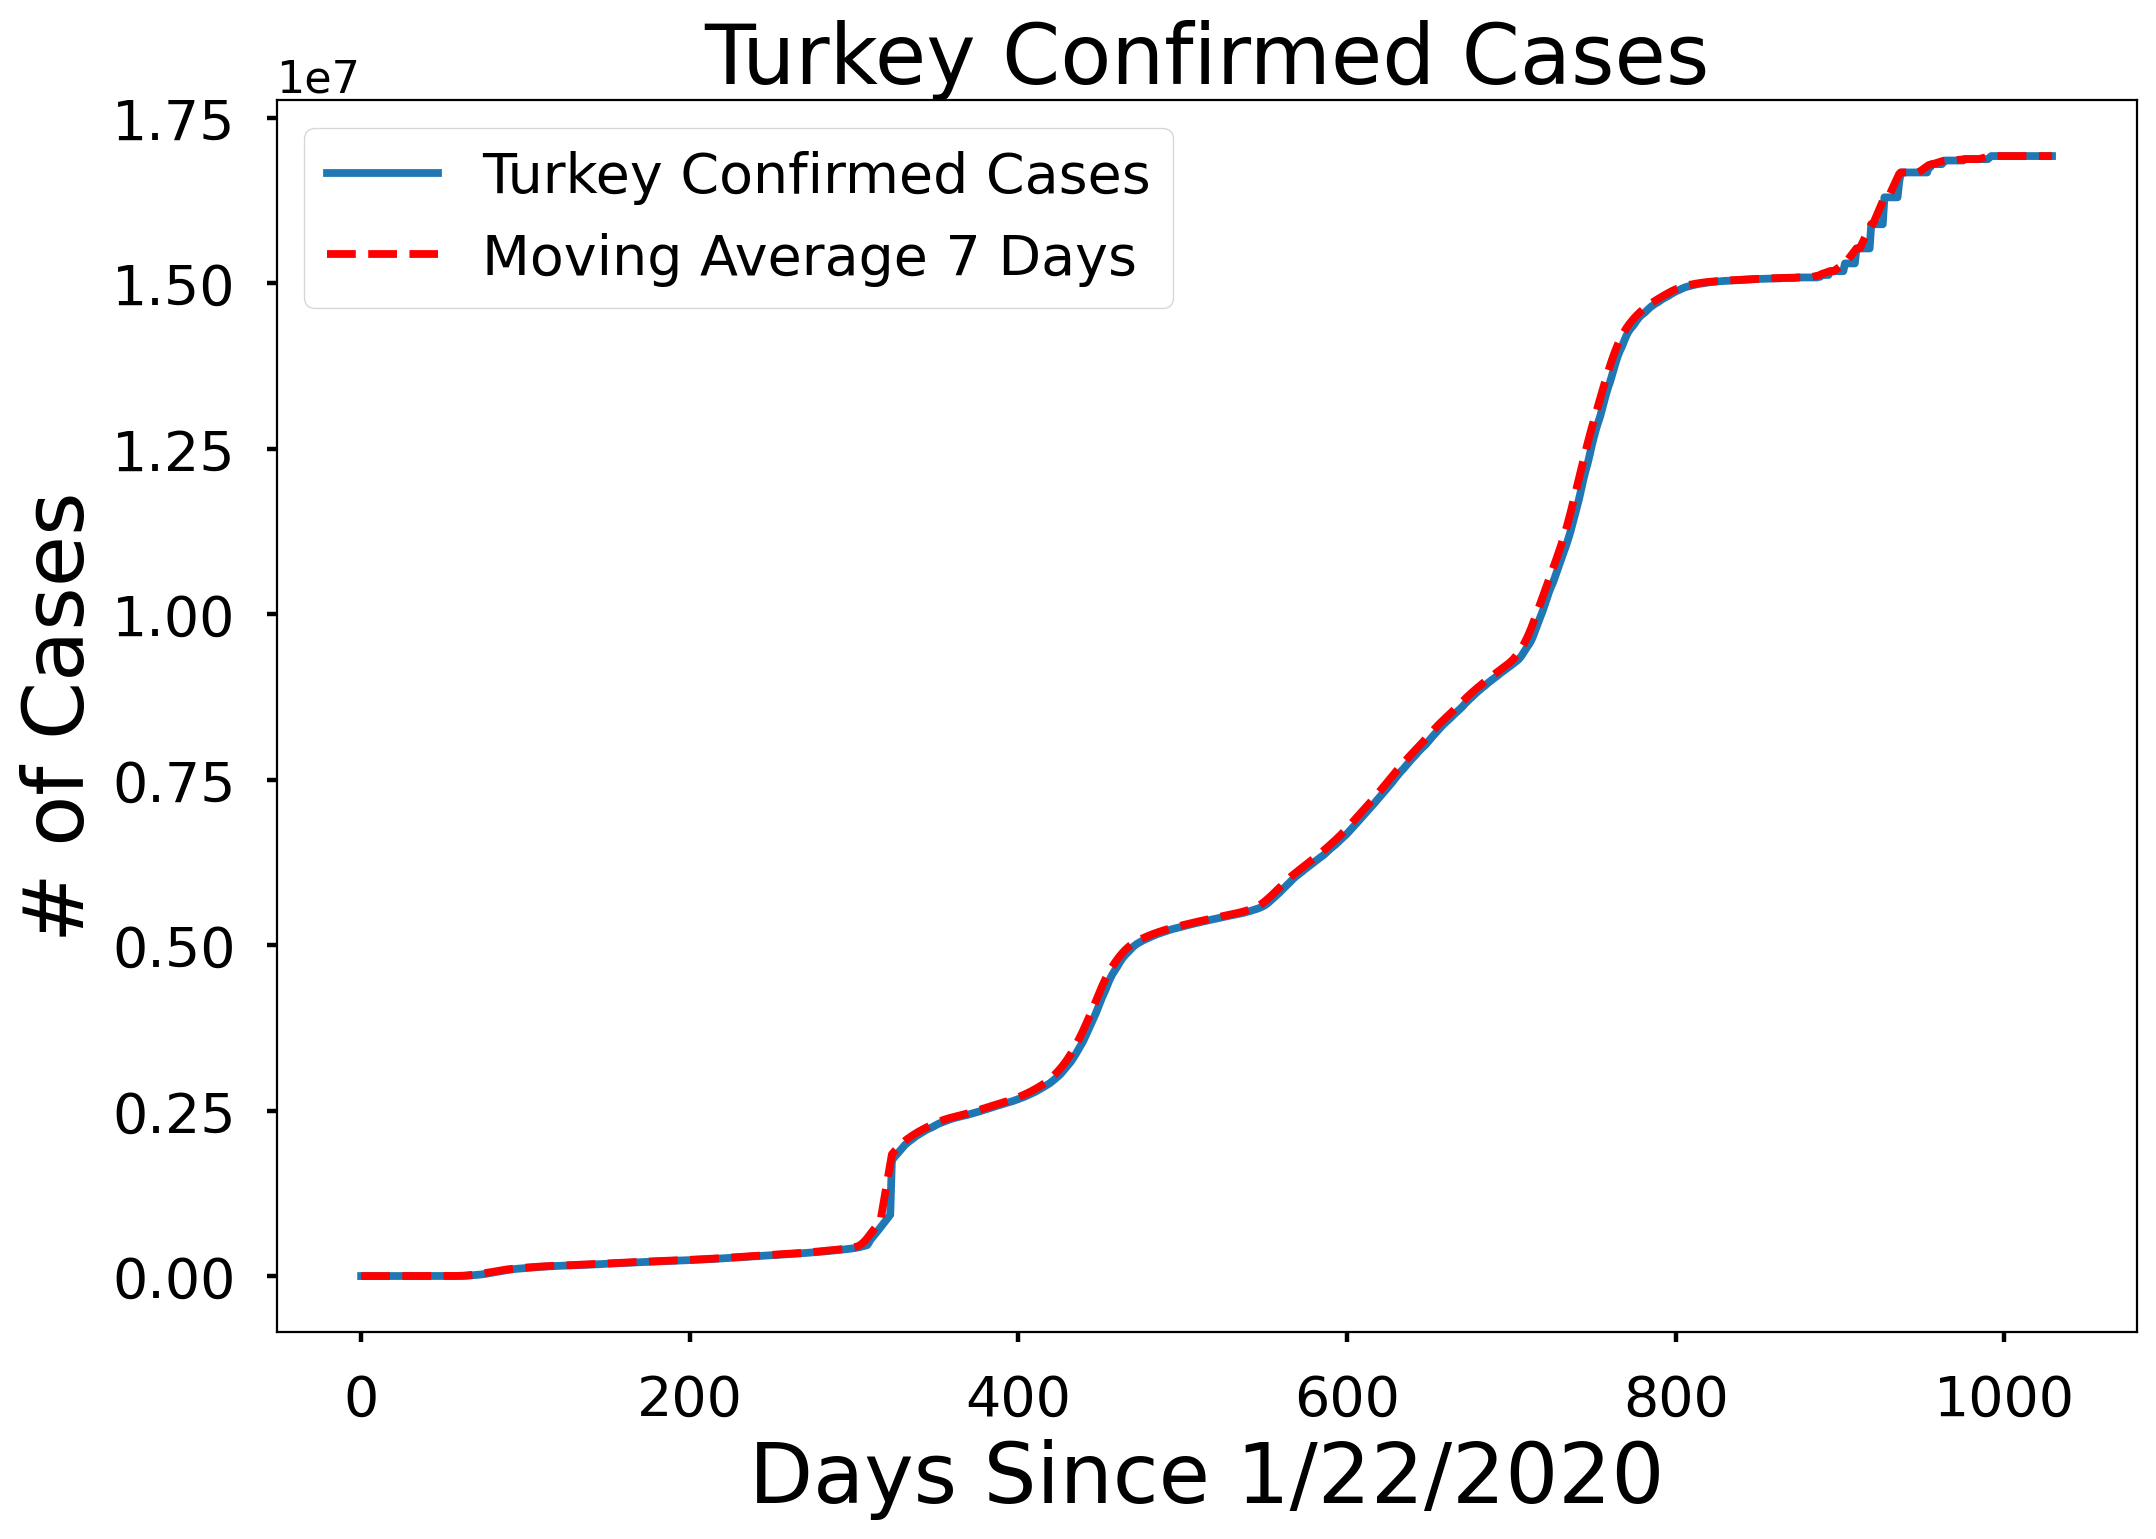

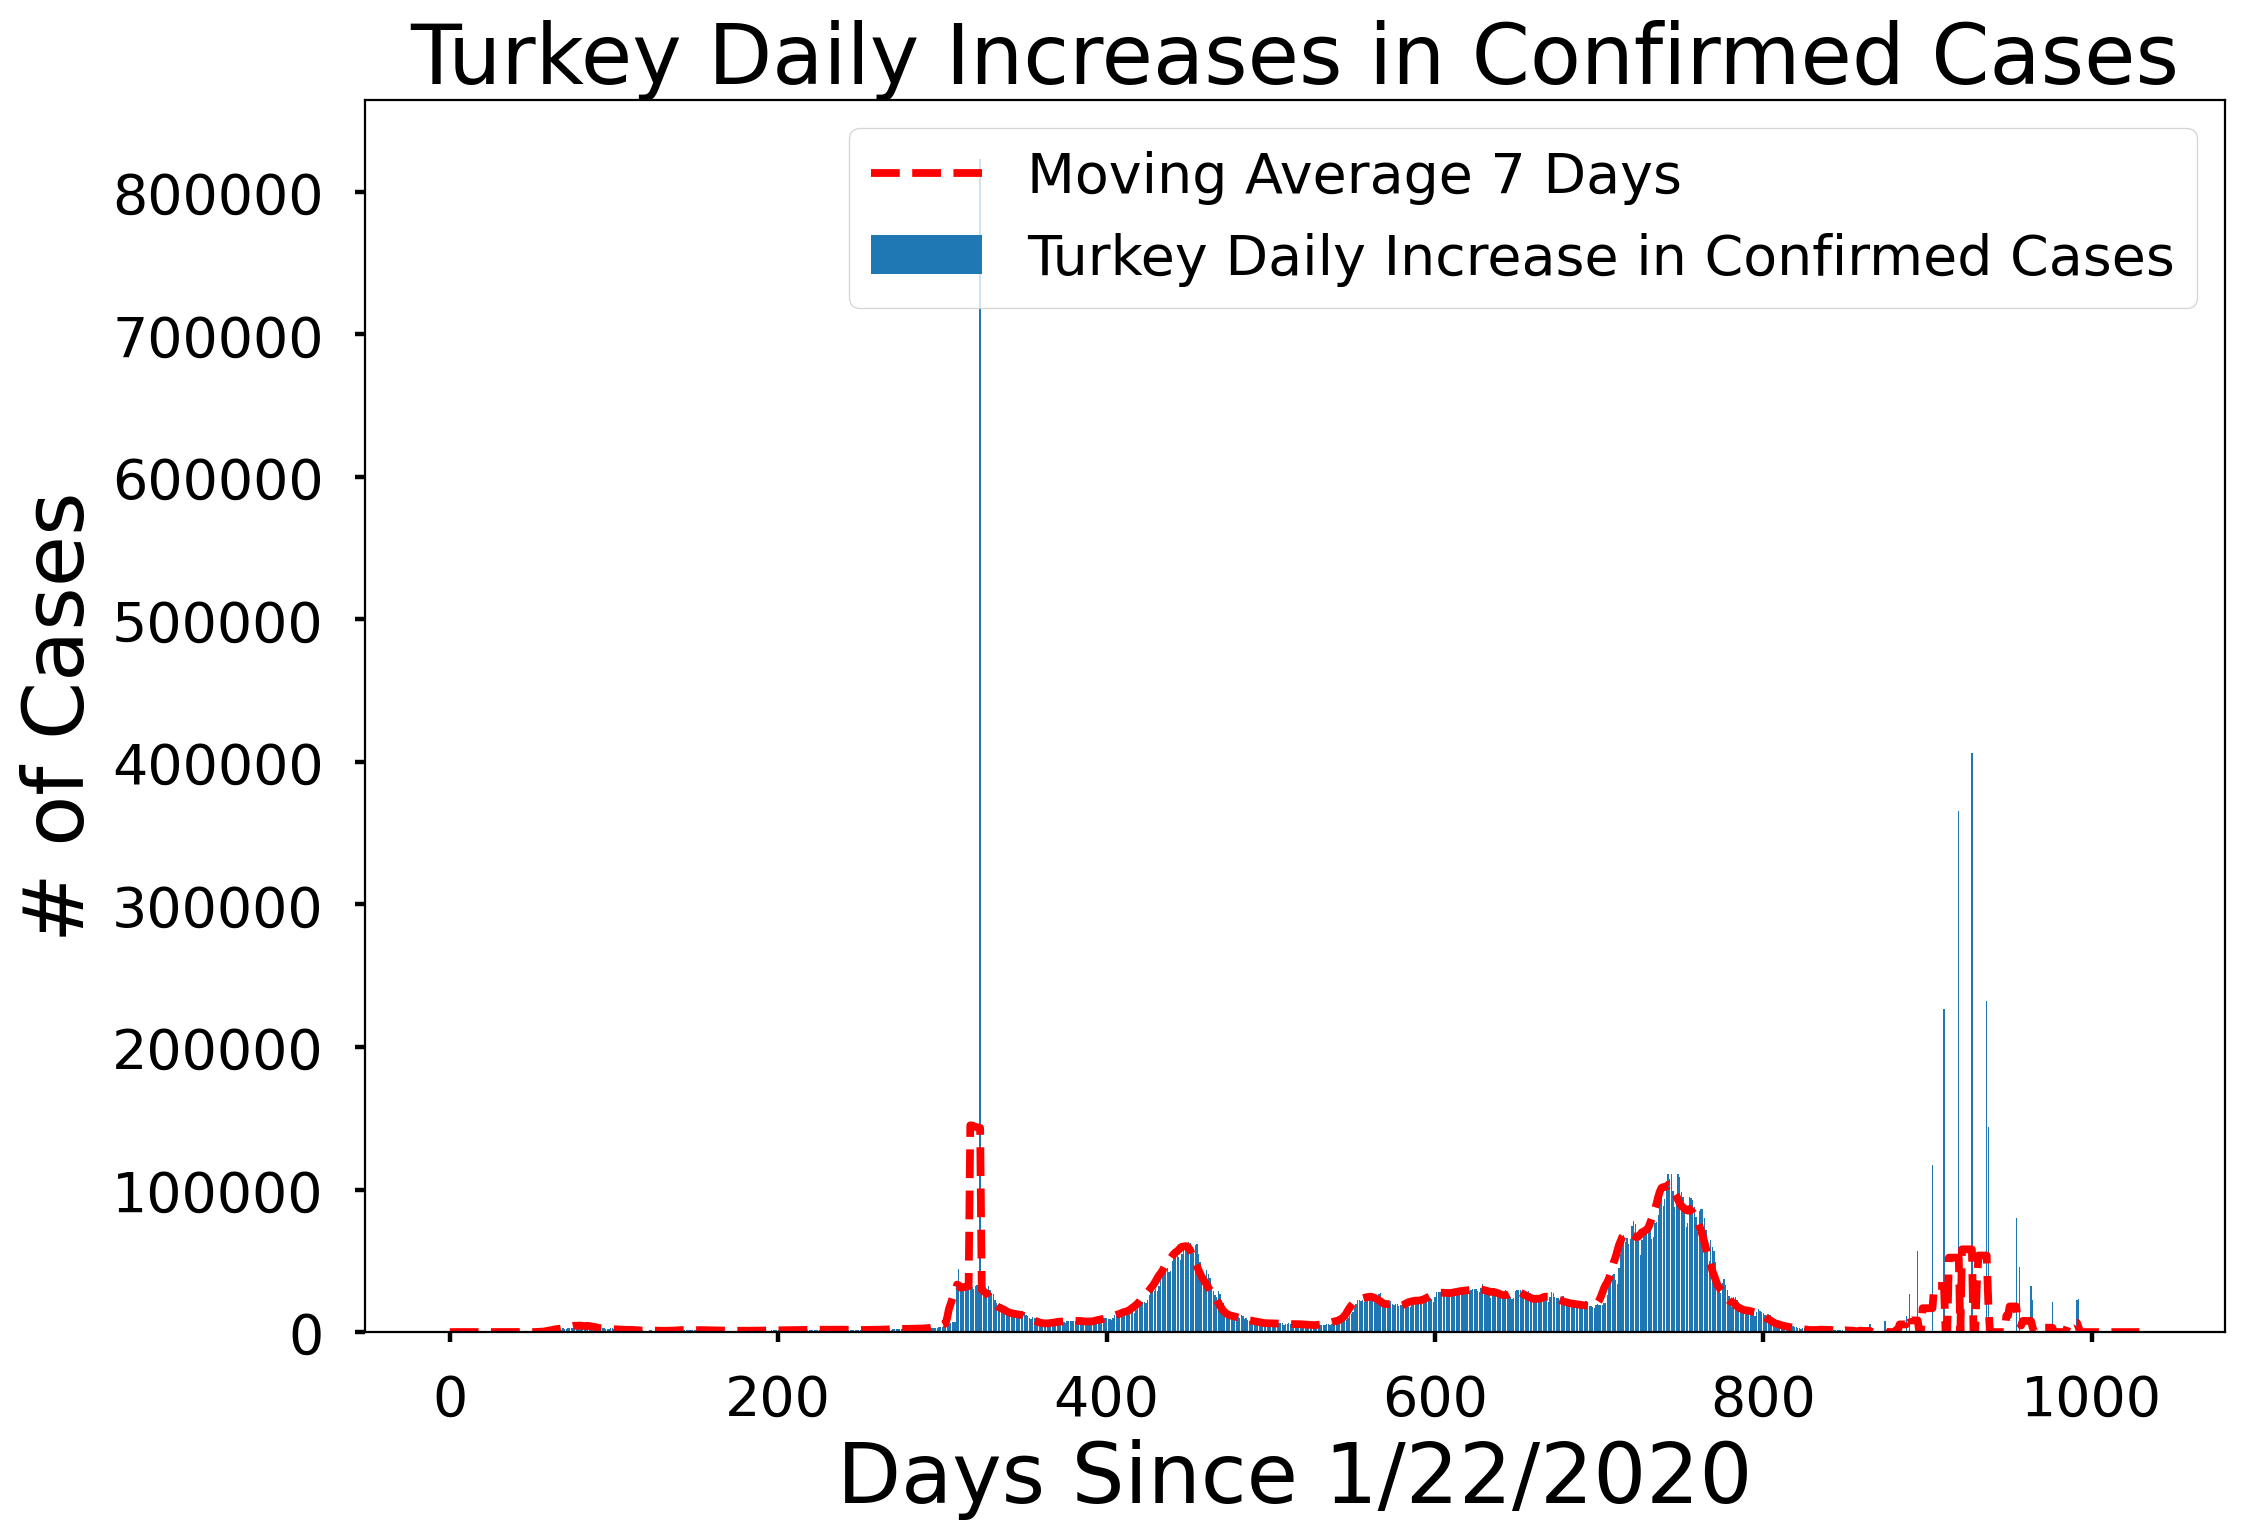

In [68]:
# top 10 total covid cases as of 7/13/2022
countries = ['US', 'India', 'Brazil', 'France', 'Germany', 'United Kingdom', 'Italy', 'Korea, South',
             'Russia', 'Turkey']

for country in countries:
    country_visualizations(country)

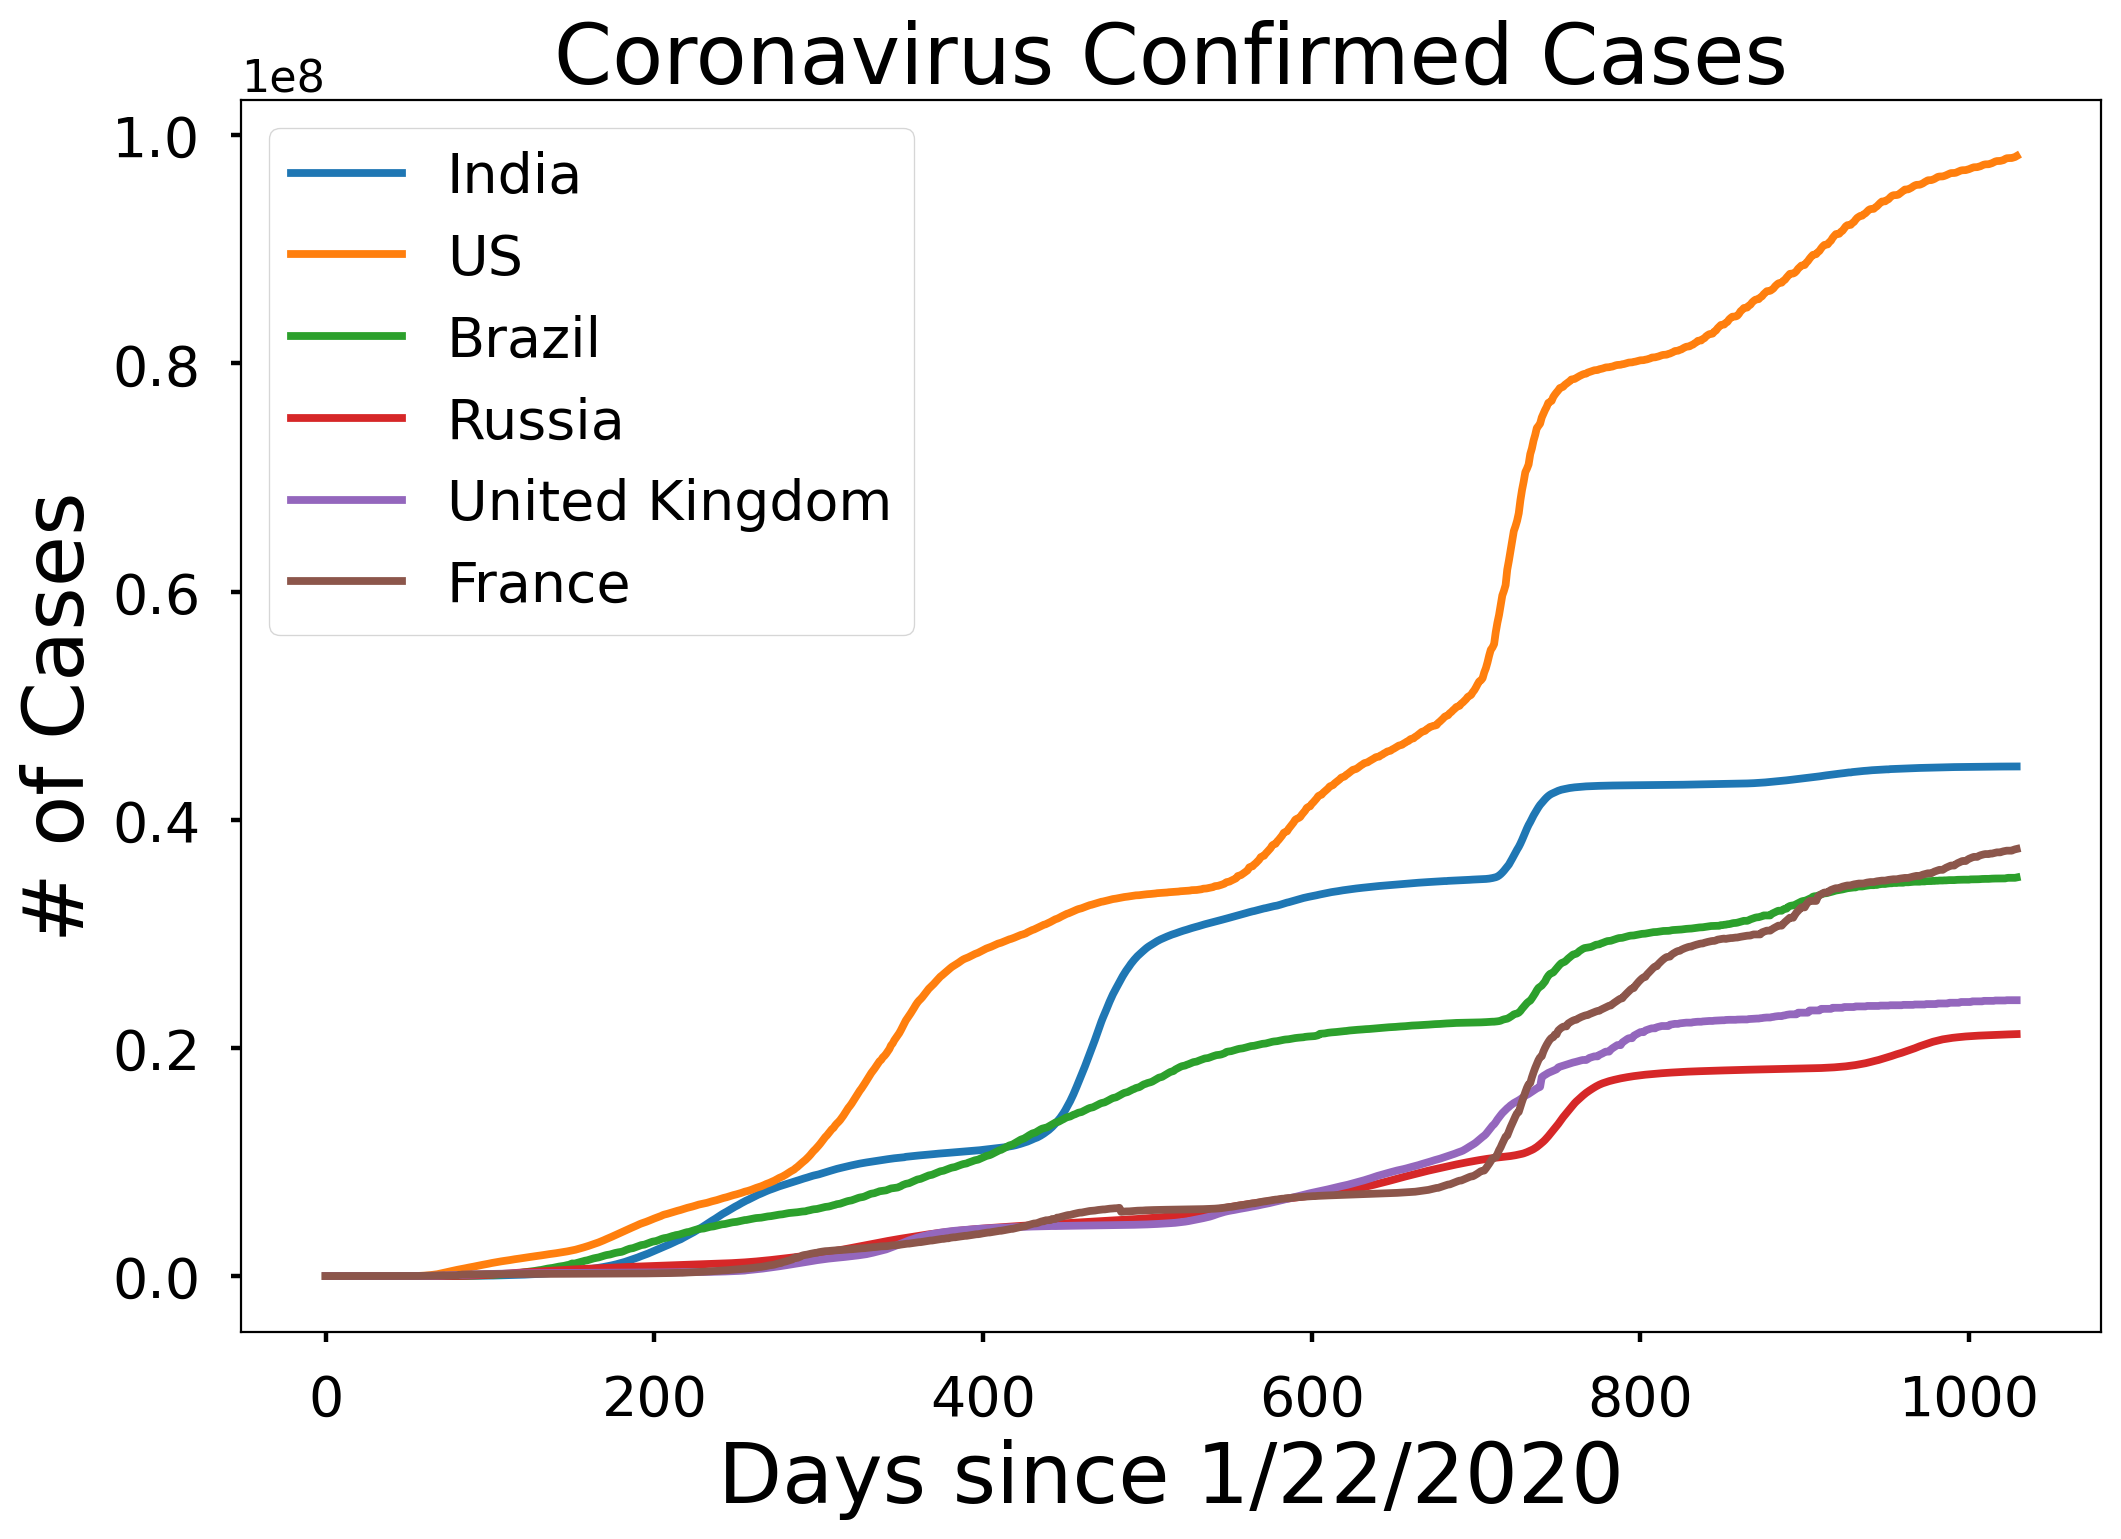

In [69]:
# Country Comparison
# removed redundant code

compare_countries = ['India', 'US', 'Brazil', 'Russia', 'United Kingdom', 'France'] 
graph_name = ['Coronavirus Confirmed Cases']

for num in range(1):
    plt.figure(figsize=(12, 8))
    for country in compare_countries:
        plt.plot(get_country_info(country))
    plt.legend(compare_countries, prop={'size': 20})
    plt.xlabel('Days since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.title(graph_name[num], size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [70]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(12, 8))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Worldwide Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

# Predictions for confirmed coronavirus cases worldwide
These three models predict future covid cases on a global level. These are constructed to use the latest window of data to predict the current trend. 

The prediction models include 
* Support Vector Machine 
* Polynomial Regression 
* Bayesian Ridge Regression 

<a id='prediction'></a>

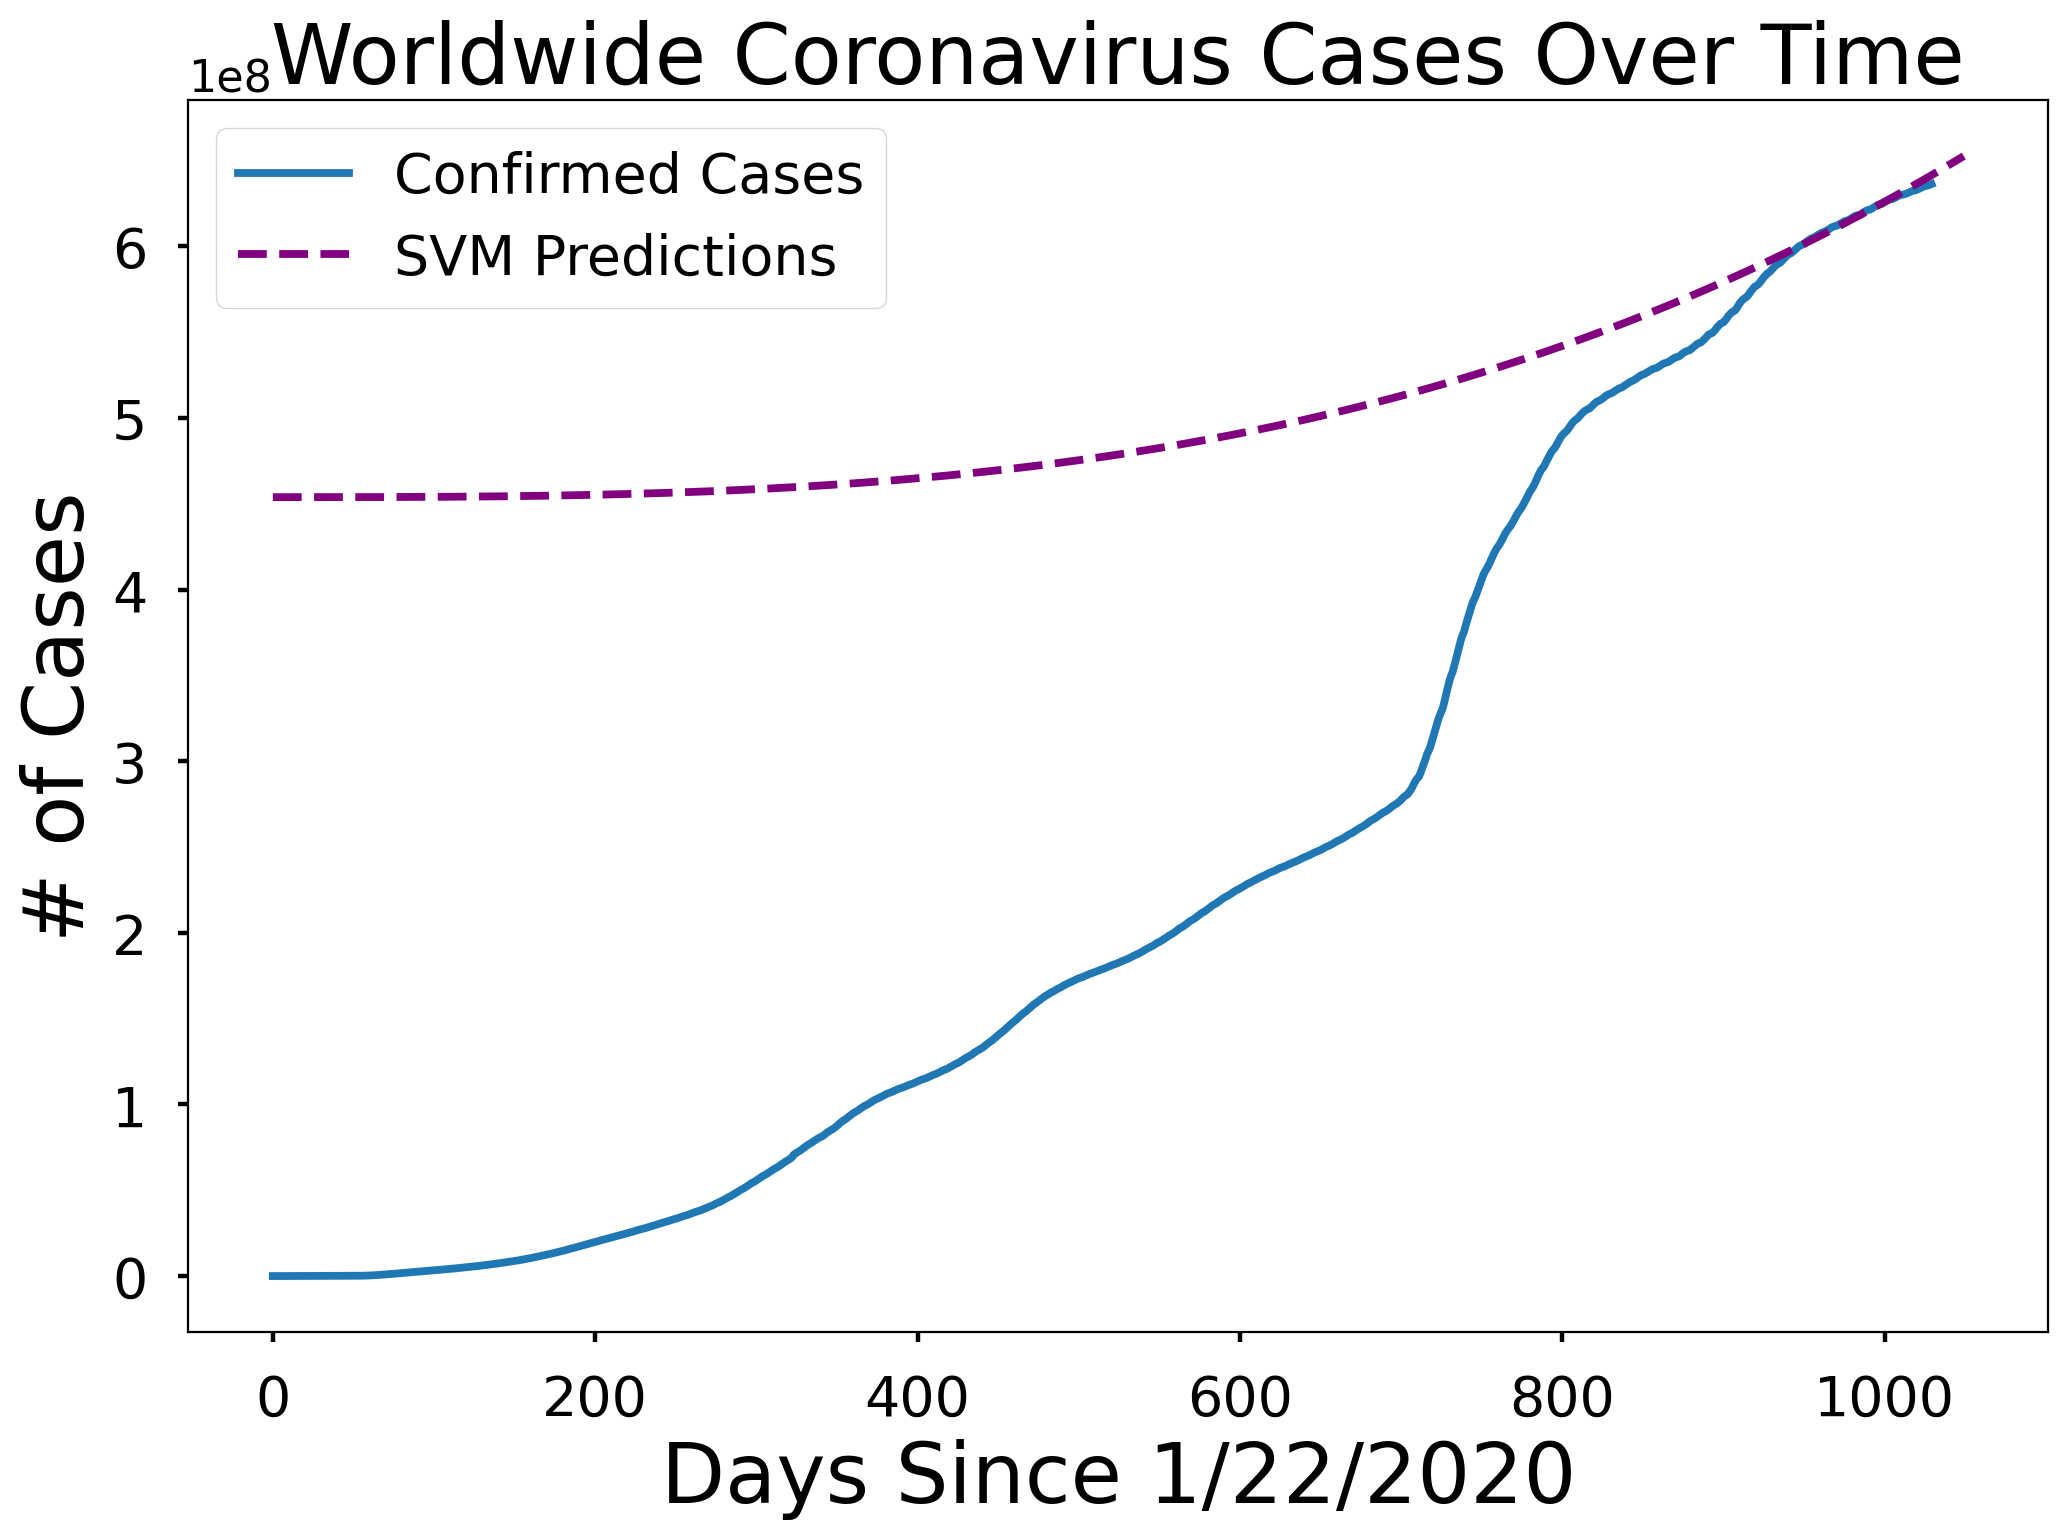

In [71]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')

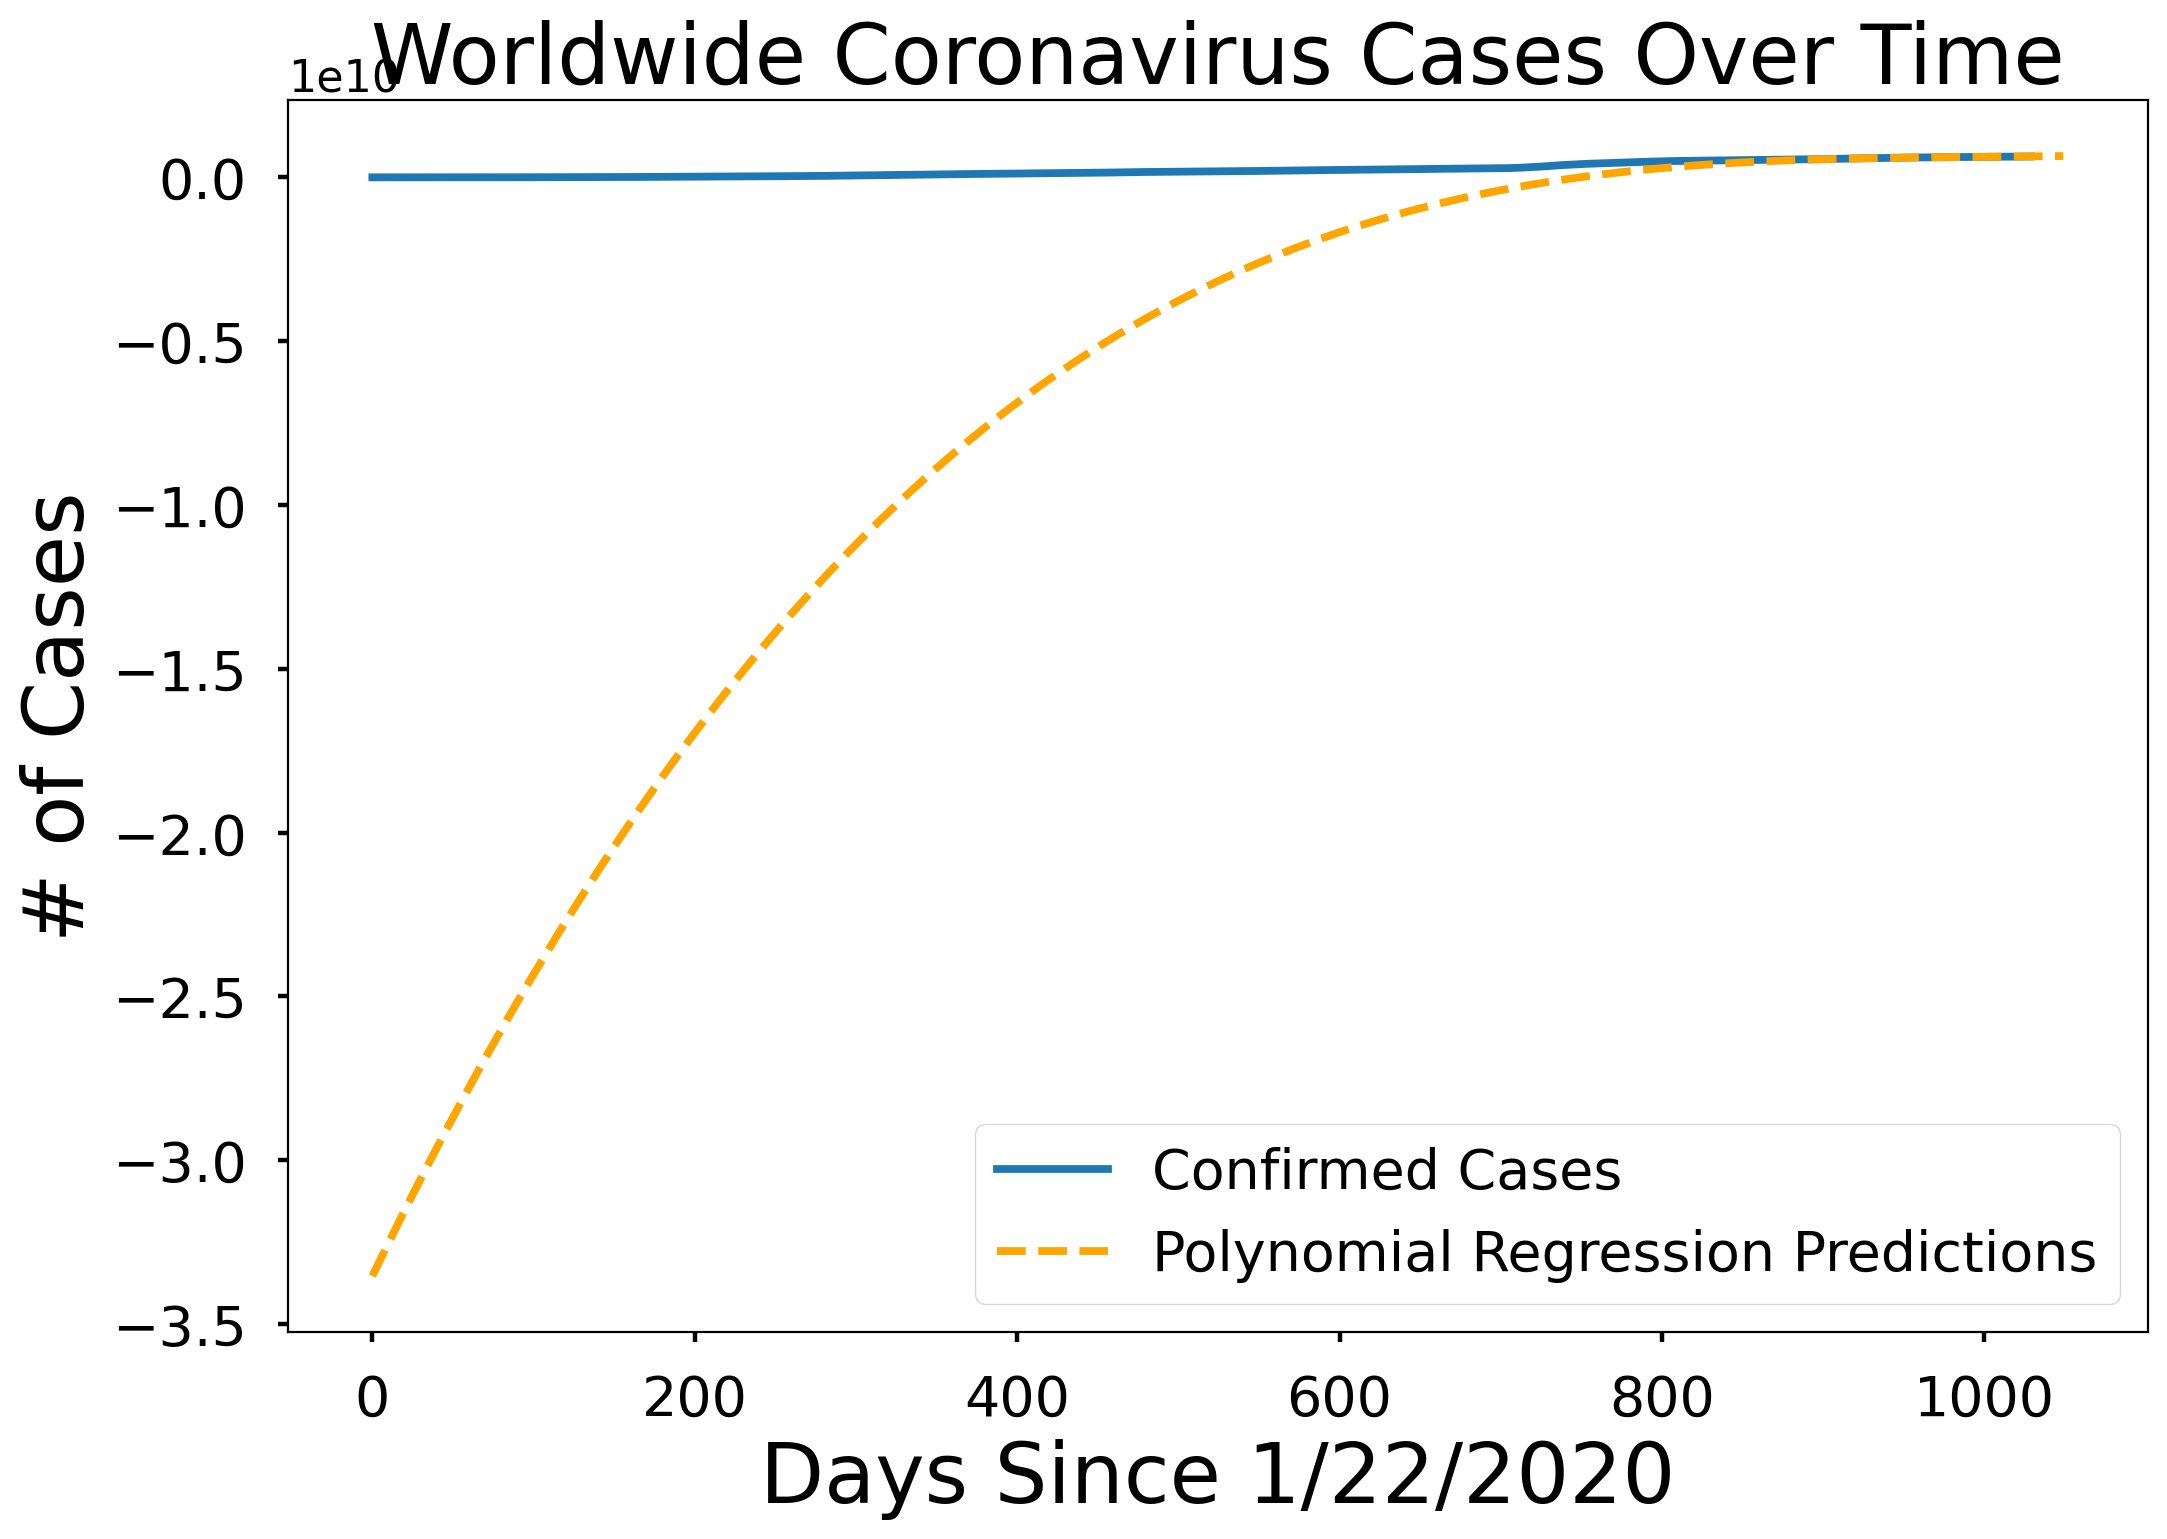

In [72]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

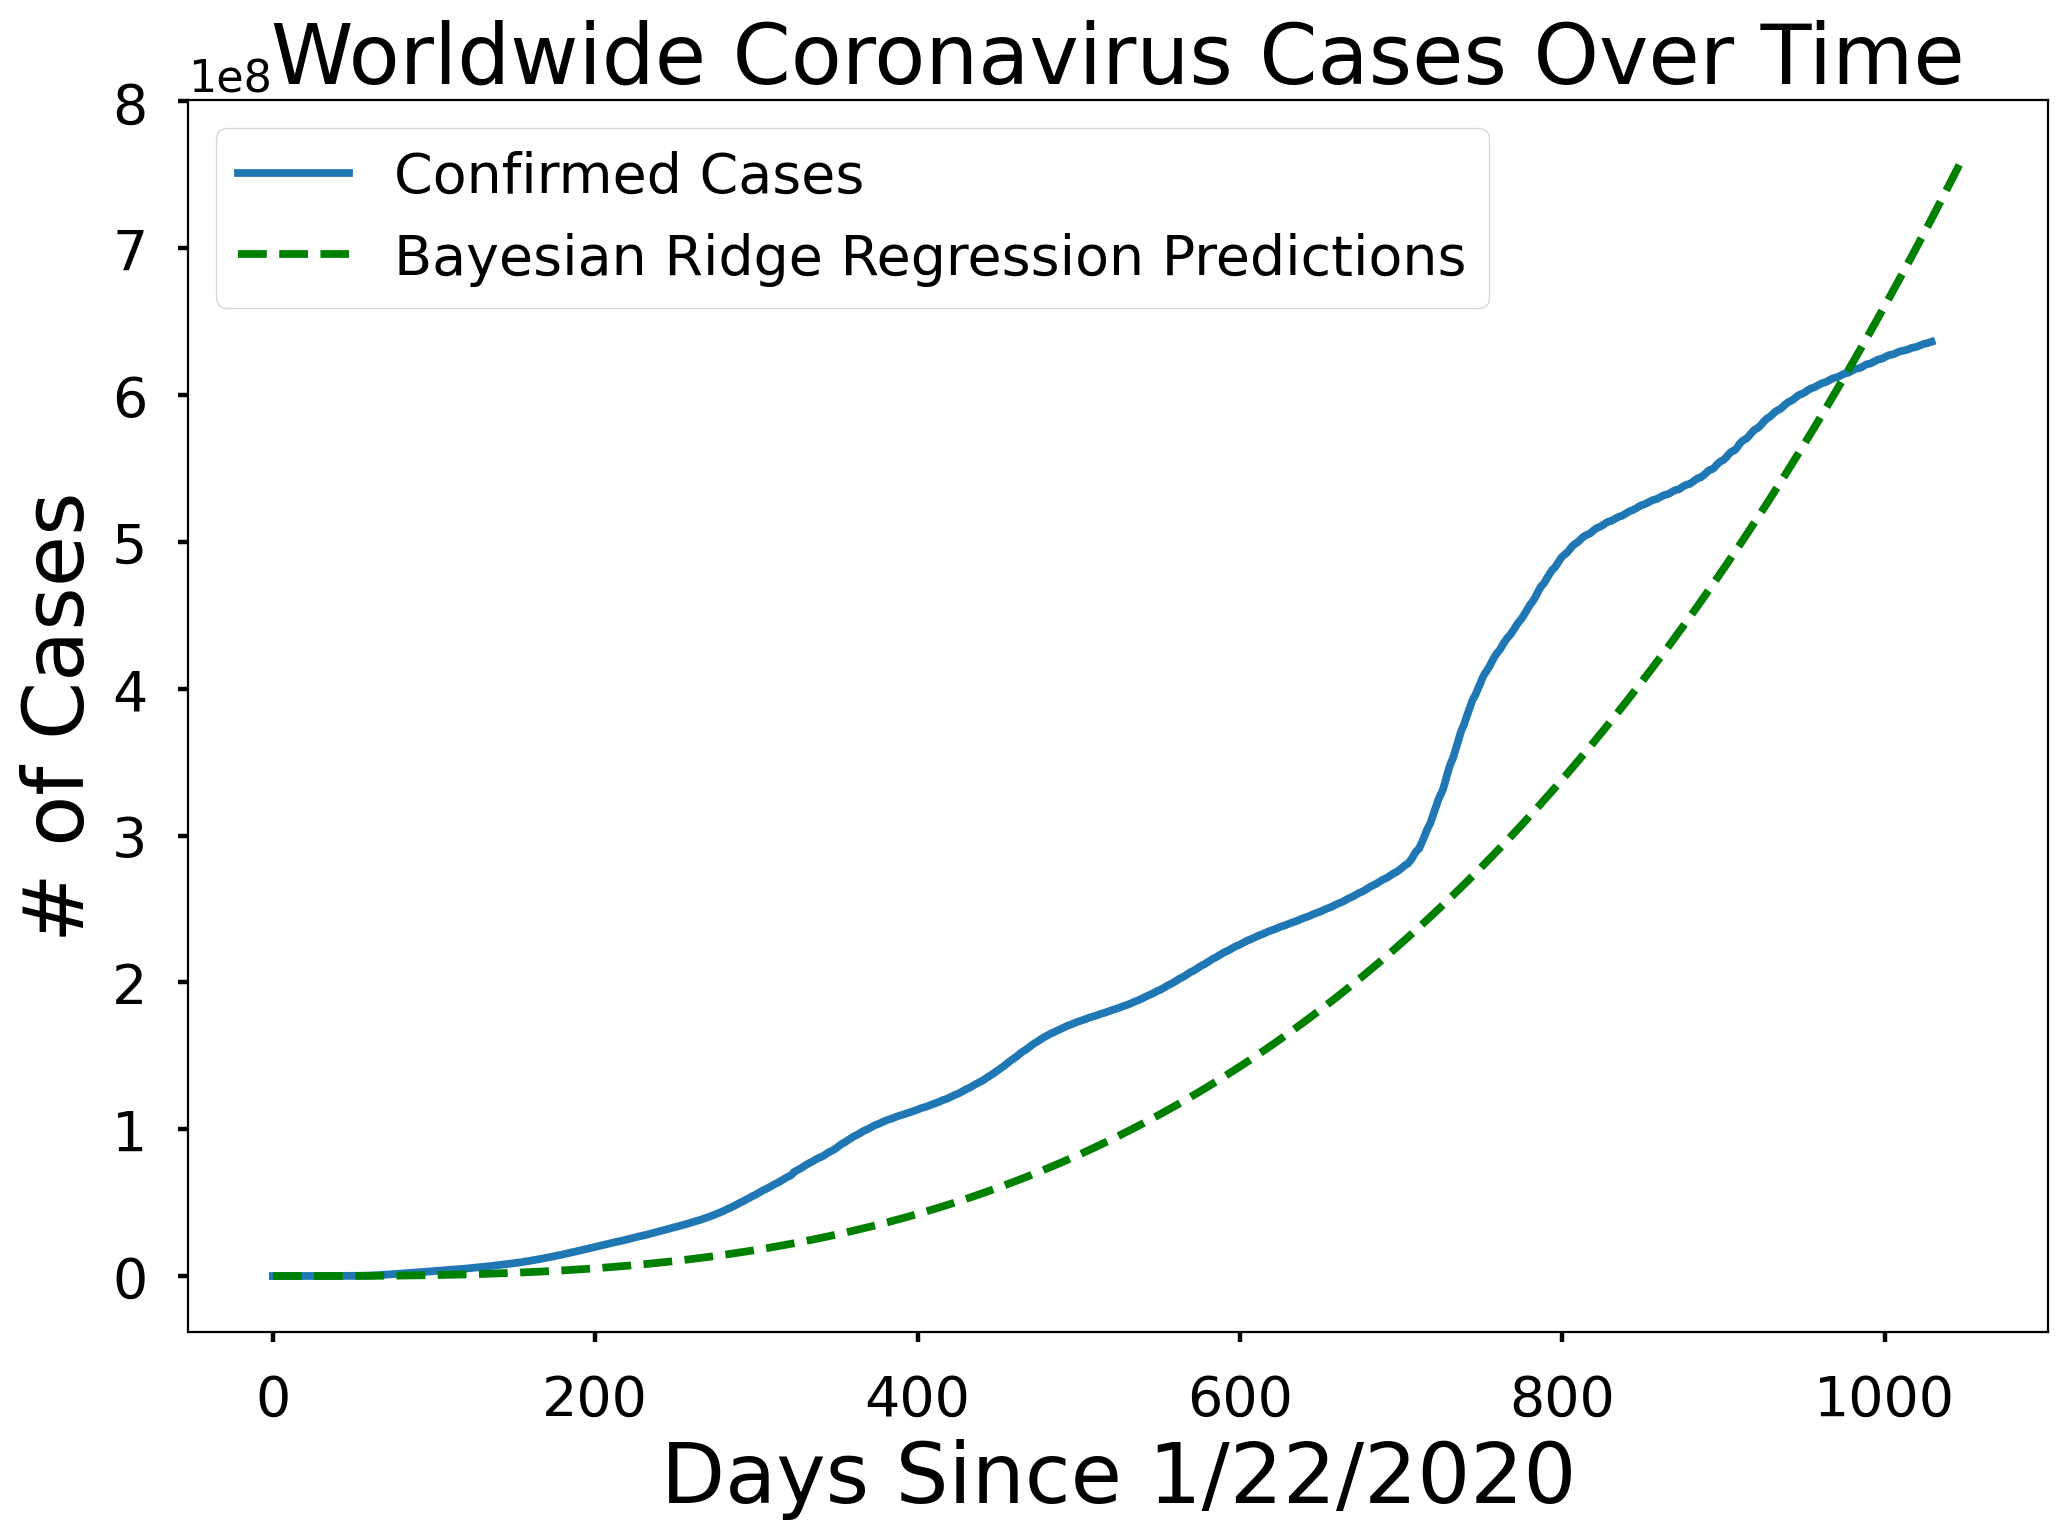

In [73]:
plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

In [74]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df.style.background_gradient(cmap='Reds')

In [75]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
linear_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
linear_df.style.background_gradient(cmap='Reds')

In [76]:
# Future predictions using Bayesian Ridge 
bayesian_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
bayesian_df.style.background_gradient(cmap='Reds')